---
title: "Curriculum Learning ü§ù DSPy: Optimization"
author: Shubham Gupta
date: '2025-09-14'
description: Optimzing DSPy programs for ConvFinQA
image: ../cl_dspy/submission_mlflow_metrics.png
categories:
  - programming
  - dspy
  - curriculum-learning
---

In Part 1 we carved the ConvFinQA corpus into curriculum-aware difficulty tiers through some EDA (https://shubhamg.in/posts/2025-08-31-cl-dspy-eda.html). Part 2 turned that insight into zero-shot baselines, pitting several LLMs against each tier (https://shubhamg.in/posts/2025-09-01-cl-dspy-modelling/). The hard bucket still hurt, which is proof that smarter prompting, not bigger models, is our next lever.

In this installment, instead of costly fine-tunes we‚Äôll use DSPy‚Äôs programmatic prompt optimizers to lift accuracy beyond the Part 2 ceiling. We‚Äôll iterate over the shortlisted models:
- o4-mini, 
- o3 
- gemini-2.5-flash (this couldn't be completed due to rate limits unfortunately)

We feed each model curriculum-ordered exemplars, and let DSPy search the prompt space under tight token and latency caps. 

## Setup

### Baseline recap
- Zero-shot baselines from Part 2 (https://shubhamg.in/posts/2025-09-01-cl-dspy-modelling/) established a ceiling on Medium/Hard tiers.
- Shortlisted models: o4-mini, o3, gemini-2.5-flash.
- Common failure modes: multi-op arithmetic chains, cross-turn dependencies, long-context/table lookups.
- Objective here: improve Medium/Hard without finetuning via DSPy prompt optimizers, comparing against Part 2 metrics.

Let's copy over some of the code from the previous notebook here, before we start optimising our models!


In [1]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.dspy.autolog(log_compiles=True, log_evals=True, log_traces_from_compile=True)
mlflow.set_experiment("DSPy Optimization")


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1753708026551, experiment_id='3', last_update_time=1753708026551, lifecycle_stage='active', name='DSPy Optimization', tags={}>

In [2]:
import os

import dotenv
import dspy

dotenv.load_dotenv("../.env")
MAX_TOKENS = 20_000

lm_oai_gpt_4_1 = dspy.LM(
    "openai/gpt-4.1-2025-04-14",
    api_key=os.environ["OPENAI_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_oai_gpt_4_1_mini = dspy.LM(
    "openai/gpt-4.1-mini-2025-04-14",
    api_key=os.environ["OPENAI_API_KEY"],
    max_tokens=MAX_TOKENS,
)

lm_oai_o4_mini = dspy.LM(
    "openai/o4-mini-2025-04-16",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_oai_gpt_5 = dspy.LM(
    "openai/gpt-5-2025-08-07",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_oai_gpt_5_mini = dspy.LM(
    "openai/gpt-5-mini-2025-08-07",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_oai_gpt_5_nano = dspy.LM(
    "openai/gpt-5-nano-2025-08-07",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_anthropic_sonnet_4_0 = dspy.LM(
    "anthropic/claude-sonnet-4-20250514",
    api_key=os.environ["ANTHROPIC_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_gemini_flash_2_5 = dspy.LM(
    "gemini/gemini-2.5-flash",
    api_key=os.environ["GEMINI_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_gemini_flash_2_5_lite = dspy.LM(
    "gemini/gemini-2.5-flash-lite",
    api_key=os.environ["GEMINI_API_KEY"],
    max_tokens=MAX_TOKENS,
)

lm_oai_o3 = dspy.LM(
    "openai/o3-2025-04-16",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=1.0,
    max_tokens=MAX_TOKENS,
)
lm_anthropic_opus_4_0 = dspy.LM(
    "anthropic/claude-opus-4-20250514",
    api_key=os.environ["ANTHROPIC_API_KEY"],
    max_tokens=MAX_TOKENS,
)
lm_gemini_pro_2_5 = dspy.LM(
    "gemini/gemini-2.5-pro",
    api_key=os.environ["GEMINI_API_KEY"],
    max_tokens=MAX_TOKENS,
)

lm_qwen3_32b = dspy.LM(
    "ollama/qwen3:32b",
    api_base="http://localhost:11434",
    api_key="",
    max_tokens=MAX_TOKENS,
)


In [35]:
import dspy

llms = [
    lm_oai_gpt_4_1,
    lm_oai_gpt_4_1_mini,
    lm_oai_o4_mini,
    lm_anthropic_sonnet_4_0,
    lm_gemini_flash_2_5,
    lm_gemini_flash_2_5_lite,
    lm_oai_o3,
    lm_anthropic_opus_4_0,
    lm_gemini_pro_2_5,
    lm_qwen3_32b,
]

In [3]:
import json

data = json.load(open("../data/convfinqa_dataset.json"))

## DSPy Modules

In [4]:
class SolveTurnWithoutReasoning(dspy.Signature):
    conversation_context: str = dspy.InputField(desc="Conversation so far")
    evidence_snippets: str = dspy.InputField(
        desc="Snippets of evidence surrounding the table"
    )
    table: str = dspy.InputField(desc="Input financial table with metrics")
    question: str = dspy.InputField(desc="Question to answer")

    ops: str = dspy.OutputField(
        desc="Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1‚Ä¶). Order always follows the pattern x <op> y‚Äîpick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question."
    )
    answer: str = dspy.OutputField(
        desc="Final answer. This will be a single number, or a boolean string(yes/no)"
    )


class SolveTurnWithReasoning(dspy.Signature):
    conversation_context: str = dspy.InputField(desc="Conversation so far")
    evidence_snippets: str = dspy.InputField(
        desc="Snippets of evidence surrounding the table"
    )
    table: str = dspy.InputField(desc="Input financial table with metrics")
    question: str = dspy.InputField(desc="Question to answer")

    reasoning: str = dspy.OutputField(
        desc="Reasoning behind the answer. Carefully analyze the conversation_context, and especially the evidence_snippets and table for the given question, and generate your reasoning before generating the ops and answer."
    )
    ops: str = dspy.OutputField(
        desc="Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1‚Ä¶). Order always follows the pattern x <op> y‚Äîpick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question."
    )
    answer: str = dspy.OutputField(
        desc="Final answer. This will be a single number, or a boolean string(yes/no)"
    )


class TurnSolver(dspy.Module):
    """
    In the context of this series of interconnected finance-related queries and the additional information provided by the pretext, table data, and posttext from a company's financial filings, please provide a response to the final question. This may require extracting information from the context and performing mathematical calculations. Please take into account the information provided in the preceding questions and their answers when formulating your response: \n\n
    """

    def __init__(self, reasoning_lm=False):
        super().__init__()
        # if reasoning_lm:
        #     self.pred = dspy.ChainOfThought(SolveTurnWithReasoning)
        # else:
        #     self.pred = dspy.Predict(SolveTurnWithoutReasoning)
        self.pred = dspy.ChainOfThought(SolveTurnWithReasoning)

    def forward(self, conversation_context, evidence_snippets, table, question):
        """
        Run the model to solve a single turn.

        Args:
            conversation_context (str): Conversation so far.
            evidence_snippets (str): Evidence text around the table.
            table (str): Financial table in markdown.
            question (str): Question to answer.

        Returns:
            dspy.Prediction: Model output with reasoning, ops, and answer.
        """
        return self.pred(
            conversation_context=conversation_context,
            evidence_snippets=evidence_snippets,
            table=table,
            question=question,
        )


In [ ]:
def norm_ans(x):
    """
    Normalize an answer for comparison.

    Converts input to string, strips whitespace, removes percent signs,
    and attempts to cast to float. If conversion fails, returns the cleaned string.

    Args:
        x: The answer to normalize (str, float, or int).

    Returns:
        float or str: Normalized float if possible, else cleaned string.
    """
    s = str(x).strip().replace("%", "")
    try:
        return float(s)
    except Exception:
        return s


def _table_md(table_dict: dict, max_cols: int | None = None) -> str:
    """
    Convert a dictionarised table to compact GitHub-markdown.

    Accepted shapes
    1) {row_name: {col_name: value, ‚Ä¶}, ‚Ä¶}   # regular 2-level mapping
    2) {col_name: value, ‚Ä¶}                  # flat ‚Üí coerced to single row

    Guarantees
    ‚Ä¢ Original row order is kept.
    ‚Ä¢ Column headers are kept in *first-seen* order; NO deduplication.
    ‚Ä¢ max_cols (if given) truncates *after* enumeration, duplicates included.
    ‚Ä¢ None ‚Üí "" and everything else is str()-ed.
    """
    if not table_dict:
        return ""

    if all(not isinstance(v, dict) for v in table_dict.values()):
        # flat mapping ‚Üí one anonymous row
        table_dict = {"": dict(table_dict)}
    else:
        # ensure every value is a dict
        table_dict = {
            r: (v if isinstance(v, dict) else {"": v}) for r, v in table_dict.items()
        }

    row_ids = list(table_dict.keys())  # preserve caller order

    cols: list = []
    for r in row_ids:
        cols.extend(table_dict[r].keys())
    if max_cols is not None:
        cols = cols[:max_cols]

    header = "| Row | " + " | ".join(map(str, cols)) + " |"
    sep = "|" + "---|" * (len(cols) + 1)
    lines = [header, sep]

    for r in row_ids:
        vals = [str(table_dict[r].get(c, "")) for c in cols]
        lines.append("| " + str(r) + " | " + " | ".join(vals) + " |")

    return "\n".join(lines)


def build_inputs_from_row(
    row,
    turn_idx,
    *,
    history_mode: str = "teacher",
    state: dict | None = None,
    max_table_cols: int = 100,
):
    """
    history_mode: 'teacher' | 'model' | 'none'
    state: carries model predictions across turns when history_mode='model'
           expected keys: {'pred_answers': list[str|float]}
    evidence_builder: optional callable(row, turn_idx)->str; if None, use simple truncation.
    """
    qs = row["dialogue_conv_questions"]
    gold = row["dialogue_executed_answers"]

    # ---- history ----
    history_lines = []
    for t in range(turn_idx):
        history_lines.append(f"Q{t + 1}: {qs[t]}")
        if history_mode == "teacher":
            history_lines.append(f"A{t + 1}: {gold[t]}")
        elif (
            history_mode == "model" and state and len(state.get("pred_answers", [])) > t
        ):
            history_lines.append(f"A{t + 1}: {state['pred_answers'][t]}")
        elif history_mode == "none":
            pass  # only questions
    conversation_context = "\n".join(history_lines) if history_lines else "None"

    evidence_snippets = (
        f"[PRE]\n{row['doc_pre_text']}\n[/PRE]\n[POST]\n{row['doc_post_text']}\n[/POST]"
    )
    table_md = _table_md(row.get("doc_table", {}) or {}, max_cols=max_table_cols)

    return dict(
        conversation_context=conversation_context,
        evidence_snippets=evidence_snippets,
        table=table_md,
        question=qs[turn_idx],
        ops=row["dialogue_turn_program"][turn_idx],
        **row,
    )


In [ ]:
def evaluate_dialogues(model, df):
    """
    Evaluate a dialogue model on a DataFrame of conversations.

    Args:
        model: Callable that takes unpacked input dict and returns an object with at least `.answer` (and optionally `.ops`).
        df: pd.DataFrame with columns:
            - "dialogue_conv_questions": list of str, all questions in the conversation
            - "dialogue_executed_answers": list of str/float, all executed answers so far
            - (other columns as needed by evidence_builder)

    Returns:
        dict with:
            - "turn_em_micro": float, micro-averaged exact match over all turns
            - "dlg_mean_em_macro": float, macro-averaged mean EM per dialogue
            - "joint_em": float, fraction of dialogues with all turns correct
            - "final_turn_em": float, EM on the final turn of each dialogue
            - "n_dialogues": int, number of dialogues
            - "n_turns": int, total number of turns
    """
    turn_hits = 0
    turn_tot = 0
    # exec_hits = 0
    dlg_mean_ems = []
    dlg_joint_hits = 0
    final_hits = 0

    for _, row in df.iterrows():
        qs = row["dialogue_conv_questions"]
        gold = row["dialogue_executed_answers"]
        ems = []
        exec_flags = []
        for t in range(len(qs)):
            inp = build_inputs_from_row(row, t)
            out = model(**inp)
            pa = norm_ans(out.answer)
            ga = norm_ans(gold[t])
            em = float(pa == ga)
            ems.append(em)
            turn_hits += em
            turn_tot += 1

        dlg_mean_ems.append(sum(ems) / len(ems))
        if all(v == 1.0 for v in ems):
            dlg_joint_hits += 1
        final_hits += ems[-1]

    return {
        "turn_em_micro": turn_hits / max(1, turn_tot),
        "dlg_mean_em_macro": sum(dlg_mean_ems) / max(1, len(dlg_mean_ems)),
        "joint_em": dlg_joint_hits / max(1, len(dlg_mean_ems)),
        "final_turn_em": final_hits / max(1, len(dlg_mean_ems)),
        "n_dialogues": len(dlg_mean_ems),
        "n_turns": turn_tot,
    }


In [7]:
def turn_em_metric(example, pred, trace=None):
    """
    Compute turn-level exact match (EM) metric for a single example/prediction pair.

    Args:
        example: dict-like, must contain "gold_answer" key.
        pred: object with an "answer" attribute.

    Returns:
        float: 1.0 if normalized prediction matches normalized gold answer (with tolerance for floats), else 0.0.
    """
    from dspy.evaluate.metrics import answer_exact_match

    pa = norm_ans(pred.answer)
    ga = norm_ans(example["answer"])
    if isinstance(pa, float) and isinstance(ga, float):
        return float(abs(pa - ga) <= 1e-2)
    else:
        # exact_match in DSPy needs the inputs to be in string format
        # due to the normalisations DSPy performs internally.
        ground_truth = dspy.Prediction(answer=str(example.answer))
        pred_answer = dspy.Prediction(answer=str(pred.answer))
        return float(answer_exact_match(ground_truth, pred_answer))

In [8]:
def to_turn_examples(df, history_mode="teacher"):
    examples = []
    for _, row in df.iterrows():
        qs = row["dialogue_conv_questions"]
        gold = row["dialogue_executed_answers"]
        for t in range(len(qs)):
            inp = build_inputs_from_row(row, t, history_mode=history_mode)
            ex = dict(**inp, answer=gold[t])
            examples.append(
                dspy.Example(**ex).with_inputs(
                    "conversation_context",
                    "evidence_snippets",
                    "table",
                    "question",
                )
            )
    return examples


## Preparing Datasets

We will aim to use the splits as follows:
- `train`: Used primarily for the _optimisation_ phase. This will be discussed shortly.
- `valid`: Used to evaluate the performance of an LM on an optimised model _trained_ using the train dataset.
- `test`: Used to evaluate the performance of an LM on a held-out dataset. This will determine the overall stage performance.


In [9]:
import pandas as pd

train_df = pd.DataFrame(data["train"])
test_df = pd.DataFrame(data["dev"])

In [10]:
# Flatten features to remove the indexing gymnastics
train_flat_df = pd.concat(
    [
        train_df.drop(["doc", "dialogue", "features"], axis=1),
        train_df["doc"].apply(pd.Series).add_prefix("doc_"),
        train_df["dialogue"].apply(pd.Series).add_prefix("dialogue_"),
        train_df["features"].apply(pd.Series).add_prefix("features_"),
    ],
    axis=1,
)

test_flat_df = pd.concat(
    [
        test_df.drop(["doc", "dialogue", "features"], axis=1),
        test_df["doc"].apply(pd.Series).add_prefix("doc_"),
        test_df["dialogue"].apply(pd.Series).add_prefix("dialogue_"),
        test_df["features"].apply(pd.Series).add_prefix("features_"),
    ],
    axis=1,
)

In [11]:
train_flat_df.head()

id  \
0  Single_JKHY/2009/page_28.pdf-3   
1  Single_RSG/2008/page_114.pdf-2   
2  Single_AAPL/2002/page_23.pdf-1   
3   Single_UPS/2009/page_33.pdf-2   
4     Double_UPS/2009/page_33.pdf   

                                        doc_pre_text  \
0  26 | 2009 annual report in fiscal 2008 , reven...   
1  substantially all of the goodwill and other in...   
2  in a new business model such as the retail seg...   
3  ( 1 ) includes shares repurchased through our ...   
4  ( 1 ) includes shares repurchased through our ...   

                                       doc_post_text  \
0  year ended june 30 , cash provided by operatio...   
1  the above unaudited pro forma financial inform...   
2                                                  .   
3                                                  .   
4                                                  .   

                                           doc_table  \
0  {'Year ended June 30, 2009': {'net income': 10...   
1  {'year ended december 31 2008 ( unaudited )': ...   
2  {'2002': {'net sales': 5742.0, 'cost of sales'...   
3  {'12/31/04': {'united parcel service inc .': 1...   
4  {'12/31/04': {'united parcel service inc .': 1...   

                             dialogue_conv_questions  \
0  [what is the net cash from operating activitie...   
1  [what were revenues in 2008?, what were they i...   
2  [what was the total of net sales in 2001?, and...   
3  [what was the change in the performance of the...   
4  [what was the fluctuation of the performance p...   

                               dialogue_conv_answers  \
0                     [206588, 181001, 25587, 14.1%]   
1                      [9362.2, 9244.9, 117.3, 1.3%]   
2                          [5363, 7983, -2620, -32%]   
3    [-24.05, -24.05%, 102.11, 2.11, 2.11%, -26.16%]   
4  [-8.94, -8.9%, -24.05, -24.05%, 2.11, 2.11%, -...   

                               dialogue_turn_program  \
0  [206588, 181001, subtract(206588, 181001), sub...   
1  [9362.2, 9244.9, subtract(9362.2, 9244.9), sub...   
2  [5363, 7983, subtract(5363, 7983), subtract(53...   
3  [subtract(75.95, const_100), subtract(75.95, c...   
4  [subtract(91.06, const_100), subtract(91.06, c...   

                           dialogue_executed_answers  \
0             [206588.0, 181001.0, 25587.0, 0.14136]   
1                   [9362.2, 9244.9, 117.3, 0.01269]   
2                 [5363.0, 7983.0, -2620.0, -0.3282]   
3   [-24.05, -0.2405, 102.11, 2.11, 0.0211, -0.2616]   
4  [-8.94, -0.0894, -24.05, -0.2405, 2.11, 0.0211...   

                              dialogue_qa_split  features_num_dialogue_turns  \
0                  [False, False, False, False]                            4   
1                  [False, False, False, False]                            4   
2                  [False, False, False, False]                            4   
3    [False, False, False, False, False, False]                            6   
4  [False, False, True, True, True, True, True]                            7   

   features_has_type2_question  features_has_duplicate_columns  \
0                        False                           False   
1                        False                           False   
2                        False                           False   
3                        False                           False   
4                         True                           False   

   features_has_non_numeric_values  
0                            False  
1                            False  
2                            False  
3                            False  
4                            False

In [12]:
easy_train_ids = pd.read_json("./splits/easy_train.jsonl", lines=True)
easy_valid_ids = pd.read_json("./splits/easy_valid.jsonl", lines=True)
easy_test_ids = pd.read_json("./splits/easy_test.jsonl", lines=True)

medium_train_ids = pd.read_json("./splits/medium_train.jsonl", lines=True)
medium_valid_ids = pd.read_json("./splits/medium_valid.jsonl", lines=True)
medium_test_ids = pd.read_json("./splits/medium_test.jsonl", lines=True)

hard_train_ids = pd.read_json("./splits/hard_train.jsonl", lines=True)
hard_valid_ids = pd.read_json("./splits/hard_valid.jsonl", lines=True)
hard_test_ids = pd.read_json("./splits/hard_test.jsonl", lines=True)

easy_train_df = train_flat_df[train_flat_df["id"].isin(easy_train_ids["id"])].copy()
easy_valid_df = train_flat_df[train_flat_df["id"].isin(easy_valid_ids["id"])].copy()
easy_test_df = test_flat_df[test_flat_df["id"].isin(easy_test_ids["id"])].copy()

medium_train_df = train_flat_df[train_flat_df["id"].isin(medium_train_ids["id"])].copy()
medium_valid_df = train_flat_df[train_flat_df["id"].isin(medium_valid_ids["id"])].copy()
medium_test_df = test_flat_df[test_flat_df["id"].isin(medium_test_ids["id"])].copy()

hard_train_df = train_flat_df[train_flat_df["id"].isin(hard_train_ids["id"])].copy()
hard_valid_df = train_flat_df[train_flat_df["id"].isin(hard_valid_ids["id"])].copy()
hard_test_df = test_flat_df[test_flat_df["id"].isin(hard_test_ids["id"])].copy()

assert easy_train_ids.shape[0] == easy_train_df.shape[0]
assert easy_valid_ids.shape[0] == easy_valid_df.shape[0]
assert easy_test_ids.shape[0] == easy_test_df.shape[0]
assert medium_train_ids.shape[0] == medium_train_df.shape[0]
assert medium_valid_ids.shape[0] == medium_valid_df.shape[0]
assert medium_test_ids.shape[0] == medium_test_df.shape[0]
assert hard_train_ids.shape[0] == hard_train_df.shape[0]
assert hard_valid_ids.shape[0] == hard_valid_df.shape[0]
assert hard_test_ids.shape[0] == hard_test_df.shape[0]


In [13]:
easy_train_examples = to_turn_examples(easy_train_df)
easy_valid_examples = to_turn_examples(easy_valid_df)
easy_test_examples = to_turn_examples(easy_test_df)

medium_train_examples = to_turn_examples(medium_train_df)
medium_valid_examples = to_turn_examples(medium_valid_df)
medium_test_examples = to_turn_examples(medium_test_df)

hard_train_examples = to_turn_examples(hard_train_df)
hard_valid_examples = to_turn_examples(hard_valid_df)
hard_test_examples = to_turn_examples(hard_test_df)

## DSPy Optimization

We aim to _optimize_ prompts with dspy because:

- Hand-tuned prompts plateau fast and break when the data distribution drifts.  
- Brute-force prompt crafting doesn‚Äôt scale; automated search + distillation does.  
- DSPy acts as a compiler: give it a spec + metric, get back a better program.

DSPy has a few inbuilt methods to do prompt optimization, as shown [in the docs](https://dspy.ai/learn/optimization/optimizers/). Due to time and cost contraints, we will focus on a few key approaches: 

- **BootstrapFewShotWithRandomSearch** ‚Äì LM proposes demos, keep the ones that pass `metric`.  
  - Uses a teacher module (which defaults to your program) to generate complete demonstrations for every stage of your program, along with labeled examples in trainset. Parameters include max_labeled_demos (the number of demonstrations randomly selected from the trainset) and max_bootstrapped_demos (the number of additional examples generated by the teacher). The bootstrapping process employs the metric to validate demonstrations, including only those that pass the metric in the "compiled" prompt. 
  - `RandomSearch` applies the above several times with random search over generated demonstrations, and selects the best program over the optimization. 
- **MIPROv2** ‚Äì Bayes-opt over instructions *and* demos (can stay 0-shot).
  - Generates instructions and few-shot examples in each step. The instruction generation is data-aware and demonstration-aware. Uses Bayesian Optimization to effectively search over the space of generation instructions/demonstrations across your modules.
- **BootstrapFinetune** ‚Äì distill the compiled prompt into weight updates. We might use this to improve the performance of a smaller and cheaper model to match the perform of a larger model!
  - The output is a DSPy program that has the same steps, but where each step is conducted by a finetuned model instead of a prompted LM.

## Optimisation Methods

In the previous notebook, on the "gate" dataset, we had the following results:

| LLM                                   | Evaluation Score |
|---------------------------------------|------------------|
| openai/gpt-4.1-2025-04-14             | 80.0             |
| openai/gpt-4.1-mini-2025-04-14        | 50.0             |
| openai/o4-mini-2025-04-16             | 60.0             |
| anthropic/claude-sonnet-4-20250514    | 60.0             |
| gemini/gemini-2.5-flash               | 70.0             |
| gemini/gemini-2.5-flash-lite          | 70.0             |
| openai/o3-2025-04-16                  | 80.0             |
| anthropic/claude-opus-4-20250514      | 70.0             |
| gemini/gemini-2.5-pro                 | 80.0             |
| ollama/qwen3:32b                      | 70.0             |


Compared to the frontier model o3, we had relatively poor performance with o4-mini and gemini-2.5-flash.

Let's try to see if we can improve the performance here. Specifically, we will do the first stage of optimisation on the _easy_ dataset, using the BootstrapFewShot metric.

For the easy dataset, we will restrict the number of few shot examples to 5. 

### BootstrapFewShotWithRandomSearch

In [84]:
selected_llms = [lm_oai_o4_mini, lm_gemini_flash_2_5, lm_oai_o3]

In [85]:
len(easy_train_examples)

679

The [official documentation](https://dspy.ai/learn/optimization/optimizers/) for BootstrapFewShotWithRandomSearch recommends to use 50 or more examples. Due to time and cost constraints, we will randomly sample 70 examples from the easy train set, and use them to optimize our program.

In [86]:
import random

random.seed(42)

bootstrap_rs_random_easy_subset = random.sample(easy_train_examples, 70)


In [87]:
import re

import litellm
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

# Config needed to prevent the optimizer from using _unsupported_ temperature
# for reasoning models.
litellm.drop_params = True


config = dict(
    max_bootstrapped_demos=3,
    max_labeled_demos=2,
    num_candidate_programs=5,
    num_threads=32,
    max_rounds=1,
)

bootstrap_rs_easy_compiled_programs = []

with mlflow.start_run(run_name="bootstrap_few_shot_rs_easy"):
    for candidate_lm in selected_llms:
        run_name = f"bootstrap_few_shot_rs_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            with dspy.context(lm=candidate_lm) as ctx:
                teleprompter = BootstrapFewShotWithRandomSearch(
                    metric=turn_em_metric, **config
                )
                optimized_program = teleprompter.compile(
                    dspy.ChainOfThought(SolveTurnWithReasoning),
                    trainset=bootstrap_rs_random_easy_subset,
                )
                bootstrap_rs_easy_compiled_programs.append(optimized_program)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
Average Metric: 45.00 / 70 (64.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:00<00:00, 87.74it/s] 

2025/07/29 01:03:08 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



üèÉ View run eval_0 at: http://localhost:5000/#/experiments/3/runs/fcce9b07d50e41609bc04c3d9c2235c7
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 64.29 for seed -3
Scores so far: [64.29]
Best score so far: 64.29
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 26.00 / 38 (68.4%):  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 37/70 [00:00<00:00, 82.89it/s]

2025/07/29 01:03:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:00<00:00, 76.35it/s]

2025/07/29 01:03:09 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_1 at: http://localhost:5000/#/experiments/3/runs/7575401319f442499f871ca8d849bfd1
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 65.71 for seed -2
Scores so far: [64.29, 65.71]
Best score so far: 65.71


  9%|‚ñä         | 6/70 [00:00<00:03, 16.05it/s]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 62.67it/s]

2025/07/29 01:03:11 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_2 at: http://localhost:5000/#/experiments/3/runs/3406309f3f0a4041a580021eaf5eff13
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 67.14 for seed -1
Scores so far: [64.29, 65.71, 67.14]
Best score so far: 67.14


  3%|‚ñé         | 2/70 [00:00<00:02, 32.62it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 48.00 / 70 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 52.08it/s]

2025/07/29 01:03:12 INFO dspy.evaluate.evaluate: Average Metric: 48.0 / 70 (68.6%)



üèÉ View run eval_3 at: http://localhost:5000/#/experiments/3/runs/8cad7a93fb494289a4d6691d5796f84e
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 68.57 for seed 0
Scores so far: [64.29, 65.71, 67.14, 68.57]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:03, 18.44it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 54.10it/s]

2025/07/29 01:03:15 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_4 at: http://localhost:5000/#/experiments/3/runs/ab8c076e18394080bbf9634eeff7af35
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:02, 24.59it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 45.00 / 70 (64.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 44.09it/s]

2025/07/29 01:03:17 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



üèÉ View run eval_5 at: http://localhost:5000/#/experiments/3/runs/679c914720674946a877f4a6a91665ee
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:12,  5.70it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 61.09it/s]

2025/07/29 01:03:19 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_6 at: http://localhost:5000/#/experiments/3/runs/ab818ec11652430b9bd68e17dc197665
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:02, 28.38it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 51.00 / 70 (72.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 51.33it/s]

2025/07/29 01:03:21 INFO dspy.evaluate.evaluate: Average Metric: 51.0 / 70 (72.9%)



üèÉ View run eval_7 at: http://localhost:5000/#/experiments/3/runs/f9f17e61c1334a9ea6903ae3a1105fd8
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 72.86 for seed 4
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14, 72.86]
Best score so far: 72.86
8 candidate programs found.


üèÉ View run bootstrap_few_shot_rs_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/b08500752c9041d5acccbc261bd33931
üß™ View experiment at: http://localhost:5000/#/experiments/3
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 43.00 / 70 (61.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 48.03it/s]

2025/07/29 01:03:22 INFO dspy.evaluate.evaluate: Average Metric: 43.0 / 70 (61.4%)



üèÉ View run eval_0 at: http://localhost:5000/#/experiments/3/runs/578a2f04172f4ecbb41d04350201b2d5
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 61.43 for seed -3
Scores so far: [61.43]
Best score so far: 61.43
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:23 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 29.00 / 42 (69.0%):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 41/70 [00:01<00:00, 32.19it/s]

2025/07/29 01:03:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 35.00 / 51 (68.6%):  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 50/70 [00:01<00:00, 42.39it/s]

2025/07/29 01:03:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 43.35it/s]

2025/07/29 01:03:24 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_1 at: http://localhost:5000/#/experiments/3/runs/cf868ddb4c5945149422186e878e4ee8
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 67.14 for seed -2
Scores so far: [61.43, 67.14]
Best score so far: 67.14


  9%|‚ñä         | 6/70 [00:00<00:03, 16.98it/s]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 65.12it/s]

2025/07/29 01:03:27 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_2 at: http://localhost:5000/#/experiments/3/runs/a83ba7facae34ee2b495fd0bcb478044
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71]
Best score so far: 67.14


  3%|‚ñé         | 2/70 [00:00<00:03, 21.93it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 36.63it/s]

2025/07/29 01:03:30 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_3 at: http://localhost:5000/#/experiments/3/runs/343b2f8e893044da9a9bee74f6be8853
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71]
Best score so far: 67.14


  1%|‚ñè         | 1/70 [00:00<00:02, 28.87it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 45.00 / 70 (64.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 37.96it/s]

2025/07/29 01:03:32 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



üèÉ View run eval_4 at: http://localhost:5000/#/experiments/3/runs/3ad1f0eea05b4d7b88e7c47e2c0c29ab
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29]
Best score so far: 67.14


  1%|‚ñè         | 1/70 [00:00<00:02, 25.21it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 35.34it/s]

2025/07/29 01:03:34 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_5 at: http://localhost:5000/#/experiments/3/runs/29b7cf7738bc47d89e81309a65595be0
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14]
Best score so far: 67.14


  1%|‚ñè         | 1/70 [00:00<00:10,  6.34it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 48.00 / 70 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:02<00:00, 31.53it/s]

2025/07/29 01:03:38 INFO dspy.evaluate.evaluate: Average Metric: 48.0 / 70 (68.6%)



üèÉ View run eval_6 at: http://localhost:5000/#/experiments/3/runs/d3a6322d0555421784dbb34087099455
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 68.57 for seed 3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:05, 13.59it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 60.00 / 70 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:02<00:00, 28.22it/s] 

2025/07/29 01:03:41 INFO dspy.evaluate.evaluate: Average Metric: 60.0 / 70 (85.7%)



üèÉ View run eval_7 at: http://localhost:5000/#/experiments/3/runs/93c1cafdbb6b440699788970eb6ffa88
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 85.71 for seed 4
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57, 85.71]
Best score so far: 85.71
8 candidate programs found.


üèÉ View run bootstrap_few_shot_rs_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/621ba195ed244875a4370e2050418a06
üß™ View experiment at: http://localhost:5000/#/experiments/3
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 29 (75.9%):  40%|‚ñà‚ñà‚ñà‚ñà      | 28/70 [00:00<00:00, 71.01it/s]

2025/07/29 01:03:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 49 (73.5%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 48/70 [00:01<00:00, 69.84it/s]

2025/07/29 01:03:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 37.98it/s]

2025/07/29 01:03:44 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_0 at: http://localhost:5000/#/experiments/3/runs/377a453f2e0745e38fc89508f7ab1d26
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 74.29 for seed -3
Scores so far: [74.29]
Best score so far: 74.29
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 1.00 / 4 (25.0%):   4%|‚ñç         | 3/70 [00:00<00:17,  3.91it/s] 

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 5.00 / 8 (62.5%):  10%|‚ñà         | 7/70 [00:00<00:16,  3.91it/s]

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 16 (81.2%):  23%|‚ñà‚ñà‚ñé       | 16/70 [00:00<00:01, 39.80it/s]

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 30.00 / 41 (73.2%):  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 40/70 [00:01<00:01, 17.35it/s]

2025/07/29 01:03:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 33.00 / 44 (75.0%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 43/70 [00:01<00:01, 17.35it/s]

2025/07/29 01:03:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 36.77it/s]

2025/07/29 01:03:46 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_1 at: http://localhost:5000/#/experiments/3/runs/d9e37616e88748d8890de6056370f801
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29]
Best score so far: 74.29


  6%|‚ñå         | 4/70 [00:00<00:04, 15.37it/s]

Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 35.80it/s]

2025/07/29 01:03:49 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_2 at: http://localhost:5000/#/experiments/3/runs/7bfc22c9728f4862931e5bb8bf4d379e
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29]
Best score so far: 74.29


  3%|‚ñé         | 2/70 [00:12<06:55,  6.11s/it]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 43.00 / 53 (81.1%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 53/70 [00:22<00:09,  1.74it/s] 

2025/07/29 01:04:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 50.00 / 68 (73.5%):  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 68/70 [00:55<00:04,  2.16s/it]

2025/07/29 01:05:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 51.00 / 70 (72.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [01:56<00:00,  1.66s/it]

2025/07/29 01:05:59 INFO dspy.evaluate.evaluate: Average Metric: 51.0 / 70 (72.9%)



üèÉ View run eval_3 at: http://localhost:5000/#/experiments/3/runs/7cc38c776c8c40ad983a78690454b768
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86]
Best score so far: 74.29


  1%|‚ñè         | 1/70 [00:05<06:47,  5.90s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 34.00 / 37 (91.9%):  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 37/70 [00:16<00:15,  2.18it/s] 

2025/07/29 01:06:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 49.00 / 62 (79.0%):  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 62/70 [00:33<00:07,  1.03it/s]

2025/07/29 01:06:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:52<00:00,  1.34it/s]

2025/07/29 01:06:57 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_4 at: http://localhost:5000/#/experiments/3/runs/3d4799840b5145f38c55cd04a510b4eb
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29]
Best score so far: 74.29


  1%|‚ñè         | 1/70 [00:03<04:04,  3.55s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 53.00 / 70 (75.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:49<00:00,  1.41it/s] 

2025/07/29 01:07:51 INFO dspy.evaluate.evaluate: Average Metric: 53.0 / 70 (75.7%)



üèÉ View run eval_5 at: http://localhost:5000/#/experiments/3/runs/826af9f09c4e4410b2b21424430e67f1
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 75.71 for seed 2
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71]
Best score so far: 75.71


  1%|‚ñè         | 1/70 [00:05<06:22,  5.54s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 44.00 / 48 (91.7%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 48/70 [00:18<00:08,  2.53it/s] 

2025/07/29 01:08:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 53.00 / 70 (75.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [01:02<00:00,  1.13it/s]

2025/07/29 01:08:59 INFO dspy.evaluate.evaluate: Average Metric: 53.0 / 70 (75.7%)



üèÉ View run eval_6 at: http://localhost:5000/#/experiments/3/runs/a029e23cfbe14b92a2ba6ce26146642b
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71]
Best score so far: 75.71


  1%|‚ñè         | 1/70 [00:04<04:43,  4.11s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 56.00 / 70 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:44<00:00,  1.58it/s] 

2025/07/29 01:09:48 INFO dspy.evaluate.evaluate: Average Metric: 56.0 / 70 (80.0%)



üèÉ View run eval_7 at: http://localhost:5000/#/experiments/3/runs/861f0c753b754e6a8eb3372287edd9bc
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 80.0 for seed 4
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71, 80.0]
Best score so far: 80.0
8 candidate programs found.


üèÉ View run bootstrap_few_shot_rs_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/8576b067ea60468ebc37cda1a17be1dc
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run bootstrap_few_shot_rs_easy at: http://localhost:5000/#/experiments/3/runs/b5f08a070a634f74888fb8c42f24bfa3
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=bc6ccffd18824246934194a85933d3fd), Trace(trace_id=e37a0ba10d0543bb908e397933697d6d), Trace(trace_id=b37797a381b44f7eb13e1f42eca0567c), Trace(trace_id=9a18ced106784364ae12831ce45a8748), Trace(trace_id=3d7bb8edeb78492bac5473d6e52c4846), Trace(trace_id=d42d241ebb9e40b1affe006598cae983), Trace(trace_id=344ea0c049b946e8b780a9e02d720688), Trace(trace_id=4cac19ef64574b50b38d4baf81b360d5), Trace(trace_id=c4ca77588233486e9d234e95aa976329), Trace(trace_id=c9921423c3aa4f16933885eb15242313)]

From the logs, and in the [MLFlow UI](http://localhost:5000/#/experiments/3/runs/b5f08a070a634f74888fb8c42f24bfa3), we see the following performances for each model:

| Model               | Candidate Scores                                         | Best Score |
|---------------------|---------------------------------------------------------|------------|
| o4-mini             | 64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14, 72.86  | 72.86      |
| gemini-2.5-flash    | 61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57, 85.71  | 85.71      |
| o3                 | 74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71, 80.0   | 80.0       |

Surprisingly, the best model is **gemini-2.5-flash**, on this small random subset of the _easy_ dataset.

We can also look at the prompt generated for the model:

In [91]:
bootstrap_rs_easy_compiled_programs[1].inspect_history(n=1)





[2025-07-29T01:03:41.268360]

System message:

Your input fields are:
1. `conversation_context` (str): Conversation so far
2. `evidence_snippets` (str): Snippets of evidence surrounding the table
3. `table` (str): Input financial table with metrics
4. `question` (str): Question to answer
Your output fields are:
1. `reasoning` (str): Reasoning behind the answer. Carefully analyze the conversation_context, and especially the evidence_snippets and table for the given question, and generate your reasoning before generating the ops and answer.
2. `ops` (str): Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1‚Ä¶). Order always follows the pattern x <op> y‚Äîpick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question.
3. `answer` (st

As we can see, the above prompt has a good collection of few-shot examples, which have helped improve the model's performance.

The _optimised_ programs can also be saved to disk, so that we can re-use them later.

In [94]:
for id, oc in enumerate(bootstrap_rs_easy_compiled_programs):
    model_name = selected_llms[id].model
    sanitized_model_name = re.sub(r"[-/\.]", "_", model_name)
    oc.save(f"./programs/{sanitized_model_name}_bootstrap_rs_easy/", save_program=True)


#### Evaluation

While the models work well on our _randomly sampled_ subset, to compare them fairly to the zero-shot versions, we need to run the evaluation on the `validation` sets, similar to what we did in the `modelling` notebook.

In [96]:
import pandas as pd

gate_ids = pd.read_json("validation_datasets/gate_ids.jsonl", lines=True)

probe_medium_ids = pd.read_json(
    "validation_datasets/probe_medium_ids.jsonl", lines=True
)
probe_hard_ids = pd.read_json("validation_datasets/probe_hard_ids.jsonl", lines=True)


In [97]:
gate_df = easy_valid_df[easy_valid_df["id"].isin(gate_ids["id"])].copy()
probe_df = pd.concat(
    [
        medium_valid_df[medium_valid_df["id"].isin(probe_medium_ids["id"])],
        hard_valid_df[hard_valid_df["id"].isin(probe_hard_ids["id"])],
    ]
).copy()

assert gate_df.shape[0] == gate_ids.shape[0]
assert probe_df.shape[0] == probe_medium_ids.shape[0] + probe_hard_ids.shape[0]

gate_examples = to_turn_examples(gate_df, history_mode="teacher")
probe_examples = to_turn_examples(probe_df, history_mode="teacher")


In [104]:
import re

from dspy.evaluate import Evaluate

bootstrap_rs_gate_valid_results = []

with mlflow.start_run(run_name="gate_dataset_results") as parent_ctx:
    for idx, candidate_lm in enumerate(selected_llms):
        run_name = f"bootstrap_rs_gate_valid_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=gate_examples,
                num_threads=32,
                display_progress=True,
                # display_table=True,
                # provide_traceback=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    bootstrap_rs_easy_compiled_programs[idx], metric=turn_em_metric
                )
                bootstrap_rs_gate_valid_results.append(current_result)


Average Metric: 108.00 / 151 (71.5%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [00:05<00:00, 28.47it/s]

2025/07/29 01:43:06 INFO dspy.evaluate.evaluate: Average Metric: 108.0 / 151 (71.5%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/f51f5cb2ef784fee83e3c8d90d36c810
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run bootstrap_rs_gate_valid_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/11ab97c789e74ad49817a6ff42545b71
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 114.00 / 149 (76.5%):  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 149/151 [00:18<00:01,  1.52it/s]

2025/07/29 01:43:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 116.00 / 151 (76.8%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [00:41<00:00,  3.66it/s]

2025/07/29 01:43:48 INFO dspy.evaluate.evaluate: Average Metric: 116.0 / 151 (76.8%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/5a57d19652fd4d6a880884e40699fdd5
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run bootstrap_rs_gate_valid_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/d891bd8d7c3b4821aa26db2022a64a24
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 95.00 / 121 (78.5%):  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 120/151 [00:58<00:16,  1.93it/s]

2025/07/29 01:44:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 115.00 / 151 (76.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 151/151 [02:26<00:00,  1.03it/s]

2025/07/29 01:46:14 INFO dspy.evaluate.evaluate: Average Metric: 115.0 / 151 (76.2%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/433a6fdf11784f72873b1a7bad0ef77e
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run bootstrap_rs_gate_valid_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/17100ffb6cf14e75a5c506a12c057379
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run gate_dataset_results at: http://localhost:5000/#/experiments/3/runs/f4729686037d43a6b6d9fe671a289c6a
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=f00df56eb87c4733bf0f4ce46697016c), Trace(trace_id=01e691eb115e4736918a1fcc46366da0), Trace(trace_id=9767cdab75804383a25264f03f971abd), Trace(trace_id=53e03fb05f8f4ba491f82b0cb4bf336c), Trace(trace_id=47839487cad5428482850f29bd5dc5d4), Trace(trace_id=cfaa6d1765f745e3a0d15d366b5b58a4), Trace(trace_id=0e0fc38182c9456b862e642daed2b655), Trace(trace_id=fc325f99aadf4d20aa29edfa769b059c), Trace(trace_id=482dc9df23ea4b62971f875dcfd45600), Trace(trace_id=718bc4f3235440bd83283fd935402987)]

In [105]:
print(bootstrap_rs_gate_valid_results[0][0])
print(bootstrap_rs_gate_valid_results[1][0])
print(bootstrap_rs_gate_valid_results[2][0])


71.52
76.82
76.16


We have the following results:

| model_name           | zero_shot_perform | bootstrapfewshotwithrandomsearch | pct_change_vs_zero_shot |
|----------------------|-------------------|----------------------------------|-------------------------|
| o4-mini              | 60.0              | 71.52                            | +19.2%                  |
| gemini-2.5-flash     | 70                | 76.82                            | +9.7%                   |
| o3                   | 80                | 76.16                            | -4.8%                   |

We see the small reasoning models have significant gains in performance, especially o4-mini which now has a total score of 71.52% on the `gate` dataset.

However, we also see a slight reduction in the performance of o3. This could be because the few shot are acting as distractors, likely because they are noisy(as seen in our previous notebook).

We will explore another method before moving on!

### MIPROv2

The previous method, BootstrapFewShotWithRandomSearch, was able to generate a good collection of few-shot examples, which have helped improve the model's performance. However, we see that the prompt instructions themselves were not optimised for the model, and could be improved.

MIPROv2 aims to be the best of both worlds: It will jointly optimise both the selected few-shot examples, as well as the instructions, using Bayesion Optimisation. Internally, it will just ask the LLMs for a better prompt, a technique called **metaprompting**, first released by [Anthropic](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/prompt-generator).

MIPROv2 has 3 optimisation modes: `light`, `medium`, `heavy`, which map well to our existing curriculum learning approach of splitting the datasets.


#### Setup

While MIPROv2 gives the best results with large data, due to time and cost constraints, we will evaluate it on _micro_ datasets.

Specifically, from our existing curriculum of easy, medium, and hard datasets, we will select a small subset for train and validation.

Once we've finished the optimisation for all stages, we will run the final evaluation on the full `test` dataset i.e easy_test + medium_test + hard_test.

In [135]:
micro_easy_train_df = easy_train_df.sample(n=120, random_state=42)
micro_easy_valid_df = easy_valid_df.sample(n=30, random_state=42)

micro_medium_train_df = medium_train_df.sample(n=200, random_state=42)
micro_medium_valid_df = medium_valid_df.sample(n=50, random_state=42)

micro_hard_train_df = hard_train_df.sample(n=200, random_state=42)
micro_hard_valid_df = hard_valid_df.sample(n=60, random_state=42)


micro_easy_train_examples = to_turn_examples(
    micro_easy_train_df, history_mode="teacher"
)
micro_easy_valid_examples = to_turn_examples(
    micro_easy_valid_df, history_mode="teacher"
)
micro_medium_train_examples = to_turn_examples(
    micro_medium_train_df, history_mode="teacher"
)
micro_medium_valid_examples = to_turn_examples(
    micro_medium_valid_df, history_mode="teacher"
)
micro_hard_train_examples = to_turn_examples(
    micro_hard_train_df, history_mode="teacher"
)
micro_hard_valid_examples = to_turn_examples(
    micro_hard_valid_df, history_mode="teacher"
)


To save further costs, we will run MIPROv2 on only the smaller reasoning models

- o4-mini
- gemini-2.5-flash

In [133]:
mipro_llms = [lm_oai_o4_mini, lm_gemini_flash_2_5]

#### Curriculum Learning: Easy

Since we have a new validation set for MIPROv2, we first need to establish a baseline performance.

In [138]:
import re

from dspy.evaluate import Evaluate

baseline_results = []

with mlflow.start_run(run_name="baseline_micro_easy") as parent_ctx:
    for candidate_lm in mipro_llms:
        run_name = f"baseline_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=micro_easy_valid_examples,
                num_threads=32,
                display_progress=True,
                # display_table=True,
                # provide_traceback=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    TurnSolver(reasoning_lm=True), metric=turn_em_metric
                )
                baseline_results.append(current_result)

Average Metric: 11.00 / 21 (52.4%):  22%|‚ñà‚ñà‚ñè       | 21/95 [00:00<00:01, 50.20it/s]

2025/07/29 11:49:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 34.00 / 62 (54.8%):  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 61/95 [00:01<00:00, 81.06it/s]

2025/07/29 11:49:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 64 (56.2%):  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 63/95 [00:01<00:00, 81.06it/s]

2025/07/29 11:49:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 60.00 / 95 (63.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:01<00:00, 74.14it/s] 

2025/07/29 11:49:26 INFO dspy.evaluate.evaluate: Average Metric: 60.0 / 95 (63.2%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/12c628a13fc142ee96326609276a54a9
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/5513481dbf01461a8ec13a2d0eacc092
üß™ View experiment at: http://localhost:5000/#/experiments/3
  0%|          | 0/95 [00:00<?, ?it/s]

2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 27 (48.1%):  27%|‚ñà‚ñà‚ñã       | 26/95 [00:00<00:01, 64.03it/s]

2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 30 (50.0%):  31%|‚ñà‚ñà‚ñà       | 29/95 [00:00<00:00, 83.93it/s]

2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 15.00 / 32 (46.9%):  33%|‚ñà‚ñà‚ñà‚ñé      | 31/95 [00:00<00:00, 83.93it/s]

2025/07/29 11:49:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 35.00 / 60 (58.3%):  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 60/95 [00:00<00:00, 70.00it/s]

2025/07/29 11:49:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 61.00 / 95 (64.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:01<00:00, 70.65it/s]

2025/07/29 11:49:27 INFO dspy.evaluate.evaluate: Average Metric: 61.0 / 95 (64.2%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/b5b73d83e38b4d8fbbd95028ebae8235
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/7cc513a8b9984d72b2e3f30f4e5077f5
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_micro_easy at: http://localhost:5000/#/experiments/3/runs/abc5ef019c22431787cda0209e31529c
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=6f9ac0a0ef0740568906b83b4a642c0a), Trace(trace_id=319f89809e954976a32664ce21b68231), Trace(trace_id=c6f233f4e0394e4dbb44be408ae2f53f), Trace(trace_id=ac86a2afe45b4d3480cec639b1fc1ad6), Trace(trace_id=1a010b426c374eadb389788707892a0d), Trace(trace_id=03639e94d80d426e9fc21cc307a3600a), Trace(trace_id=c620b4408a574128a492956173250f81), Trace(trace_id=6f731255e23a452a888b1d4025b1975b), Trace(trace_id=ae84310c03a44649aacb9d15a7e7178a), Trace(trace_id=fedda9a3277a47e59e2f37d2c3bd2dc1)]

The results are as follows:

| model_name         | micro_easy_valid_set em_metric |
|--------------------|-------------------------------|
| o4-mini            | 63.16                          |
| gemini-2.5-flash   | 64.21                         |

We will now aim to improve the performance of each of these models, using the MIPROv2 optimiser.

In [139]:
import re

import litellm
from dspy.teleprompt import MIPROv2

# Config needed to prevent the optimizer from using _unsupported_ temperature
# for reasoning models.
litellm.drop_params = True


config = dict(
    max_bootstrapped_demos=2,
    max_labeled_demos=2,
    auto="light",
    log_dir="./mipro_micro_logs",
    num_threads=32,
)

mipro_micro_easy_compiled_programs = []

with mlflow.start_run(run_name="mipro_micro_easy"):
    for candidate_lm in mipro_llms:
        run_name = f"mipro_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            with dspy.context(lm=candidate_lm) as ctx:
                teleprompter = MIPROv2(metric=turn_em_metric, **config)
                optimized_program = teleprompter.compile(
                    dspy.ChainOfThought(SolveTurnWithReasoning),
                    trainset=micro_easy_train_examples,
                    valset=micro_easy_valid_examples,
                    requires_permission_to_run=False,
                )
                mipro_micro_easy_compiled_programs.append(optimized_program)


2025/07/29 11:49:54 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 95

2025/07/29 11:49:54 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/29 11:49:54 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/29 11:49:54 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  1%|          | 2/350 [00:00<00:11, 30.06it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 4/6


  1%|          | 2/350 [00:00<00:12, 28.92it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 5/6


  1%|          | 3/350 [00:00<00:10, 32.53it/s]

Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 6/6


  1%|          | 2/350 [00:00<00:12, 28.96it/s]


Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/07/29 11:49:56 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/07/29 11:49:56 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/07/29 11:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/07/29 11:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/07/29 11:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `conversation_context`, `evidence_snippets`, `table`, `question`, produce the fields `reasoning`, `ops`, `answer`.

2025/07/29 11:49:57 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are a financial analyst AI specializing in conversational question answering over corporate financial tables. Given the following inputs:

Conversation Context: {conversation_context}  
Evid

Average Metric: 16.00 / 28 (57.1%):  28%|‚ñà‚ñà‚ñä       | 27/95 [00:00<00:00, 76.45it/s]

2025/07/29 11:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 31 (58.1%):  32%|‚ñà‚ñà‚ñà‚ñè      | 30/95 [00:00<00:00, 76.45it/s]

2025/07/29 11:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 33 (54.5%):  34%|‚ñà‚ñà‚ñà‚ñé      | 32/95 [00:00<00:00, 76.45it/s]

2025/07/29 11:49:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 60.00 / 95 (63.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:01<00:00, 70.45it/s]

2025/07/29 11:49:59 INFO dspy.evaluate.evaluate: Average Metric: 60.0 / 95 (63.2%)



üèÉ View run eval_full_0 at: http://localhost:5000/#/experiments/3/runs/ee09b25282d84f8b8830d5a4f6e03a20
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:49:59 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 63.16

/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/29 11:49:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 66.79it/s]

2025/07/29 11:49:59 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_0 at: http://localhost:5000/#/experiments/3/runs/3f02f1536c5a4f0d940f358bb5420d1e
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29]
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16]
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 63.16
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


  0%|          | 0/35 [00:00<?, ?it/s]

2025/07/29 11:50:00 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 35 (62.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 74.26it/s]

2025/07/29 11:50:00 INFO dspy.evaluate.evaluate: Average Metric: 22.0 / 35 (62.9%)



üèÉ View run eval_minibatch_1 at: http://localhost:5000/#/experiments/3/runs/cceebc80eaa64ece8b37638254bbaae1
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86]
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16]
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 63.16
2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 57.53it/s]

2025/07/29 11:50:01 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_2 at: http://localhost:5000/#/experiments/3/runs/5fb33cf7eb64434a83505a7a62bbbba9
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:01 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:01 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86]
2025/07/29 11:50:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16]
2025/07/29 11:50:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 63.16
2025/07/29 11:50:01 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 67.85it/s]

2025/07/29 11:50:02 INFO dspy.evaluate.evaluate: Average Metric: 22.0 / 35 (62.9%)



üèÉ View run eval_minibatch_3 at: http://localhost:5000/#/experiments/3/runs/22900308afac40c1b1b31fb4de989cee
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 11:50:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86]
2025/07/29 11:50:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16]
2025/07/29 11:50:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 63.16
2025/07/29 11:50:02 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 67.54it/s]

2025/07/29 11:50:03 INFO dspy.evaluate.evaluate: Average Metric: 22.0 / 35 (62.9%)



üèÉ View run eval_minibatch_4 at: http://localhost:5000/#/experiments/3/runs/f28fd00878ac44aca8ae1e7f6f95071d
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86, 62.86]
2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16]
2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 63.16
2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/07/29 11:50:03 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 82.86) from minibatch trials...


Average Metric: 64.00 / 95 (67.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:01<00:00, 52.02it/s]

2025/07/29 11:50:05 INFO dspy.evaluate.evaluate: Average Metric: 64.0 / 95 (67.4%)
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 67.37
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37]
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.37
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==



üèÉ View run eval_full_1 at: http://localhost:5000/#/experiments/3/runs/d461dd74492842b9bdb3695b4520958c
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 23.00 / 35 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 68.00it/s]

2025/07/29 11:50:05 INFO dspy.evaluate.evaluate: Average Metric: 23.0 / 35 (65.7%)



üèÉ View run eval_minibatch_5 at: http://localhost:5000/#/experiments/3/runs/aadbdb04864e43fb87cbfd6ed2f9fd1a
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86, 62.86, 65.71]
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37]
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.37
2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 45.00it/s]

2025/07/29 11:50:06 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_6 at: http://localhost:5000/#/experiments/3/runs/17b0db2c10194bffae2f42a2b743a6cf
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86, 62.86, 65.71, 68.57]
2025/07/29 11:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37]
2025/07/29 11:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.37
2025/07/29 11:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:06 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 50.02it/s]

2025/07/29 11:50:07 INFO dspy.evaluate.evaluate: Average Metric: 23.0 / 35 (65.7%)



üèÉ View run eval_minibatch_7 at: http://localhost:5000/#/experiments/3/runs/4d2069845d81431c87feacb5b8fcaa50
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 11:50:07 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86, 62.86, 65.71, 68.57, 65.71]
2025/07/29 11:50:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37]
2025/07/29 11:50:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.37
2025/07/29 11:50:07 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 11:50:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 53.32it/s]

2025/07/29 11:50:08 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)


2025/07/29 11:50:08 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:08 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86, 62.86, 65.71, 68.57, 65.71, 74.29]
2025/07/29 11:50:08 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37]
2025/07/29 11:50:08 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.37
2025/07/29 11:50:08 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 11:50:08 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


üèÉ View run eval_minibatch_8 at: http://localhost:5000/#/experiments/3/runs/c0dc3d52d4e240d3a17cb620b1c96d1b
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:01<00:00, 33.25it/s]

2025/07/29 11:50:09 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_9 at: http://localhost:5000/#/experiments/3/runs/558bea6538dd4c88a5d3920e75a53c46
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [74.29, 62.86, 82.86, 62.86, 62.86, 65.71, 68.57, 65.71, 74.29, 77.14]
2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37]
2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 67.37
2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/07/29 11:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 75.715) from minibatch trials...


Average Metric: 71.00 / 95 (74.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:01<00:00, 58.38it/s]

2025/07/29 11:50:11 INFO dspy.evaluate.evaluate: Average Metric: 71.0 / 95 (74.7%)



üèÉ View run eval_full_2 at: http://localhost:5000/#/experiments/3/runs/e36c121cd68d4ef8b7ac375ce1dda70a
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:11 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 74.74
2025/07/29 11:50:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [63.16, 67.37, 74.74]
2025/07/29 11:50:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 74.74
2025/07/29 11:50:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 11:50:11 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 11:50:11 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 74.74!


2025/07/29 11:50:12 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 95

2025/07/29 11:50:12 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/29 11:50:12 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/29 11:50:12 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


üèÉ View run mipro_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/99dddd5163ff4adba6c21ab4ee5241e9
üß™ View experiment at: http://localhost:5000/#/experiments/3
Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  1%|          | 2/350 [00:00<00:10, 33.51it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 4/6


  1%|          | 2/350 [00:00<00:08, 40.18it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 5/6


  1%|          | 4/350 [00:00<00:10, 31.98it/s]

Bootstrapped 2 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 6/6


  1%|          | 2/350 [00:00<00:10, 33.27it/s]

Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2025/07/29 11:50:15 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/07/29 11:50:15 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/07/29 11:50:16 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/07/29 11:50:16 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/07/29 11:50:16 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `conversation_context`, `evidence_snippets`, `table`, `question`, produce the fields `reasoning`, `ops`, `answer`.

2025/07/29 11:50:16 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are a financial AI assistant specialized in analyzing financial documents and answering complex numerical questions. Given the `conversation_context` for multi-turn interactions, `evidence_s

  0%|          | 0/95 [00:00<?, ?it/s]

2025/07/29 11:50:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 11:50:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 11:50:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 2.00 / 3 (66.7%):   2%|‚ñè         | 2/95 [00:00<01:07,  1.38it/s] 

2025/07/29 11:50:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 25 (52.0%):  25%|‚ñà‚ñà‚ñå       | 24/95 [00:00<00:02, 28.01it/s]

2025/07/29 11:50:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 18.00 / 31 (58.1%):  32%|‚ñà‚ñà‚ñà‚ñè      | 30/95 [00:01<00:01, 43.22it/s]

2025/07/29 11:50:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 29.00 / 46 (63.0%):  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 45/95 [00:01<00:00, 51.64it/s]

2025/07/29 11:50:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 41.00 / 67 (61.2%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 66/95 [00:01<00:00, 64.31it/s]

2025/07/29 11:50:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 61.00 / 95 (64.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:02<00:00, 45.82it/s]

2025/07/29 11:50:18 INFO dspy.evaluate.evaluate: Average Metric: 61.0 / 95 (64.2%)



üèÉ View run eval_full_0 at: http://localhost:5000/#/experiments/3/runs/4ecedf9143e742569580fb04ff31e900
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:18 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 64.21

/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/29 11:50:18 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 84.19it/s]

2025/07/29 11:50:19 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_0 at: http://localhost:5000/#/experiments/3/runs/20190f2fc3234b2982c44024caf7a091
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 11:50:19 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14]
2025/07/29 11:50:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21]
2025/07/29 11:50:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 64.21
2025/07/29 11:50:19 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 19.00 / 35 (54.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 60.91it/s]

2025/07/29 11:50:19 INFO dspy.evaluate.evaluate: Average Metric: 19.0 / 35 (54.3%)



üèÉ View run eval_minibatch_1 at: http://localhost:5000/#/experiments/3/runs/d226aa8addb04a44b6291cb28038213a
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29]
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21]
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 64.21
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 28.00 / 35 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 76.95it/s]

2025/07/29 11:50:20 INFO dspy.evaluate.evaluate: Average Metric: 28.0 / 35 (80.0%)



üèÉ View run eval_minibatch_2 at: http://localhost:5000/#/experiments/3/runs/7fdbc14650e94f878f90e7086ea59725
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0]
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21]
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 64.21
2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:20 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 21.00 / 35 (60.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 63.03it/s]

2025/07/29 11:50:21 INFO dspy.evaluate.evaluate: Average Metric: 21.0 / 35 (60.0%)


2025/07/29 11:50:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 11:50:21 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0]
2025/07/29 11:50:21 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21]
2025/07/29 11:50:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 64.21
2025/07/29 11:50:21 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:21 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


üèÉ View run eval_minibatch_3 at: http://localhost:5000/#/experiments/3/runs/74ee65e8b2594b2d890e1e2bfb6b2b64
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 80.92it/s] 

2025/07/29 11:50:22 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_4 at: http://localhost:5000/#/experiments/3/runs/d35e1f6ec29941b1b948ea862d8d65f8
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0, 68.57]
2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21]
2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 64.21
2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/07/29 11:50:22 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 80.0) from minibatch trials...


Average Metric: 20.00 / 32 (62.5%):  33%|‚ñà‚ñà‚ñà‚ñé      | 31/95 [00:01<00:02, 23.12it/s]

2025/07/29 11:50:23 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 63.00 / 95 (66.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:02<00:00, 47.49it/s]

2025/07/29 11:50:24 INFO dspy.evaluate.evaluate: Average Metric: 63.0 / 95 (66.3%)



üèÉ View run eval_full_1 at: http://localhost:5000/#/experiments/3/runs/7c59f72ca0054dac82b914b59e7f40f6
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:24 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 66.32
2025/07/29 11:50:24 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32]
2025/07/29 11:50:24 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.32
2025/07/29 11:50:24 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 11:50:24 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 11:50:24 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:01<00:00, 31.54it/s]

2025/07/29 11:50:25 INFO dspy.evaluate.evaluate: Average Metric: 22.0 / 35 (62.9%)



üèÉ View run eval_minibatch_5 at: http://localhost:5000/#/experiments/3/runs/447da88ad32b4e8fbde22f5282383725
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 11:50:25 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0, 68.57, 62.86]
2025/07/29 11:50:25 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32]
2025/07/29 11:50:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.32
2025/07/29 11:50:25 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:25 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 22.00 / 35 (62.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 68.97it/s]

2025/07/29 11:50:26 INFO dspy.evaluate.evaluate: Average Metric: 22.0 / 35 (62.9%)



üèÉ View run eval_minibatch_6 at: http://localhost:5000/#/experiments/3/runs/4c822c4bf190422ca84f6b5f17ff07f3
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 62.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0, 68.57, 62.86, 62.86]
2025/07/29 11:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32]
2025/07/29 11:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.32
2025/07/29 11:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 11:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 41.03it/s]

2025/07/29 11:50:27 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_7 at: http://localhost:5000/#/experiments/3/runs/66147846e75348908217c5b05d84f2ca
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:27 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 11:50:27 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0, 68.57, 62.86, 62.86, 68.57]
2025/07/29 11:50:27 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32]
2025/07/29 11:50:27 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.32
2025/07/29 11:50:27 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 11:50:27 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 78.04it/s]

2025/07/29 11:50:28 INFO dspy.evaluate.evaluate: Average Metric: 25.0 / 35 (71.4%)



üèÉ View run eval_minibatch_8 at: http://localhost:5000/#/experiments/3/runs/4153d9cb3677418fa0669c63eea8f1c5
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 11:50:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0, 68.57, 62.86, 62.86, 68.57, 71.43]
2025/07/29 11:50:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32]
2025/07/29 11:50:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.32
2025/07/29 11:50:28 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 11:50:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 51.11it/s]

2025/07/29 11:50:29 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_9 at: http://localhost:5000/#/experiments/3/runs/f3d0baa286e44dd0ac89a74cb40bab4d
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 54.29, 80.0, 60.0, 68.57, 62.86, 62.86, 68.57, 71.43, 68.57]
2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32]
2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 66.32
2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/07/29 11:50:29 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 72.85499999999999) from minibatch trials...


Average Metric: 68.00 / 95 (71.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 95/95 [00:01<00:00, 50.05it/s]

2025/07/29 11:50:31 INFO dspy.evaluate.evaluate: Average Metric: 68.0 / 95 (71.6%)



üèÉ View run eval_full_2 at: http://localhost:5000/#/experiments/3/runs/ac451990c09c4c75829c70a7509aa3ad
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 11:50:31 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 71.58
2025/07/29 11:50:31 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [64.21, 66.32, 71.58]
2025/07/29 11:50:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 71.58
2025/07/29 11:50:31 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 11:50:31 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 11:50:31 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 71.58!


üèÉ View run mipro_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/6c45778f57f3403dbed48facd43d9240
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run mipro_micro_easy at: http://localhost:5000/#/experiments/3/runs/94952a4430d948679def7185323e94d1
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=acddfb263eb54f35a9def5fec7050219), Trace(trace_id=3ce81494cfef4cc79f4dd7c70d5c2663), Trace(trace_id=ef56817d182d407c818a1ad2d1574c3e), Trace(trace_id=9bb74702545b42ba9a1fa24529a04644), Trace(trace_id=dbc40553cc324a3dacae641e6e780052), Trace(trace_id=bbafa7226c8e477aa28bebdccc17719b), Trace(trace_id=54a4aaf104844f22b98524898f44e466), Trace(trace_id=0cc362fe6a8f439c84cab6215a5bba73), Trace(trace_id=09cf05d29a9943ba915ec2b8a788c2e6), Trace(trace_id=b4606f3e3cf74e26857709451d08ed1c)]

We now have the following results:


| model_name         | em_metric before optimisation | em_metric after MIPROv2 | % increase         |
|--------------------|------------------------------|-------------------------|--------------------|
| o4-mini            | 63.16                        | 74.74                   | 18.3%              |
| gemini-2.5-flash   | 64.21                        | 71.58                   | 11.5%              |

We see significant improvement in performance for both models, with o4-mini getting the best result at 74.74%. Looking at the prompt

In [141]:
mipro_micro_easy_compiled_programs[0].inspect_history(n=1)





[2025-07-29T11:50:11.459861]

System message:

Your input fields are:
1. `conversation_context` (str): Conversation so far
2. `evidence_snippets` (str): Snippets of evidence surrounding the table
3. `table` (str): Input financial table with metrics
4. `question` (str): Question to answer
Your output fields are:
1. `reasoning` (str): Reasoning behind the answer. Carefully analyze the conversation_context, and especially the evidence_snippets and table for the given question, and generate your reasoning before generating the ops and answer.
2. `ops` (str): Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1‚Ä¶). Order always follows the pattern x <op> y‚Äîpick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question.
3. `answer` (st

We see a super-detailed prompt, complete with both few-shot examples and detailed instructions on the role of the model and the expected output. All of this was achevied without prompting by hand!!

We'll also save this programs to disk, for future reference.

In [142]:
for id, oc in enumerate(mipro_micro_easy_compiled_programs):
    model_name = selected_llms[id].model
    sanitized_model_name = re.sub(r"[-/\.]", "_", model_name)
    oc.save(f"./programs/{sanitized_model_name}_mipro_micro_easy/", save_program=True)


Next, we will use these compiled programs as the starting point, and optimise the upcoming stages i.e **finally do curriculum learning!**

#### Curriculum Learning: Medium

We will just re-run the same loop as above, with the compiled programs as the starting point, and the datasets changed to the `medium` stage.

First, let's benchmark the `optimised programns` from the easy stage on the `medium` validation set

In [143]:
baseline_medium_results = []

with mlflow.start_run(run_name="baseline_micro_medium") as parent_ctx:
    for idx, candidate_lm in enumerate(mipro_llms):
        run_name = f"baseline_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=micro_medium_valid_examples,
                num_threads=32,
                display_progress=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    mipro_micro_easy_compiled_programs[idx], metric=turn_em_metric
                )
                baseline_medium_results.append(current_result)


Average Metric: 153.00 / 194 (78.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 194/194 [01:11<00:00,  2.71it/s]

2025/07/29 12:04:59 INFO dspy.evaluate.evaluate: Average Metric: 153.0 / 194 (78.9%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/d329a74cf0d348a5bc0cef64cf208e43
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/0f2a019e21524ae4ae71ff96d4f1c8a6
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 150.00 / 194 (77.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 194/194 [00:45<00:00,  4.23it/s]

2025/07/29 12:05:45 INFO dspy.evaluate.evaluate: Average Metric: 150.0 / 194 (77.3%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/1137bcdb00824fa8bed994f464c903e6
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/2db710ec2ad44542b84f3d13bae2566c
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_micro_medium at: http://localhost:5000/#/experiments/3/runs/25cae29dfdc242478bae535c60e644e1
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=f9b70750101940ebada08a8d3e2440ea), Trace(trace_id=2b41d1edf8e74a69abc41f1f635af988), Trace(trace_id=4c3e6ee2c6114b9996fcbdf4ab34adc1), Trace(trace_id=a6359fb1e306467b9b6c4fccaecc2d4b), Trace(trace_id=150da326f2434180b699e9320971599d), Trace(trace_id=7b38caaed24342baa2aa25b2d5f57578), Trace(trace_id=e69d9687424f48789be2b089df229932), Trace(trace_id=deb2379381b34b6da34f9f6114f3ce14), Trace(trace_id=4ada212903214766acfbdc81c4af7bf1), Trace(trace_id=f46f6512b854475f852f30e54a9d1ea3)]


The results are as follows:

| model_name         | micro_medium_valid_set em_metric |
|--------------------|-------------------------------|
| o4-mini            | 78.9%                          |
| gemini-2.5-flash   |  77.30%                        |

We will now aim to improve the performance of each of these models, using the MIPROv2 optimiser.

In [145]:
config = dict(
    max_bootstrapped_demos=2,
    max_labeled_demos=3,
    auto="light",  # Still keeping this as light as this is computationally expensive
    log_dir="./mipro_micro_logs",
    num_threads=32,
)

mipro_micro_medium_compiled_programs = []

with mlflow.start_run(run_name="mipro_micro_medium"):
    for idx, candidate_lm in enumerate(mipro_llms):
        run_name = f"mipro_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            with dspy.context(lm=candidate_lm) as ctx:
                teleprompter = MIPROv2(metric=turn_em_metric, **config)
                optimized_program = teleprompter.compile(
                    mipro_micro_easy_compiled_programs[idx],
                    trainset=micro_medium_train_examples,
                    valset=micro_medium_valid_examples,
                    requires_permission_to_run=False,
                )
                mipro_micro_medium_compiled_programs.append(optimized_program)


2025/07/29 12:07:51 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/07/29 12:07:52 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/29 12:07:52 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/29 12:07:52 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 2/739 [00:11<1:10:56,  5.77s/it]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 4/6


  0%|          | 3/739 [00:17<1:10:22,  5.74s/it]

Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 5/6


  0%|          | 3/739 [00:23<1:38:04,  8.00s/it]

Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 6/6


  0%|          | 1/739 [00:08<1:47:03,  8.70s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


2025/07/29 12:09:02 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/07/29 12:09:02 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.


2025/07/29 12:11:38 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/07/29 12:12:48 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/07/29 12:12:48 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are a financial analyst AI specializing in conversational question answering over corporate financial tables. Given the following inputs:

Conversation Context: {conversation_context}  
Evidence Snippets: {evidence_snippets}  
Table: {table}  
Question: {question}  

Produce exactly three output sections:

1. Reasoning: A clear, step-by-step natural-language analysis showing how you locate numbers in the table or snippets and how you plan to compute the answer.  
2. Ops: A comma-separated ConvFinQA DSL program (using only add(x,y), subtract(x,y), multiply(x,y), divide(x,y), exp(x,y), greater(x,y)) that implements your reasoning. Reference constants or prior steps (#0, #1, ‚Ä¶) in the form ‚Äúop(arg1,arg2)‚Äù. Only convert to per

Average Metric: 81.00 / 100 (81.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:01<00:00, 81.23it/s]

2025/07/29 12:12:50 INFO dspy.evaluate.evaluate: Average Metric: 81.0 / 100 (81.0%)



üèÉ View run eval_full_0 at: http://localhost:5000/#/experiments/3/runs/764d13341fe043a0ad20764463579b67
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:12:50 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 81.0

/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/29 12:12:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [02:11<00:00,  3.75s/it] 

2025/07/29 12:15:02 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_0 at: http://localhost:5000/#/experiments/3/runs/7877f453c541472fba289ef07092bca6
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:15:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 12:15:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86]
2025/07/29 12:15:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:15:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:15:03 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:15:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:19<00:00,  1.79it/s] 

2025/07/29 12:15:23 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_1 at: http://localhost:5000/#/experiments/3/runs/1fc7489a981a4bca820c6c08d2e6ec9f
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:15:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 12:15:23 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57]
2025/07/29 12:15:23 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:15:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:15:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:15:23 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 23.00 / 35 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:18<00:00,  1.90it/s]

2025/07/29 12:15:42 INFO dspy.evaluate.evaluate: Average Metric: 23.0 / 35 (65.7%)



üèÉ View run eval_minibatch_2 at: http://localhost:5000/#/experiments/3/runs/33e032c093ff420ebd5fa91a3f526e8c
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:15:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 12:15:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71]
2025/07/29 12:15:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:15:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:15:42 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:15:42 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:20<00:00,  1.75it/s] 

2025/07/29 12:16:02 INFO dspy.evaluate.evaluate: Average Metric: 25.0 / 35 (71.4%)



üèÉ View run eval_minibatch_3 at: http://localhost:5000/#/experiments/3/runs/40866b927b304935b1788435c87689e7
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:16:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 12:16:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43]
2025/07/29 12:16:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:16:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:16:03 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:16:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:42<00:00,  1.21s/it]

2025/07/29 12:16:46 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_4 at: http://localhost:5000/#/experiments/3/runs/956355d9172d462b920705825884a5e8
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43, 77.14]
2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/07/29 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 82.86) from minibatch trials...


Average Metric: 80.00 / 100 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:27<00:00,  3.59it/s]

2025/07/29 12:17:14 INFO dspy.evaluate.evaluate: Average Metric: 80.0 / 100 (80.0%)
2025/07/29 12:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0]
2025/07/29 12:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 12:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 12:17:15 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 13 - Minibatch ==



üèÉ View run eval_full_1 at: http://localhost:5000/#/experiments/3/runs/256f6c8dd8b54e5c9aef9ae7c622c1a2
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:28<00:00,  1.23it/s]

2025/07/29 12:17:43 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_5 at: http://localhost:5000/#/experiments/3/runs/41a1275dce9f436ab4667d1b06ccb972
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 12:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43, 77.14, 77.14]
2025/07/29 12:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0]
2025/07/29 12:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:17:43 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:40<00:00,  1.16s/it] 

2025/07/29 12:18:24 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_6 at: http://localhost:5000/#/experiments/3/runs/d37a6a5099d74e348b1490a25a491577
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:18:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 12:18:25 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43, 77.14, 77.14, 77.14]
2025/07/29 12:18:25 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0]
2025/07/29 12:18:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:18:25 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:18:25 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:40<00:00,  1.17s/it]

2025/07/29 12:19:06 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_7 at: http://localhost:5000/#/experiments/3/runs/084480bd079e44b88393802dee023ecd
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:19:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 12:19:07 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43, 77.14, 77.14, 77.14, 85.71]
2025/07/29 12:19:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0]
2025/07/29 12:19:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:19:07 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 12:19:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:32<00:00,  1.08it/s]

2025/07/29 12:19:40 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_8 at: http://localhost:5000/#/experiments/3/runs/dd8cb4b75c504173a5c567c17e49047e
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:19:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 12:19:40 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43, 77.14, 77.14, 77.14, 85.71, 85.71]
2025/07/29 12:19:40 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0]
2025/07/29 12:19:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:19:40 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 12:19:40 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:18<00:00,  1.94it/s]

2025/07/29 12:19:59 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_9 at: http://localhost:5000/#/experiments/3/runs/f9a07c22bb93404dac9a33ba5c27c35b
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [82.86, 68.57, 65.71, 71.43, 77.14, 77.14, 77.14, 85.71, 85.71, 68.57]
2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0]
2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/07/29 12:19:59 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 79.99666666666666) from minibatch trials...


Average Metric: 80.00 / 100 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:22<00:00,  4.48it/s]

2025/07/29 12:20:21 INFO dspy.evaluate.evaluate: Average Metric: 80.0 / 100 (80.0%)
2025/07/29 12:20:21 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 80.0, 80.0]
2025/07/29 12:20:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:20:21 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 12:20:21 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 12:20:21 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 81.0!



üèÉ View run eval_full_2 at: http://localhost:5000/#/experiments/3/runs/37b987364d9d4e3c9ccaf77b37cb4cd4
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 10
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2025/07/29 12:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/29 12:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/29 12:20:22 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


üèÉ View run mipro_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/f3d38023717a48cdb8dccf59b1651bdc
üß™ View experiment at: http://localhost:5000/#/experiments/3
Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


  0%|          | 2/739 [00:02<16:40,  1.36s/it]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 4/6


  0%|          | 3/739 [00:03<15:47,  1.29s/it]

Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 5/6


  0%|          | 3/739 [00:08<35:13,  2.87s/it]

Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 6/6


  0%|          | 1/739 [00:01<21:03,  1.71s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


2025/07/29 12:20:49 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/07/29 12:20:49 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.


2025/07/29 12:23:37 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2025/07/29 12:24:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:24:12 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/07/29 12:24:12 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are a financial AI assistant specialized in analyzing financial documents and answering complex numerical questions. Given the `conversation_context` for multi-turn interactions, `evidence_snippets` for textual context, a `table` containing financial data, and the current `question`, your task is to first generate a detailed `reasoning` that explains the logical steps to derive the answer. Then, translate this reasoning into a precise sequence of `ops` using the ConvFinQA DSL, ensuring correct operations and references. Finally, provide the computed `answer` as a single number or a boolean.

2025/07/29 12:24

Average Metric: 81.00 / 100 (81.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:01<00:00, 78.23it/s]

2025/07/29 12:24:14 INFO dspy.evaluate.evaluate: Average Metric: 81.0 / 100 (81.0%)



üèÉ View run eval_full_0 at: http://localhost:5000/#/experiments/3/runs/b0fc3df2e37f42998e51e6162bd73072
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:24:14 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 81.0

/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/29 12:24:14 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 13 - Minibatch ==


Average Metric: 28.00 / 35 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:13<00:00,  2.54it/s]

2025/07/29 12:24:28 INFO dspy.evaluate.evaluate: Average Metric: 28.0 / 35 (80.0%)



üèÉ View run eval_minibatch_0 at: http://localhost:5000/#/experiments/3/runs/3f14f704d0b345599180f8de4f0acb68
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:24:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 12:24:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0]
2025/07/29 12:24:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:24:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:24:28 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:24:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 13 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:12<00:00,  2.80it/s]

2025/07/29 12:24:41 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_1 at: http://localhost:5000/#/experiments/3/runs/f1d0b952c1d048828c228d95b9b0ec69
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:24:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 12:24:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29]
2025/07/29 12:24:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:24:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:24:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:24:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 13 - Minibatch ==


Average Metric: 28.00 / 35 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:06<00:00,  5.62it/s] 

2025/07/29 12:24:48 INFO dspy.evaluate.evaluate: Average Metric: 28.0 / 35 (80.0%)



üèÉ View run eval_minibatch_2 at: http://localhost:5000/#/experiments/3/runs/1e6442db8dcd4031bf911cdfa1af82a7
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:24:48 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 12:24:48 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0]
2025/07/29 12:24:48 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:24:48 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:24:48 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:24:48 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 13 - Minibatch ==


Average Metric: 25.00 / 35 (71.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:14<00:00,  2.42it/s] 

2025/07/29 12:25:03 INFO dspy.evaluate.evaluate: Average Metric: 25.0 / 35 (71.4%)



üèÉ View run eval_minibatch_3 at: http://localhost:5000/#/experiments/3/runs/feeb0fd5181e4d4994b9b8861f6348b0
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 71.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 12:25:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43]
2025/07/29 12:25:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:25:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:25:05 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:25:05 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 13 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:04<00:00,  8.40it/s] 

2025/07/29 12:25:09 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_4 at: http://localhost:5000/#/experiments/3/runs/4678d51f12d14a4ebae7bc45f7358582
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43, 85.71]
2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0]
2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 13 - Full Evaluation =====
2025/07/29 12:25:09 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 85.71) from minibatch trials...


Average Metric: 72.00 / 85 (84.7%):  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 85/100 [00:05<00:02,  7.03it/s]

2025/07/29 12:25:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 72.00 / 86 (83.7%):  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 85/100 [00:07<00:02,  7.03it/s]

2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:17 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:18 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:20 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: how many shares are subject to outstandi

Average Metric: 72.00 / 86 (83.7%):  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 87/100 [00:10<00:08,  1.52it/s]

2025/07/29 12:25:21 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nchallenging investment environment with $ 15.0 billion , or 95% ( 95 % ) , of net inflows coming from institutional clients , with the remaining $ 0.8 billion , or 5% ( 5 % ) , generated by retail and hnw clients . defined contribution plans of institutional clients remained a significant driver of flows . this client group added $ 13.1 billion of net new business in 2012 . during the year , americas net inflows of $ 18.5 billion were partially offset by net outflows of $ 2.6 billion collectively from emea and asia-pacific clients . the company 2019s multi-asset strategies include the following : 2022 asset allocation and balanced products represented 52% ( 52 % ) , or $ 140.2 billion , of multi-asset class aum at year-end , up $ 14.1 billion , with growth in aum driven by net new business of $ 1.6 billion and $ 12.4 billion in market and foreign exchange g

Average Metric: 72.00 / 86 (83.7%):  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 88/100 [00:11<00:07,  1.59it/s]

2025/07/29 12:25:21 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the value of alternative assets in 2012?\nA1: 109795.0\nQ2: what is the value in 2011?\nA2: 104948.0\nQ3: what is the net change in value?\nA3: 4847.0\nQ4: what was the 2011 value?\nA4: 104948.0', 'evidence_snippets': '[PRE]\nchallenging investment environment with $ 15.0 billion , or 95% ( 95 % ) , of net inflows coming from institutional clients , with the remaining $ 0.8 billion , or 5% ( 5 % ) , generated by retail and hnw clients . defined contribution plans of institutional clients remained a significant driver of flows . this client group added $ 13.1 billion of net new business in 2012 . during the year , americas net inflows of $ 18.5 billion were partially offset by net outflows of $ 2.6 billion collectively from emea and asia-pacific clients . the company 2019s multi-asset strategies include the following : 2022 asset allocation and balanced products represented 52% ( 5

Average Metric: 72.00 / 86 (83.7%):  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 89/100 [00:11<00:06,  1.73it/s]

2025/07/29 12:25:21 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nfinancial assurance we must provide financial assurance to governmental agencies and a variety of other entities under applicable environmental regulations relating to our landfill operations for capping , closure and post-closure costs , and related to our performance under certain collection , landfill and transfer station contracts . we satisfy these financial assurance requirements by providing surety bonds , letters of credit , or insurance policies ( financial assurance instruments ) , or trust deposits , which are included in restricted cash and marketable securities and other assets in our consolidated balance sheets . the amount of the financial assurance requirements for capping , closure and post-closure costs is determined by applicable state environmental regulations . the financial assurance requirements for capping , closure and post-closure 

Average Metric: 72.00 / 86 (83.7%):  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 90/100 [00:11<00:04,  2.00it/s]

2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the total number of properties subject to triple-net leases and seniors housing operating housing?\nA1: 1016.0', 'evidence_snippets': '[PRE]\nitem 7 . management 2019s discussion and analysis of financial condition and results of operations the following discussion and analysis is based primarily on the consolidated financial statements of welltower inc . presented in conformity with u.s . generally accepted accounting principles ( 201cu.s . gaap 201d ) for the periods presented and should be read together with the notes thereto contained in this annual report on form 10-k . other important factors are identified in 201citem 1 2014 business 201d and 201citem 1a 2014 risk factors 201d above . executive summary company overview welltower inc . ( nyse:well ) , an s&p 500 company headquartered in toledo , ohio , is driving the transformation of health care infrastructure . the compan

Average Metric: 72.00 / 86 (83.7%):  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 91/100 [00:12<00:04,  2.24it/s]

2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the net revenue in 2018?\nA1: 8250.0\nQ2: what about in 2017?\nA2: 7238.0', 'evidence_snippets': '[PRE]\nthe goldman sachs group , inc . and subsidiaries management 2019s discussion and analysis net revenues in equities were $ 6.60 billion , 4% ( 4 % ) lower than 2016 , primarily due to lower commissions and fees , reflecting a decline in our listed cash equity volumes in the u.s . market volumes in the u.s . also declined . in addition , net revenues in equities client execution were lower , reflecting lower net revenues in derivatives , partially offset by higher net revenues in cash products . net revenues in securities services were essentially unchanged . operating expenses were $ 9.69 billion for 2017 , essentially unchanged compared with 2016 , due to decreased compensation and benefits expenses , reflecting lower net revenues , largely offset by increased technology expens

Average Metric: 72.00 / 86 (83.7%):  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 91/100 [00:12<00:04,  2.24it/s]

2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value of loews common stock in 2012?\nA1: 108.91', 'evidence_snippets': '[PRE]\nitem 5 . market for the registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following graph compares annual total return of our common stock , the standard & poor 2019s 500 composite stock index ( 201cs&p 500 index 201d ) and our peer group ( 201cloews peer group 201d ) for the five years ended december 31 , 2016 . the graph assumes that the value of the investment in our common stock , the s&p 500 index and the loews peer group was $ 100 on december 31 , 2011 and that all dividends were reinvested. .\n[/PRE]\n[POST]\n( a ) the loews peer group consists of the following companies that are industry competitors of our principal operating subsidiaries : chubb limited ( name change from ace limited after it acquired the chubb corporation on januar

Average Metric: 72.00 / 86 (83.7%):  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 92/100 [00:12<00:03,  2.24it/s]

2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: in 2006, what was the amount acquired by the company of intangible assets, in thousands?\nA1: 6000.0\nQ2: and how much did this amount represent in relation to the total purchase price in that year?\nA2: 0.26604', 'evidence_snippets': '[PRE]\nnote 3 . business combinations purchase combinations . during the fiscal years presented , the company made a number of purchase acquisitions . for each acquisition , the excess of the purchase price over the estimated value of the net tangible assets acquired was allocated to various intangible assets , consisting primarily of developed technology , customer and contract-related assets and goodwill . the values assigned to developed technologies related to each acquisition were based upon future discounted cash flows related to the existing products 2019 projected income streams . goodwill , representing the excess of the purchase consideration over

Average Metric: 72.00 / 86 (83.7%):  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 93/100 [00:12<00:03,  2.24it/s]

2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the change in value of comprehensive income attributable to nbc universal from 2014 to 2015?\nA1: 389.0', 'evidence_snippets': '[PRE]\nnbcuniversal media , llc consolidated statement of comprehensive income .\n[/PRE]\n[POST]\nsee accompanying notes to consolidated financial statements . 147 comcast 2015 annual report on form 10-k .\n[/POST]', 'table': '| Row | net income | deferred gains ( losses ) on cash flow hedges net | employee benefit obligations net | currency translation adjustments net | comprehensive income | net ( income ) loss attributable to noncontrolling interests | other comprehensive ( income ) loss attributable to noncontrolling interests | comprehensive income attributable to nbcuniversal | net income | deferred gains ( losses ) on cash flow hedges net | employee benefit obligations net | currency translation adjustments net | comprehensive income | net ( income

Average Metric: 72.00 / 86 (83.7%):  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 95/100 [00:12<00:01,  3.62it/s]

2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the number of electric customers in 2007?\nA1: 132000.0\nQ2: and what was it in 2006?\nA2: 95000.0\nQ3: what was, then, the change over the year?\nA3: 37000.0', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis 2007 compared to 2006 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2007 to 2006 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe fuel recovery variance is due to the inclusion of grand gulf costs in fuel recoveries effective july 1 , 2006 . in june 2006 , the city council approved the recovery of grand gulf costs through the fuel adjustment clause , without a corresponding change in base rates ( a significant portion of g

Average Metric: 72.00 / 86 (83.7%):  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 96/100 [00:12<00:00,  7.63it/s]

2025/07/29 12:25:22 WARNING dspy.utils.parallelizer: Execution cancelled due to errors or interruption.
2025/07/29 12:25:22 ERROR dspy.teleprompt.utils: An exception occurred during evaluation
Traceback (most recent call last):
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/dspy/teleprompt/utils.py", line 52, in eval_candidate_program
    return evaluate(candidate_program, devset=trainset, return_all_scores=return_all_scores, callback_metadata={"metric_key": "eval_full"})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/mlflow/utils/autologging_utils/safety.py", line 484, in safe_patch_function
    patch_function(call_original, *args, **kwargs)
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/mlflow/dspy/autolog.py",


üèÉ View run eval_full_1 at: http://localhost:5000/#/experiments/3/runs/4a7128d081c94c8e9fd14620f92df5c4
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the value of an investment in s&p500 in 2011?\nA1: 102.1', 'evidence_snippets': "[PRE]\nperformance graph the graph below compares the cumulative total shareholder return on pmi's common stock with the cumulative total return for the same period of pmi's compensation survey group and the s&p 500 index . the graph assumes the investment of $ 100 as of december 31 , 2010 , in pmi common stock ( at prices quoted on the new york stock exchange ) and each of the indices as of the market close and reinvestment of dividends on a quarterly basis . date pmi pmi compensation survey group ( 12 ) s&p 500 index .\n[/PRE]\n[POST]\n( 1 ) the pmi compensation survey group consists of the following companies with substantial global sales that are direct competitors ; or have similar market capitalization ; or are primarily focused on consumer products ( excluding high technology and financial serv

  0%|          | 0/35 [00:00<?, ?it/s]

2025/07/29 12:25:23 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the average value of de@r in 2002?\nA1: 10.8\nQ2: what was the average value of de@r in 2001?\nA2: 6.4\nQ3: what is the difference?\nA3: 4.4', 'evidence_snippets': "[PRE]\nentergy corporation and subsidiaries management's financial discussion and analysis annually , beginning in 2006 , if power market prices drop below the ppa prices . accordingly , because the price is not fixed , the table above does not report power from that plant as sold forward after 2005 . under the ppas with nypa for the output of power from indian point 3 and fitzpatrick , the non-utility nuclear business is obligated to produce at an average capacity factor of 85% ( 85 % ) with a financial true-up payment to nypa should nypa's cost to purchase power due to an output shortfall be higher than the ppas' price . the calculation of any true-up payments is based on two two-year periods . for the first period 

Average Metric: 4.00 / 5 (80.0%):  11%|‚ñà‚ñè        | 4/35 [00:00<00:08,  3.45it/s]

2025/07/29 12:25:23 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nthe goldman sachs group , inc . and subsidiaries management 2019s discussion and analysis net revenues in equities were $ 6.60 billion , 4% ( 4 % ) lower than 2016 , primarily due to lower commissions and fees , reflecting a decline in our listed cash equity volumes in the u.s . market volumes in the u.s . also declined . in addition , net revenues in equities client execution were lower , reflecting lower net revenues in derivatives , partially offset by higher net revenues in cash products . net revenues in securities services were essentially unchanged . operating expenses were $ 9.69 billion for 2017 , essentially unchanged compared with 2016 , due to decreased compensation and benefits expenses , reflecting lower net revenues , largely offset by increased technology expenses , reflecting higher expenses related to cloud-based services and software depr

Average Metric: 11.00 / 14 (78.6%):  37%|‚ñà‚ñà‚ñà‚ñã      | 13/35 [00:00<00:06,  3.45it/s]

2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25:27 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 12:25

Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:09<00:00,  3.62it/s]

2025/07/29 12:25:32 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_5 at: http://localhost:5000/#/experiments/3/runs/d185bb0b19ce47bf9f8393b0b44add2b
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:32 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/07/29 12:25:32 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43, 85.71, 74.29]
2025/07/29 12:25:32 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 0.0]
2025/07/29 12:25:32 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:25:32 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:25:32 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 13 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:05<00:00,  6.25it/s] 

2025/07/29 12:25:38 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_6 at: http://localhost:5000/#/experiments/3/runs/dbe1b835143f45fdafa6f062e75cf04d
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 12:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43, 85.71, 74.29, 74.29]
2025/07/29 12:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 0.0]
2025/07/29 12:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 12:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 13 - Minibatch ==


Average Metric: 33.00 / 35 (94.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:11<00:00,  3.03it/s] 

2025/07/29 12:25:50 INFO dspy.evaluate.evaluate: Average Metric: 33.0 / 35 (94.3%)



üèÉ View run eval_minibatch_7 at: http://localhost:5000/#/experiments/3/runs/6cebcd4bbe1542a0b80ab82a4da41fdb
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 94.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 12:25:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43, 85.71, 74.29, 74.29, 94.29]
2025/07/29 12:25:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 0.0]
2025/07/29 12:25:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:25:50 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 12:25:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 13 - Minibatch ==


Average Metric: 32.00 / 35 (91.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:04<00:00,  7.28it/s]

2025/07/29 12:25:56 INFO dspy.evaluate.evaluate: Average Metric: 32.0 / 35 (91.4%)



üèÉ View run eval_minibatch_8 at: http://localhost:5000/#/experiments/3/runs/07df35bb23044c6d8329c1167fe8c733
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 12:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43, 85.71, 74.29, 74.29, 94.29, 91.43]
2025/07/29 12:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 0.0]
2025/07/29 12:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 12:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 13 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:05<00:00,  6.39it/s]

2025/07/29 12:26:01 INFO dspy.evaluate.evaluate: Average Metric: 31.0 / 35 (88.6%)



üèÉ View run eval_minibatch_9 at: http://localhost:5000/#/experiments/3/runs/3c2ff3cf0a6e43a09128158d25215b7e
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 74.29, 80.0, 71.43, 85.71, 74.29, 74.29, 94.29, 91.43, 88.57]
2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 0.0]
2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 81.0
2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 13 - Full Evaluation =====
2025/07/29 12:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 91.43) from minibatch trials...


Average Metric: 91.00 / 100 (91.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:12<00:00,  7.84it/s]

2025/07/29 12:26:15 INFO dspy.evaluate.evaluate: Average Metric: 91.0 / 100 (91.0%)
2025/07/29 12:26:15 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 91.0



üèÉ View run eval_full_2 at: http://localhost:5000/#/experiments/3/runs/6390215385304cff8297d122dd799027
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 12:26:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [81.0, 0.0, 91.0]
2025/07/29 12:26:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 91.0
2025/07/29 12:26:17 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 12:26:17 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 12:26:17 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 91.0!


üèÉ View run mipro_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/bfa8a54582554fad9a20ad3c1bcb0e98
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run mipro_micro_medium at: http://localhost:5000/#/experiments/3/runs/4c01dc5b8ebc463ead87e69fd8ab5c67
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=b151de558bb14f86b3e47a0bb63c9ea5), Trace(trace_id=582f28732ba542c5845cfb9a858f6c35), Trace(trace_id=860a315c38d34c02b976388da62ae48a), Trace(trace_id=b78df9c367be41ce8da5b9380320c03e), Trace(trace_id=7e5ddefe71ce4da1a89ba4d901b4bf1b), Trace(trace_id=96fa036183a34010a22f95dee613b202), Trace(trace_id=03c620fb03774d8eab5de94b00da86d5), Trace(trace_id=5e30b9d83654440e9c72a223f68c39d2), Trace(trace_id=e535c39aea54485db29670caf659497d), Trace(trace_id=751766e1c1304e639a74d371d6236219)]

We now have the following results:
We now have the following results:


| model_name         | em_metric before optimisation | em_metric after MIPROv2 | % increase         |
|--------------------|------------------------------|-------------------------|--------------------|
| o4-mini            | 78.90                        |  80.00                  | 1.4%               |
| gemini-2.5-flash   | 77.30                        |  91.00                  | 17.7%              |

Aha! We see significant improvement gemini-2.5-flash, and break the 90% accuracy barrier!

Looking at the prompt for the gemini-model:

In [146]:
mipro_micro_medium_compiled_programs[1].inspect_history(n=1)





[2025-07-29T12:26:14.956939]

System message:

Your input fields are:
1. `conversation_context` (str): Conversation so far
2. `evidence_snippets` (str): Snippets of evidence surrounding the table
3. `table` (str): Input financial table with metrics
4. `question` (str): Question to answer
Your output fields are:
1. `reasoning` (str): Reasoning behind the answer. Carefully analyze the conversation_context, and especially the evidence_snippets and table for the given question, and generate your reasoning before generating the ops and answer.
2. `ops` (str): Comma-separated ConvFinQA DSL program. Allowed ops: add(x, y), subtract(x, y), multiply(x, y), divide(x, y), exp(x, y), greater(x, y). Args may be constants (e.g., const_100), numbers (int or float), or prior step refs (#0, #1‚Ä¶). Order always follows the pattern x <op> y‚Äîpick x and y deliberately. Example: subtract(const_100, 42), divide(#0, 3.14). Convert to percentages only if explicitly asked in the question.
3. `answer` (st

We see that a few more examples have been added from the `medium` stage, which has helped significantly improve the model's performance.

Let's also save the programs to disk.

In [147]:
for id, oc in enumerate(mipro_micro_medium_compiled_programs):
    model_name = selected_llms[id].model
    sanitized_model_name = re.sub(r"[-/\.]", "_", model_name)
    oc.save(f"./programs/{sanitized_model_name}_mipro_micro_medium/", save_program=True)



Next, we will _optimise_ for the **hard problem**

#### Curriculum Learning: Hard

First, let's benchmark the `optimised programns` from the medium stage on the `hard` validation set

In [149]:
baseline_hard_results = []

with mlflow.start_run(run_name="baseline_micro_hard") as parent_ctx:
    for idx, candidate_lm in enumerate(mipro_llms):
        run_name = f"baseline_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            current_evaluator = Evaluate(
                devset=micro_hard_valid_examples,
                num_threads=32,
                display_progress=True,
                return_all_scores=True,
                return_outputs=True,
            )
            with dspy.context(lm=candidate_lm) as ctx:
                current_result = current_evaluator(
                    mipro_micro_medium_compiled_programs[idx], metric=turn_em_metric
                )
                baseline_hard_results.append(current_result)


Average Metric: 208.00 / 266 (78.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [00:03<00:00, 73.06it/s]

2025/07/29 13:06:41 INFO dspy.evaluate.evaluate: Average Metric: 208.0 / 266 (78.2%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/0572758d7b8544d99f6dd52028e67409
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/2d9c84100b6b4c3688cf42d5eba881f2
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 226.00 / 266 (85.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [00:34<00:00,  7.81it/s]

2025/07/29 13:07:15 INFO dspy.evaluate.evaluate: Average Metric: 226.0 / 266 (85.0%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/fc410ce0954c4281975199a4fa6d7c04
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/4e9533e7df14490181999627414fc61e
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_micro_hard at: http://localhost:5000/#/experiments/3/runs/bf12642f5c1b4cc8828b89f2599a2b0e
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=b3276ea13b564fd983dca48cefbceca8), Trace(trace_id=48329f9c25c34891ac7929e039e55db7), Trace(trace_id=2665e903f8844c1ea40c240c24944c5d), Trace(trace_id=f36fca7817124aaca80a0246c289ed4d), Trace(trace_id=00fda83afffa4644b5d50b25fd6c5f2f), Trace(trace_id=d1b47d285190468a905d085b88712c91), Trace(trace_id=6467e046bd9c489fa14a7ad01917283d), Trace(trace_id=5083a8156b1b4ddb9c3865891299a6d1), Trace(trace_id=b3cf99d89ef642e6a80da1eaad2944e5), Trace(trace_id=237ceb2ce1604d139b42459e37ec2e3f)]


The baseline results are as follows:

| model_name         | micro_hard_valid_set em_metric |
|--------------------|-------------------------------|
| o4-mini            | 78.2%                          |
| gemini-2.5-flash   | 85.0%                          |

In [150]:
import time

for i in range(10):
    print(f"Waiting... {i + 1}/10 minutes elapsed")
    time.sleep(60)

print("10 minutes have passed.")


Waiting... 1/10 minutes elapsed
Waiting... 2/10 minutes elapsed
Waiting... 3/10 minutes elapsed
Waiting... 4/10 minutes elapsed
Waiting... 5/10 minutes elapsed
Waiting... 6/10 minutes elapsed
Waiting... 7/10 minutes elapsed
Waiting... 8/10 minutes elapsed
Waiting... 9/10 minutes elapsed
Waiting... 10/10 minutes elapsed
10 minutes have passed.


In [151]:
config = dict(
    max_bootstrapped_demos=3,
    max_labeled_demos=3,
    auto="medium",
    log_dir="./mipro_micro_logs",
    num_threads=64,
)

mipro_micro_hard_compiled_programs = []

with mlflow.start_run(run_name="mipro_micro_hard"):
    for idx, candidate_lm in enumerate(mipro_llms):
        run_name = f"mipro_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            with dspy.context(lm=candidate_lm) as ctx:
                teleprompter = MIPROv2(metric=turn_em_metric, **config)
                optimized_program = teleprompter.compile(
                    mipro_micro_medium_compiled_programs[idx],
                    trainset=micro_hard_train_examples,
                    valset=micro_hard_valid_examples,
                    requires_permission_to_run=False,
                )
                mipro_micro_hard_compiled_programs.append(optimized_program)


2025/07/29 13:18:39 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 18
minibatch: True
num_fewshot_candidates: 12
num_instruct_candidates: 6
valset size: 266

2025/07/29 13:18:46 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/29 13:18:46 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/29 13:18:46 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=12 sets of demonstrations...


Bootstrapping set 1/12
Bootstrapping set 2/12
Bootstrapping set 3/12


  0%|          | 4/974 [00:36<2:28:30,  9.19s/it]


Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 4/12


  0%|          | 1/974 [00:04<1:10:37,  4.36s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 5/12


  0%|          | 1/974 [00:04<1:20:09,  4.94s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 6/12


  0%|          | 3/974 [00:23<2:08:07,  7.92s/it]


Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 7/12


  1%|          | 6/974 [00:59<2:40:46,  9.97s/it]


Bootstrapped 2 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Bootstrapping set 8/12


  1%|          | 5/974 [00:58<3:09:39, 11.74s/it]


Bootstrapped 3 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.


Bootstrapping set 9/12


  0%|          | 2/974 [06:00<48:36:05, 180.01s/it]


Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Bootstrapping set 10/12


  0%|          | 1/974 [00:06<1:48:53,  6.71s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 11/12


  0%|          | 3/974 [00:25<2:18:44,  8.57s/it]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 12/12


  0%|          | 1/974 [00:13<3:36:34, 13.36s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


2025/07/29 13:34:48 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/07/29 13:34:48 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.


2025/07/29 13:37:05 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=6 instructions...

2025/07/29 13:37:55 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/07/29 13:37:55 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are a financial analyst AI specializing in conversational question answering over corporate financial tables. Given the following inputs:

Conversation Context: {conversation_context}  
Evidence Snippets: {evidence_snippets}  
Table: {table}  
Question: {question}  

Produce exactly three output sections:

1. Reasoning: A clear, step-by-step natural-language analysis showing how you locate numbers in the table or snippets and how you plan to compute the answer.  
2. Ops: A comma-separated ConvFinQA DSL program (using only add(x,y), subtract(x,y), multiply(x,y), divide(x,y), exp(x,y), greater(x,y)) that implements your reasoning. Reference constants or prior steps (#0, #1, ‚Ä¶) in the form ‚Äúop(arg1,arg2)‚Äù. Only convert to per

Average Metric: 208.00 / 266 (78.2%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [00:03<00:00, 73.54it/s] 

2025/07/29 13:37:59 INFO dspy.evaluate.evaluate: Average Metric: 208.0 / 266 (78.2%)



üèÉ View run eval_full_0 at: http://localhost:5000/#/experiments/3/runs/4da8f6bc50ae4bd0845d8de1781181a5
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:37:59 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 78.2

/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/29 13:38:17 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 23 - Minibatch ==


Average Metric: 28.00 / 35 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:30<00:00,  1.17it/s] 

2025/07/29 13:38:57 INFO dspy.evaluate.evaluate: Average Metric: 28.0 / 35 (80.0%)



üèÉ View run eval_minibatch_0 at: http://localhost:5000/#/experiments/3/runs/44f08c60c4f84629b9a4a93bfabbb560
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:39:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 6'].
2025/07/29 13:39:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0]
2025/07/29 13:39:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2]
2025/07/29 13:39:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.2
2025/07/29 13:39:02 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:39:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 23 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:17<00:00,  1.98it/s]

2025/07/29 13:39:32 INFO dspy.evaluate.evaluate: Average Metric: 31.0 / 35 (88.6%)



üèÉ View run eval_minibatch_1 at: http://localhost:5000/#/experiments/3/runs/4ab7410b34314ad9bc763bb3df609b5c
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:39:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 13:39:38 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57]
2025/07/29 13:39:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2]
2025/07/29 13:39:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.2
2025/07/29 13:39:38 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:39:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:28<00:00,  1.23it/s]

2025/07/29 13:40:20 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_2 at: http://localhost:5000/#/experiments/3/runs/4effb19ecb414d3ab1ede7e97804a3f4
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 6'].
2025/07/29 13:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86]
2025/07/29 13:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2]
2025/07/29 13:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.2
2025/07/29 13:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:40:25 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 23 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:19<00:00,  1.82it/s] 

2025/07/29 13:40:50 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_3 at: http://localhost:5000/#/experiments/3/runs/2c00c269346d47209d09c26efdd83297
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 13:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71]
2025/07/29 13:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2]
2025/07/29 13:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.2
2025/07/29 13:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:41:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:26<00:00,  1.34it/s]

2025/07/29 13:41:38 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_4 at: http://localhost:5000/#/experiments/3/runs/76aa07e74201463ab1b212e73fe8be6b
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86]
2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2]
2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 78.2
2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 23 - Full Evaluation =====
2025/07/29 13:41:44 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 88.57) from minibatch trials...


Average Metric: 226.00 / 266 (85.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [00:56<00:00,  4.71it/s]

2025/07/29 13:42:40 INFO dspy.evaluate.evaluate: Average Metric: 226.0 / 266 (85.0%)
2025/07/29 13:42:40 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 84.96



üèÉ View run eval_full_1 at: http://localhost:5000/#/experiments/3/runs/6ae364d9cde04d669cd1a126cc02e6b3
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96]
2025/07/29 13:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 13:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 13:43:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 23 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:29<00:00,  1.18it/s] 

2025/07/29 13:43:34 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_5 at: http://localhost:5000/#/experiments/3/runs/f4b9c1d44dca47069a16a459fba3835e
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/07/29 13:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14]
2025/07/29 13:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96]
2025/07/29 13:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:24<00:00,  1.45it/s] 

2025/07/29 13:44:08 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_6 at: http://localhost:5000/#/experiments/3/runs/ee111292e74646eb9b7a891bd366aba7
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:44:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 13:44:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86]
2025/07/29 13:44:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96]
2025/07/29 13:44:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:44:30 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 13:44:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 23 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:54<00:00,  1.55s/it] 

2025/07/29 13:45:29 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_7 at: http://localhost:5000/#/experiments/3/runs/ac9652d6740845c48d38cc610004f12c
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:45:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 13:45:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29]
2025/07/29 13:45:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96]
2025/07/29 13:45:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:45:35 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:45:35 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:00<00:00, 71.22it/s] 

2025/07/29 13:45:40 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_8 at: http://localhost:5000/#/experiments/3/runs/44f5c30de70e4946b631dcffe1e25ed3
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:45:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 13:45:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86]
2025/07/29 13:45:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96]
2025/07/29 13:45:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:45:46 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:45:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 23 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:30<00:00,  1.16it/s]

2025/07/29 13:46:43 INFO dspy.evaluate.evaluate: Average Metric: 31.0 / 35 (88.6%)



üèÉ View run eval_minibatch_9 at: http://localhost:5000/#/experiments/3/runs/30f1e7848d284e0dbe75012f4e18785d
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57]
2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96]
2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 23 - Full Evaluation =====
2025/07/29 13:46:49 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 87.13999999999999) from minibatch trials...


Average Metric: 215.00 / 266 (80.8%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [01:12<00:00,  3.67it/s]

2025/07/29 13:48:01 INFO dspy.evaluate.evaluate: Average Metric: 215.0 / 266 (80.8%)
2025/07/29 13:48:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83]
2025/07/29 13:48:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:48:01 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 13:48:01 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 13:48:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 23 - Minibatch ==



üèÉ View run eval_full_2 at: http://localhost:5000/#/experiments/3/runs/3248746ffd0345428cde67e4f0b924af
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 32.00 / 35 (91.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:15<00:00,  2.31it/s]

2025/07/29 13:48:22 INFO dspy.evaluate.evaluate: Average Metric: 32.0 / 35 (91.4%)



üèÉ View run eval_minibatch_10 at: http://localhost:5000/#/experiments/3/runs/169c70093a174ff9badd43b86e755223
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:48:27 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 13:48:27 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43]
2025/07/29 13:48:27 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83]
2025/07/29 13:48:27 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:48:27 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:48:27 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 23 - Minibatch ==


Average Metric: 32.00 / 35 (91.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:25<00:00,  1.40it/s] 

2025/07/29 13:48:57 INFO dspy.evaluate.evaluate: Average Metric: 32.0 / 35 (91.4%)



üèÉ View run eval_minibatch_11 at: http://localhost:5000/#/experiments/3/runs/c07161b53e3d44319ff8622a678d06a2
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:49:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 91.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 13:49:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43]
2025/07/29 13:49:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83]
2025/07/29 13:49:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:49:03 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:49:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 23 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:29<00:00,  1.19it/s] 

2025/07/29 13:50:03 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_12 at: http://localhost:5000/#/experiments/3/runs/6ab21408e4804344830a41b7f38a9dab
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 13:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43, 85.71]
2025/07/29 13:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83]
2025/07/29 13:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:50:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 23 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:18<00:00,  1.92it/s]

2025/07/29 13:50:32 INFO dspy.evaluate.evaluate: Average Metric: 31.0 / 35 (88.6%)



üèÉ View run eval_minibatch_13 at: http://localhost:5000/#/experiments/3/runs/3d8e74e4121d491d96d7704242140c3e
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:50:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 13:50:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43, 85.71, 88.57]
2025/07/29 13:50:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83]
2025/07/29 13:50:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:50:37 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:50:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 23 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:25<00:00,  1.37it/s] 

2025/07/29 13:51:08 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_14 at: http://localhost:5000/#/experiments/3/runs/41f5530aa5674d429586f694a2912ebc
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43, 85.71, 88.57, 77.14]
2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83]
2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 23 - Full Evaluation =====
2025/07/29 13:51:13 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 88.57) from minibatch trials...


Average Metric: 228.00 / 266 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [01:17<00:00,  3.44it/s]

2025/07/29 13:52:31 INFO dspy.evaluate.evaluate: Average Metric: 228.0 / 266 (85.7%)
2025/07/29 13:52:31 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 85.71



üèÉ View run eval_full_3 at: http://localhost:5000/#/experiments/3/runs/54934dc4d8ae4742a58773c24d969598
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:52:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83, 85.71]
2025/07/29 13:52:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.71
2025/07/29 13:52:37 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 13:52:37 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 13:52:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 20 / 23 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:20<00:00,  1.67it/s]

2025/07/29 13:53:03 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_15 at: http://localhost:5000/#/experiments/3/runs/676836b3c0d2497d84b99da3d1638dda
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:53:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 13:53:40 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43, 85.71, 88.57, 77.14, 85.71]
2025/07/29 13:53:40 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83, 85.71]
2025/07/29 13:53:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.71
2025/07/29 13:53:40 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:53:40 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 23 - Minibatch ==


Average Metric: 31.00 / 35 (88.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:26<00:00,  1.32it/s] 

2025/07/29 13:54:11 INFO dspy.evaluate.evaluate: Average Metric: 31.0 / 35 (88.6%)



üèÉ View run eval_minibatch_16 at: http://localhost:5000/#/experiments/3/runs/6fa55f8c5ed94491bfbc476ebc16fa8c
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:54:16 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 7'].
2025/07/29 13:54:16 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43, 85.71, 88.57, 77.14, 85.71, 88.57]
2025/07/29 13:54:16 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83, 85.71]
2025/07/29 13:54:16 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.71
2025/07/29 13:54:16 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:54:16 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:25<00:00,  1.38it/s] 

2025/07/29 13:54:46 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_17 at: http://localhost:5000/#/experiments/3/runs/2384f2fdddf34beb8906d80452fea22e
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 10'].
2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [80.0, 88.57, 82.86, 85.71, 82.86, 77.14, 82.86, 74.29, 82.86, 88.57, 91.43, 91.43, 85.71, 88.57, 77.14, 85.71, 88.57, 82.86]
2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83, 85.71]
2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 85.71
2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 23 / 23 - Full Evaluation =====
2025/07/29 13:54:51 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 88.57) from minibatch trials...


Average Metric: 230.00 / 266 (86.5%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [01:14<00:00,  3.58it/s]

2025/07/29 13:56:06 INFO dspy.evaluate.evaluate: Average Metric: 230.0 / 266 (86.5%)
2025/07/29 13:56:06 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 86.47



üèÉ View run eval_full_4 at: http://localhost:5000/#/experiments/3/runs/6c40ca4acea9459281e68c355ec6eadf
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:56:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [78.2, 84.96, 80.83, 85.71, 86.47]
2025/07/29 13:56:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 86.47
2025/07/29 13:56:11 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 13:56:11 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 13:56:12 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 86.47!


2025/07/29 13:56:14 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 18
minibatch: True
num_fewshot_candidates: 12
num_instruct_candidates: 6
valset size: 266



üèÉ View run mipro_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/db59ac8b827b48a18313b6171171e4c5
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 13:56:17 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/07/29 13:56:17 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/07/29 13:56:17 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=12 sets of demonstrations...


Bootstrapping set 1/12
Bootstrapping set 2/12
Bootstrapping set 3/12


  0%|          | 4/974 [00:09<39:00,  2.41s/it]


Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Bootstrapping set 4/12


  0%|          | 1/974 [00:01<30:48,  1.90s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 5/12


  0%|          | 1/974 [00:01<23:14,  1.43s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 6/12


  0%|          | 3/974 [00:04<26:58,  1.67s/it]


Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 7/12


  1%|          | 6/974 [00:26<1:12:18,  4.48s/it]

Bootstrapped 2 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Bootstrapping set 8/12


  1%|          | 6/974 [00:21<56:47,  3.52s/it]  

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Bootstrapping set 9/12


  0%|          | 1/974 [00:01<31:27,  1.94s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 10/12


  0%|          | 3/974 [00:07<41:49,  2.58s/it]


Bootstrapped 1 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 11/12


  0%|          | 3/974 [00:06<33:12,  2.05s/it]

Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


Bootstrapping set 12/12


  0%|          | 1/974 [00:02<44:28,  2.74s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


2025/07/29 14:03:36 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/07/29 14:03:36 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Error getting source code: unhashable type: 'dict'.

Running without program aware proposer.


2025/07/29 14:06:53 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=6 instructions...

2025/07/29 14:07:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:07:38 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/07/29 14:07:38 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are an expert financial AI assistant specialized in analyzing financial documents and answering complex numerical questions. Your primary goal is to accurately extract and compute information from both structured tables and unstructured text, even when answers depend on chained operations or require robust state management across multiple dialogue turns. You must also correctly interpret numerical values, including implicit units and signs, and format outputs appropriately for human-readable results.

Given the `conversation_context` for multi-turn interactions, `evidence_snippets` for textual context, a `ta

Average Metric: 226.00 / 266 (85.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [00:03<00:00, 69.55it/s]

2025/07/29 14:07:42 INFO dspy.evaluate.evaluate: Average Metric: 226.0 / 266 (85.0%)



üèÉ View run eval_full_0 at: http://localhost:5000/#/experiments/3/runs/b6ad1a68e59a4ebd933c440d71bac1c0
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:07:42 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 84.96

/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/07/29 14:07:52 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 23 - Minibatch ==


Average Metric: 25.00 / 32 (78.1%):  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 32/35 [00:09<00:02,  1.04it/s]

2025/07/29 14:08:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:18<00:00,  1.93it/s]

2025/07/29 14:08:13 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_0 at: http://localhost:5000/#/experiments/3/runs/cf68788e1fe34e92a205f9b4b58ffd18
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:08:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 6'].
2025/07/29 14:08:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14]
2025/07/29 14:08:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96]
2025/07/29 14:08:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:08:17 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:08:17 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:09<00:00,  3.81it/s]

2025/07/29 14:08:29 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_1 at: http://localhost:5000/#/experiments/3/runs/c3f7efbcc02c480e85ed0904b940f2a2
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:08:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 2'].
2025/07/29 14:08:33 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86]
2025/07/29 14:08:33 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96]
2025/07/29 14:08:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:08:33 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:08:33 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 23 - Minibatch ==


Average Metric: 28.00 / 35 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:26<00:00,  1.32it/s] 

2025/07/29 14:09:03 INFO dspy.evaluate.evaluate: Average Metric: 28.0 / 35 (80.0%)



üèÉ View run eval_minibatch_2 at: http://localhost:5000/#/experiments/3/runs/742f48dd7a8e40f9a091d1aa1cdd8941
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 6'].
2025/07/29 14:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0]
2025/07/29 14:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96]
2025/07/29 14:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:09:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 23 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:20<00:00,  1.73it/s]

2025/07/29 14:10:14 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_3 at: http://localhost:5000/#/experiments/3/runs/ecf520d0ba614d6089371c38e8b69c8d
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:10:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].
2025/07/29 14:10:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14]
2025/07/29 14:10:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96]
2025/07/29 14:10:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:10:17 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:10:17 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 23 - Minibatch ==


Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:28<00:00,  1.21it/s]

2025/07/29 14:10:49 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_4 at: http://localhost:5000/#/experiments/3/runs/5f07ede5af654af292499b4317761055
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 5'].
2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14]
2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96]
2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 23 - Full Evaluation =====
2025/07/29 14:10:52 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 82.86) from minibatch trials...


Average Metric: 135.00 / 156 (86.5%):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 156/266 [00:08<00:11,  9.71it/s]

2025/07/29 14:11:01 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:01 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:01 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 136.00 / 157 (86.6%):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 156/266 [00:08<00:11,  9.71it/s]

2025/07/29 14:11:01 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 137.00 / 158 (86.7%):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 157/266 [00:09<00:11,  9.71it/s]

2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11

Average Metric: 138.00 / 159 (86.8%):  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 159/266 [00:13<00:57,  1.85it/s]

2025/07/29 14:11:06 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the amount of fixed-to-floating rate non-cumulative preferred stock, series cc issued by the company, in billions?\nA1: 1.3\nQ2: and what was the initial dividend rate of that amount?\nA2: 0.04625\nQ3: what is, then, the value, in billions, from that amount, that is represented by this rate?\nA3: 0.06012', 'evidence_snippets': '[PRE]\njpmorgan chase & co./2017 annual report 89 the table below reflects the firm 2019s assessed level of capital allocated to each line of business as of the dates indicated . line of business equity ( allocated capital ) .\n[/PRE]\n[POST]\nplanning and stress testing comprehensive capital analysis and review the federal reserve requires large bank holding companies , including the firm , to submit a capital plan on an annual basis . the federal reserve uses the ccar and dodd-frank act stress test processes to ensure that large bhcs have sufficient capi

Average Metric: 138.00 / 159 (86.8%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 161/266 [00:13<00:49,  2.12it/s]

2025/07/29 14:11:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:07 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the long-term debt in 2015?\nA1: 1610.3\nQ2: and what was it in 2014?\nA2: 1612.9\nQ3: what was, then, the total long-term debt for those two years combined?\nA3: 3223.2\nQ4: and what was the total debt in that same period?\nA4: 3484.5', 'evidence_snippets': '[PRE]\nmanagement 2019s discussion and analysis of financial condition and results of operations 2013 ( continued ) ( amounts in millions , except per share amounts ) financing activities net cash used in financing activities during 2015 primarily related to the repurchase of our common stock and payment of dividends . we repurchased 13.6 shares of our common stock for an aggregate c

Average Metric: 138.00 / 159 (86.8%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 161/266 [00:14<00:49,  2.12it/s]

2025/07/29 14:11:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:07 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the net change in value of an investment in s&p500 from 2010 to 2011?\nA1: 8.09\nQ2: what is the initial value?\nA2: 100.0\nQ3: what rate of return does this represent?\nA3: 0.0809\nQ4: what is the quarterly cash dividends for the first three quarters?\nA4: 0.3\nQ5: what about the fourth quarter?\nA5: 0.09\nQ6: what is the total dividends in 2013?\nA6: 0.39', 'evidence_snippets': "[PRE]\nperformance graph the performance graph below shows the five-year cumulative total stockholder return on applied common stock during the period from october 31 , 2010 through october 25 , 2015 . this is compared with the cumulative total return of the standard & poor 2019s 500 stock index and the rdg semiconductor composite index over the same period . the comparison assumes $

Average Metric: 138.00 / 159 (86.8%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 163/266 [00:14<00:48,  2.13it/s]

2025/07/29 14:11:07 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nlockheed martin corporation management 2019s discussion and analysis of financial condition and results of operations december 31 , 2002 space systems space systems 2019 operating results included the following : ( in millions ) 2002 2001 2000 .\n[/PRE]\n[POST]\nnet sales for space systems increased by 8% ( 8 % ) in 2002 compared to 2001 . the increase in sales for 2002 resulted from higher volume in government space of $ 370 million and commercial space of $ 180 million . in government space , increases of $ 470 million in government satellite programs and $ 130 million in ground systems activities more than offset volume declines of $ 175 million on government launch vehi- cles and $ 55 million on strategic missile programs . the increase in commercial space sales is primarily attributable to an increase in launch vehicle activities , with nine commercial

Average Metric: 138.00 / 159 (86.8%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 163/266 [00:14<00:48,  2.13it/s]

2025/07/29 14:11:07 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:07 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the difference in price for apple between 2008 and 2013?\nA1: 331.0\nQ2: and the percentage growth?\nA2: 3.31\nQ3: and the difference for the s&p computer hardware index over the same period?\nA3: 97.0\nQ4: and the starting price for the index?\nA4: 100.0\nQ5: so what was the percentage growth?\nA5: 0.97', 'evidence_snippets': '[PRE]\ntable of contents company stock performance the following graph shows a five-year comparison of cumulative total shareholder return , calculated on a dividend reinvested basis , for the company , the s&p 500 index , the s&p computer hardware index , and the dow jones u.s . technology supersector index . the graph assumes $ 100 was invested in each of the company 2019s common stock , the s&p 500 index , the s&p computer hardware 

Average Metric: 138.00 / 159 (86.8%):  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 165/266 [00:15<00:39,  2.57it/s]

2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value of the aptiv plc in 2018?\nA1: 130.8\nQ2: what was, then, the change in its value, considering 2018 and the original amount invested in it in 2013?\nA2: 30.8\nQ3: and what was the change in the value of the automotive peer group, considering the 2018 one and the original amount invested in it in 2013?\nA3: 6.89\nQ4: how much does the change in the value of the aptiv plc represent in relation to the original amount invested in it, in percentage?\nA4: 0.308', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities our ordinary shares have been publicly traded since november 17 , 2011 when our ordinary shares were listed and began trading on the new york stock exchange ( 201cnyse 201d ) under the symbol 201cdlph . 201d on december 4 , 2017 , following the spin-off of del

Average Metric: 138.00 / 159 (86.8%):  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 166/266 [00:15<00:36,  2.77it/s]

2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the 2015 value of priceline less 100?\nA1: 219.1', 'evidence_snippets': '[PRE]\nmeasurement point december 31 the priceline group nasdaq composite index s&p 500 rdg internet composite .\n[/PRE]\n[POST]\n.\n[/POST]', 'table': '| Row | 2010 | 2011 | 2012 | 2013 | 2014 | 2015 | 2010 | 2011 | 2012 | 2013 | 2014 | 2015 | 2010 | 2011 | 2012 | 2013 | 2014 | 2015 | 2010 | 2011 | 2012 | 2013 | 2014 | 2015 |\n|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|\n| the priceline group inc . | 100.0 | 117.06 | 155.27 | 290.93 | 285.37 | 319.1 | 100.0 | 117.06 | 155.27 | 290.93 | 285.37 | 319.1 | 100.0 | 117.06 | 155.27 | 290.93 | 285.37 | 319.1 | 100.0 | 117.06 | 155.27 | 290.93 | 285.37 | 319.1 |\n| nasdaqcomposite index | 100.0 | 100.53 | 116.92 | 166.19 | 188.78 | 199.95 | 100.0 | 100.53 | 116.92 | 166.19 | 188.78 | 199.95 | 100.0 | 100.53 |

Average Metric: 138.00 / 159 (86.8%):  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 166/266 [00:15<00:36,  2.77it/s]

2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the net change in value of an investment in s&p500 from 2010 to 2011?\nA1: 8.09\nQ2: what is the initial value?\nA2: 100.0\nQ3: what rate of return does this represent?\nA3: 0.0809', 'evidence_snippets': "[PRE]\nperformance graph the performance graph below shows the five-year cumulative total stockholder return on applied common stock during the period from october 31 , 2010 through october 25 , 2015 . this is compared with the cumulative total return of the standard & poor 2019s 500 stock index and the rdg semiconductor composite index over the same period . the comparison assumes $ 100 was invested on october 31 , 2010 in applied common stock and in each of the foregoing indices and assumes reinvestment of dividends , if any . dollar amounts in the graph are rounded to the nearest whole dollar . the performance shown in the graph represents past performance and should not be co

Average Metric: 138.00 / 159 (86.8%):  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 168/266 [00:15<00:26,  3.69it/s]

2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nthe following table details the growth in global weighted average berths and the global , north american , european and asia/pacific cruise guests over the past five years ( in thousands , except berth data ) : weighted- average supply of berths marketed globally ( 1 ) caribbean cruises ltd . total berths ( 2 ) global cruise guests ( 1 ) american cruise guests ( 1 ) ( 3 ) european cruise guests ( 1 ) ( 4 ) asia/pacific cruise guests ( 1 ) ( 5 ) .\n[/PRE]\n[POST]\n_______________________________________________________________________________ ( 1 ) source : our estimates of the number of global cruise guests and the weighted-average supply of berths marketed globally are based on a combination of data that we obtain from various publicly available cruise industry trade information sources . we use data obtained from seatrade insider , cruise industry news an

Average Metric: 138.00 / 159 (86.8%):  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 177/266 [00:15<00:21,  4.05it/s]

2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nliquidity the primary source of our liquidity is cash flow from operations . over the most recent two-year period , our operations have generated $ 5.6 billion in cash . a substantial portion of this operating cash flow has been returned to shareholders through share repurchases and dividends . we also use cash from operations to fund our capital expenditures and acquisitions . we typically use a combination of cash , notes payable , and long-term debt , and occasionally issue shares of stock , to finance significant acquisitions . as of may 26 , 2019 , we had $ 399 million of cash and cash equivalents held in foreign jurisdictions . as a result of the tcja , the historic undistributed earnings of our foreign subsidiaries were taxed in the u.s . via the one-time repatriation tax in fiscal 2018 . we have re-evaluated our assertion and have concluded that alt

Average Metric: 138.00 / 159 (86.8%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 202/266 [00:15<00:02, 23.98it/s]

2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: in the year of 2007, what was the number of granted shares?\nA1: 852353.0\nQ2: and what was it for vested ones?\nA2: 51206.0\nQ3: how much, then, did the granted number represent in relation to the vested one?\nA3: 16.64557\nQ4: and in that same year, what was the fair value of these vested shares, in millions?\nA4: 3.4', 'evidence_snippets': '[PRE]\nhumana inc . notes to consolidated financial statements 2014 ( continued ) the total intrinsic value of stock options exercised during 2007 was $ 133.9 million , compared with $ 133.7 million during 2006 and $ 57.8 million during 2005 . cash received from stock option exercises for the years ended december 31 , 2007 , 2006 , and 2005 totaled $ 62.7 million , $ 49.2 million , and $ 36.4 million , respectively . total compensation expense related to nonvested options not yet recognized was $ 23.6 million at december 31 , 2007 . we expect to rec

Average Metric: 138.00 / 159 (86.8%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 203/266 [00:15<00:04, 12.69it/s]

2025/07/29 14:11:08 WARNING dspy.utils.parallelizer: Execution cancelled due to errors or interruption.


2025/07/29 14:11:08 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the amount in received cash dividends in the year of 2011?\nA1: 78.0\nQ2: and what was that of 2010?\nA2: 71.0\nQ3: what was the change in value over the year?\nA3: 7.0\nQ4: what was the amount in received cash dividends in the year of 2010?\nA4: 71.0', 'evidence_snippets': "[PRE]\nkorea engineering plastics co. , ltd . founded in 1987 , kepco is the leading producer of pom in south korea . kepco is a venture between celanese's ticona business ( 50% ( 50 % ) ) , mitsubishi gas chemical company , inc . ( 40% ( 40 % ) ) and mitsubishi corporation ( 10% ( 10 % ) ) . kepco has polyacetal production facilities in ulsan , south korea , compounding facilities for pbt and nylon in pyongtaek , south korea , and participates with polyplastics and mitsubishi gas chemical company , inc . in a world-scale pom facility in nantong , china . polyplastics co. , ltd . polyplastics is a leading sup

üèÉ View run eval_full_1 at: http://localhost:5000/#/experiments/3/runs/069f4c4d98ce4ef38094e55fb840b925
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:11:09 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\ngeneral market conditions affecting trust asset performance , future discount rates based on average yields of high quality corporate bonds and our decisions regarding certain elective provisions of the we currently project that we will make total u.s . and foreign benefit plan contributions in 2014 of approximately $ 57 million . actual 2014 contributions could be different from our current projections , as influenced by our decision to undertake discretionary funding of our benefit trusts versus other competing investment priorities , future changes in government requirements , trust asset performance , renewals of union contracts , or higher-than-expected health care claims cost experience . we measure cash flow as net cash provided by operating activities reduced by expenditures for property additions . we use this non-gaap financial measure of cash flo

  0%|          | 0/35 [00:00<?, ?it/s]

2025/07/29 14:11:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value of the aptiv plc in 2018?\nA1: 130.8\nQ2: what was, then, the change in its value, considering 2018 and the original amount invested in it in 2013?\nA2: 30.8', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities our ordinary shares have been publicly traded since november 17 , 2011 when our ordinary shares were listed and began trading on the new york stock exchange ( 201cnyse 201d ) under the symbol 201cdlph . 201d on december 4 , 2017 , following the spin-off of delphi technologies , the company changed its name to aptiv plc and its nyse symbol to 201captv . 201d as of january 25 , 2019 , there were 2 shareholders of record of our ordinary shares . the following graph reflects the comparative changes in the value from december 31 , 2013 through december 31 , 201

Average Metric: 1.00 / 1 (100.0%):   0%|          | 0/35 [00:04<?, ?it/s]

2025/07/29 14:11:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 2.00 / 2 (100.0%):   3%|‚ñé         | 1/35 [00:05<02:48,  4.97s/it]

2025/07/29 14:11:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 4.00 / 4 (100.0%):   9%|‚ñä         | 3/35 [00:05<00:43,  1.35s/it]

2025/07/29 14:11:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11

Average Metric: 5.00 / 5 (100.0%):  11%|‚ñà‚ñè        | 4/35 [00:06<00:41,  1.35s/it]

2025/07/29 14:11:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 6.00 / 6 (100.0%):  14%|‚ñà‚ñç        | 5/35 [00:06<00:29,  1.03it/s]

2025/07/29 14:11:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:11:22 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the total of benefit payments in 2012?\nA1: 3369.0', 'evidence_snippets': '[PRE]\nmastercard incorporated notes to consolidated financial statements 2014 ( continued ) ( in thousands , except percent and per share data ) the company does not make any contributions to its postretirement plan other than funding benefits payments . the following table summarizes expected net benefit payments from the company 2019s general assets through 2019 : benefit payments expected subsidy receipts benefit payments .\n[/PRE]\n[POST]\

Average Metric: 7.00 / 7 (100.0%):  20%|‚ñà‚ñà        | 7/35 [00:07<00:21,  1.32it/s]

2025/07/29 14:11:23 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the amortization expense in 2009?\nA1: 7.4\nQ2: and what was it in 2008?\nA2: 9.3', 'evidence_snippets': '[PRE]\nintangible assets are amortized on a straight-line basis over their estimated useful lives or on an accelerated method of amortization that is expected to reflect the estimated pattern of economic use . the remaining amortization expense will be recognized over a weighted-average period of approximately 0.9 years . amortization expense from continuing operations , related to intangibles was $ 7.4 million , $ 9.3 million and $ 9.2 million in fiscal 2009 , 2008 and 2007 , respectively . the company expects annual amortization expense for these intangible assets to be: .\n[/PRE]\n[POST]\ng . grant accounting certain of the company 2019s foreign subsidiaries have received various grants from governmental agencies . these grants include capital , employment and research and

Average Metric: 8.00 / 8 (100.0%):  23%|‚ñà‚ñà‚ñé       | 8/35 [00:07<00:18,  1.43it/s]

2025/07/29 14:11:23 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the amount in received cash dividends in the year of 2011?\nA1: 78.0\nQ2: and what was that of 2010?\nA2: 71.0\nQ3: what was the change in value over the year?\nA3: 7.0', 'evidence_snippets': "[PRE]\nkorea engineering plastics co. , ltd . founded in 1987 , kepco is the leading producer of pom in south korea . kepco is a venture between celanese's ticona business ( 50% ( 50 % ) ) , mitsubishi gas chemical company , inc . ( 40% ( 40 % ) ) and mitsubishi corporation ( 10% ( 10 % ) ) . kepco has polyacetal production facilities in ulsan , south korea , compounding facilities for pbt and nylon in pyongtaek , south korea , and participates with polyplastics and mitsubishi gas chemical company , inc . in a world-scale pom facility in nantong , china . polyplastics co. , ltd . polyplastics is a leading supplier of engineered plastics in the asia-pacific region and is a venture between da

Average Metric: 8.00 / 10 (80.0%):  26%|‚ñà‚ñà‚ñå       | 9/35 [00:08<00:14,  1.78it/s]

2025/07/29 14:11:23 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: in the year of 2007, what was the number of granted shares?\nA1: 852353.0\nQ2: and what was it for vested ones?\nA2: 51206.0', 'evidence_snippets': '[PRE]\nhumana inc . notes to consolidated financial statements 2014 ( continued ) the total intrinsic value of stock options exercised during 2007 was $ 133.9 million , compared with $ 133.7 million during 2006 and $ 57.8 million during 2005 . cash received from stock option exercises for the years ended december 31 , 2007 , 2006 , and 2005 totaled $ 62.7 million , $ 49.2 million , and $ 36.4 million , respectively . total compensation expense related to nonvested options not yet recognized was $ 23.6 million at december 31 , 2007 . we expect to recognize this compensation expense over a weighted average period of approximately 1.6 years . restricted stock awards restricted stock awards are granted with a fair value equal to the market price 

Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [01:02<00:00,  1.78s/it]

2025/07/29 14:12:18 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_5 at: http://localhost:5000/#/experiments/3/runs/907d10f48e10467aa1f7e76593102220
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:12:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/07/29 14:12:21 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14]
2025/07/29 14:12:21 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0]
2025/07/29 14:12:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:12:21 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:12:21 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 23 - Minibatch ==


Average Metric: 30.00 / 34 (88.2%):  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 33/35 [00:05<00:00,  7.06it/s]

2025/07/29 14:12:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 31.00 / 35 (88.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:16<00:00,  2.10it/s]

2025/07/29 14:12:41 INFO dspy.evaluate.evaluate: Average Metric: 31.0 / 35 (88.6%)



üèÉ View run eval_minibatch_6 at: http://localhost:5000/#/experiments/3/runs/7a2fac5237994726a22b1c6f165ea60a
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:12:44 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 88.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 14:12:44 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57]
2025/07/29 14:12:44 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0]
2025/07/29 14:12:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:12:44 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/07/29 14:12:44 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 23 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:39<00:00,  1.12s/it]

2025/07/29 14:13:26 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_7 at: http://localhost:5000/#/experiments/3/runs/c5d346f696b8472e8ad006d8d9d82afe
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 3'].
2025/07/29 14:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57]
2025/07/29 14:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0]
2025/07/29 14:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:13:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 23 - Minibatch ==


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:31<00:00,  1.11it/s]

2025/07/29 14:14:05 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_8 at: http://localhost:5000/#/experiments/3/runs/88047d9134f843ecbccf28a59c3271dc
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:14:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 14:14:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71]
2025/07/29 14:14:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0]
2025/07/29 14:14:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:14:59 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:14:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 23 - Minibatch ==


Average Metric: 18.00 / 21 (85.7%):  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 21/35 [00:02<00:01, 10.28it/s]

2025/07/29 14:15:05 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:05<00:00,  6.25it/s]

2025/07/29 14:15:08 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_9 at: http://localhost:5000/#/experiments/3/runs/b56cabdf25ec4f0e91dea26809685e69
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86]
2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0]
2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 23 - Full Evaluation =====
2025/07/29 14:15:12 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 85.71333333333332) from minibatch trials...


  0%|          | 0/266 [00:00<?, ?it/s]

2025/07/29 14:15:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 103.00 / 121 (85.1%):  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 120/266 [00:03<00:02, 51.43it/s]

2025/07/29 14:15:15 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 109.00 / 128 (85.2%):  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 127/266 [00:03<00:02, 47.78it/s]

2025/07/29 14:15:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 177.00 / 214 (82.7%):  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 213/266 [00:07<00:04, 11.07it/s]

2025/07/29 14:15:20 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:15

Average Metric: 209.00 / 266 (78.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 266/266 [00:43<00:00,  6.06it/s]

2025/07/29 14:15:56 INFO dspy.evaluate.evaluate: Average Metric: 209.0 / 266 (78.6%)
2025/07/29 14:15:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57]
2025/07/29 14:15:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:15:56 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/07/29 14:15:56 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/07/29 14:15:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 23 - Minibatch ==



üèÉ View run eval_full_2 at: http://localhost:5000/#/experiments/3/runs/73df768e4c8a4349b681a635c361a44d
üß™ View experiment at: http://localhost:5000/#/experiments/3
Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:05<00:00,  5.91it/s]

2025/07/29 14:16:05 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_10 at: http://localhost:5000/#/experiments/3/runs/d395557806ef427c808d1b7fe82b6b05
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:16:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 10'].
2025/07/29 14:16:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86]
2025/07/29 14:16:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57]
2025/07/29 14:16:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:16:09 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:16:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 23 - Minibatch ==


Average Metric: 29.00 / 35 (82.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:21<00:00,  1.65it/s]

2025/07/29 14:16:33 INFO dspy.evaluate.evaluate: Average Metric: 29.0 / 35 (82.9%)



üèÉ View run eval_minibatch_11 at: http://localhost:5000/#/experiments/3/runs/75671f2310f742618e9bc84336c3e27c
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:16:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 82.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 14:16:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86]
2025/07/29 14:16:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57]
2025/07/29 14:16:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:16:37 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:16:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 23 - Minibatch ==


Average Metric: 29.00 / 34 (85.3%):  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 34/35 [00:16<00:00,  4.08it/s] 

2025/07/29 14:17:00 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 30.00 / 35 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:25<00:00,  1.40it/s]

2025/07/29 14:17:05 INFO dspy.evaluate.evaluate: Average Metric: 30.0 / 35 (85.7%)



üèÉ View run eval_minibatch_12 at: http://localhost:5000/#/experiments/3/runs/906b056c9cf547e0a722b4d96f2eda8b
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:17:08 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 85.71 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 9'].
2025/07/29 14:17:08 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86, 85.71]
2025/07/29 14:17:08 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57]
2025/07/29 14:17:08 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:17:08 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:17:08 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 23 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:32<00:00,  1.08it/s] 

2025/07/29 14:17:44 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_13 at: http://localhost:5000/#/experiments/3/runs/3f4bee84808842d784a8a718b60552ac
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:17:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 14:17:47 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86, 85.71, 74.29]
2025/07/29 14:17:47 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57]
2025/07/29 14:17:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:17:47 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:17:47 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 23 - Minibatch ==


Average Metric: 24.00 / 35 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:06<00:00,  5.45it/s]

2025/07/29 14:17:56 INFO dspy.evaluate.evaluate: Average Metric: 24.0 / 35 (68.6%)



üèÉ View run eval_minibatch_14 at: http://localhost:5000/#/experiments/3/runs/8b6e4a6ad3eb4222bf88900653b6ede6
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 68.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 8'].
2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86, 85.71, 74.29, 68.57]
2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57]
2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 23 - Full Evaluation =====
2025/07/29 14:18:00 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 85.71) from minibatch trials...


Average Metric: 93.00 / 108 (86.1%):  40%|‚ñà‚ñà‚ñà‚ñà      | 107/266 [00:06<00:04, 34.27it/s]

2025/07/29 14:18:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18:09 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:18

Average Metric: 93.00 / 108 (86.1%):  41%|‚ñà‚ñà‚ñà‚ñà      | 109/266 [00:13<01:16,  2.05it/s]

2025/07/29 14:18:14 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: in the year of 2007, what was the number of granted shares?\nA1: 852353.0\nQ2: and what was it for vested ones?\nA2: 51206.0\nQ3: how much, then, did the granted number represent in relation to the vested one?\nA3: 16.64557', 'evidence_snippets': '[PRE]\nhumana inc . notes to consolidated financial statements 2014 ( continued ) the total intrinsic value of stock options exercised during 2007 was $ 133.9 million , compared with $ 133.7 million during 2006 and $ 57.8 million during 2005 . cash received from stock option exercises for the years ended december 31 , 2007 , 2006 , and 2005 totaled $ 62.7 million , $ 49.2 million , and $ 36.4 million , respectively . total compensation expense related to nonvested options not yet recognized was $ 23.6 million at december 31 , 2007 . we expect to recognize this compensation expense over a weighted average period of approximately 1.6 years . restr

Average Metric: 93.00 / 108 (86.1%):  41%|‚ñà‚ñà‚ñà‚ñà      | 109/266 [00:13<01:16,  2.05it/s]

2025/07/29 14:18:14 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the capital expenditures for operations in the industrial packaging business segment in 2018, in millions?\nA1: 1061.0\nQ2: and what was it in 2017, also in millions?\nA2: 836.0', 'evidence_snippets': "[PRE]\nthe company recorded equity earnings , net of taxes , related to ilim of $ 290 million in 2018 , compared with earnings of $ 183 million in 2017 , and $ 199 million in 2016 . operating results recorded in 2018 included an after-tax non-cash foreign exchange loss of $ 82 million , compared with an after-tax foreign exchange gain of $ 15 million in 2017 and an after-tax foreign exchange gain of $ 25 million in 2016 , primarily on the remeasurement of ilim's u.s . dollar denominated net debt . ilim delivered outstanding performance in 2018 , driven largely by higher price realization and strong demand . sales volumes for the joint venture increased year over year for shipments 

Average Metric: 93.00 / 108 (86.1%):  41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 110/266 [00:14<01:15,  2.05it/s]

2025/07/29 14:18:14 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the total long-term debt?\nA1: 5413606.0\nQ2: what are the total contractual obligations?\nA2: 6704679.0\nQ3: what fraction of total contractual obligations is long-term debt?\nA3: 0.80744', 'evidence_snippets': '[PRE]\n39 annual report 2010 duke realty corporation | | related party transactions we provide property and asset management , leasing , construction and other tenant related services to unconsolidated companies in which we have equity interests . for the years ended december 31 , 2010 , 2009 and 2008 , respectively , we earned management fees of $ 7.6 million , $ 8.4 million and $ 7.8 million , leasing fees of $ 2.7 million , $ 4.2 million and $ 2.8 million and construction and development fees of $ 10.3 million , $ 10.2 million and $ 12.7 million from these companies . we recorded these fees based on contractual terms that approximate market rates for these types of ser

Average Metric: 93.00 / 108 (86.1%):  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 111/266 [00:14<01:15,  2.05it/s]

2025/07/29 14:18:14 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the net change in foreign operations including foreign tax credits from 2004 to 2006?\nA1: 9.4\nQ2: what was the value of foreign operations including foreign tax credits in 2004?\nA2: 0.5', 'evidence_snippets': '[PRE]\nfor additional information on segment results see page 43 . income from equity method investments increased by $ 126 million in 2006 from 2005 and increased by $ 98 million in 2005 from 2004 . income from our lpg operations in equatorial guinea increased in both periods due to higher sales volumes as a result of the plant expansions completed in 2005 . the increase in 2005 also included higher ptc income as a result of higher distillate gross margins . cost of revenues increased $ 4.609 billion in 2006 from 2005 and $ 7.106 billion in 2005 from 2004 . in both periods the increases were primarily in the rm&t segment and resulted from increases in acquisition costs 

Average Metric: 93.00 / 108 (86.1%):  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 113/266 [00:14<01:03,  2.41it/s]

2025/07/29 14:18:14 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in value of lkq corporation price between 2007 and 2012?\nA1: 101.0\nQ2: what was the price of lkq corporation in 2007?\nA2: 100.0\nQ3: what is the percent change?\nA3: 1.01\nQ4: what was the change in value of the peer group between 2007 and 2012?\nA4: 110.0', 'evidence_snippets': '[PRE]\ncomparison of cumulative return among lkq corporation , the nasdaq stock market ( u.s. ) index and the peer group .\n[/PRE]\n[POST]\nthis stock performance information is "furnished" and shall not be deemed to be "soliciting material" or subject to rule 14a , shall not be deemed "filed" for purposes of section 18 of the securities exchange act of 1934 or otherwise subject to the liabilities of that section , and shall not be deemed incorporated by reference in any filing under the securities act of 1933 or the securities exchange act of 1934 , whether made before or after the date of

Average Metric: 94.00 / 109 (86.2%):  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 114/266 [00:14<01:02,  2.41it/s]

2025/07/29 14:18:14 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value of cash provided by operations in 2013?\nA1: 1807.0\nQ2: what was the value in 2011?\nA2: 1595.0\nQ3: what is the net change in value?\nA3: 212.0', 'evidence_snippets': '[PRE]\ngeneral market conditions affecting trust asset performance , future discount rates based on average yields of high quality corporate bonds and our decisions regarding certain elective provisions of the we currently project that we will make total u.s . and foreign benefit plan contributions in 2014 of approximately $ 57 million . actual 2014 contributions could be different from our current projections , as influenced by our decision to undertake discretionary funding of our benefit trusts versus other competing investment priorities , future changes in government requirements , trust asset performance , renewals of union contracts , or higher-than-expected health care claims cost experience . w

Average Metric: 95.00 / 111 (85.6%):  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 117/266 [00:14<00:51,  2.89it/s]

2025/07/29 14:18:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value of the aptiv plc in 2018?\nA1: 130.8\nQ2: what was, then, the change in its value, considering 2018 and the original amount invested in it in 2013?\nA2: 30.8\nQ3: and what was the change in the value of the automotive peer group, considering the 2018 one and the original amount invested in it in 2013?\nA3: 6.89\nQ4: how much does the change in the value of the aptiv plc represent in relation to the original amount invested in it, in percentage?\nA4: 0.308\nQ5: and how much does the change in the value of the automotive peer group represent in relation to the original amount invested in it, in percentage?\nA5: 0.0689', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities our ordinary shares have been publicly traded since november 17 , 2011 when our ordinary shares 

Average Metric: 95.00 / 111 (85.6%):  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 119/266 [00:14<00:41,  3.54it/s]

2025/07/29 14:18:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the difference in price for apple between 2008 and 2013?\nA1: 331.0\nQ2: and the percentage growth?\nA2: 3.31\nQ3: and the difference for the s&p computer hardware index over the same period?\nA3: 97.0\nQ4: and the starting price for the index?\nA4: 100.0', 'evidence_snippets': '[PRE]\ntable of contents company stock performance the following graph shows a five-year comparison of cumulative total shareholder return , calculated on a dividend reinvested basis , for the company , the s&p 500 index , the s&p computer hardware index , and the dow jones u.s . technology supersector index . the graph assumes $ 100 was invested in each of the company 2019s common stock , the s&p 500 index , the s&p computer hardware index , and the dow jones u.s . technology supersector index as of the market close on september 30 , 2008 . data points on the graph are annual . note that historic stock p

Average Metric: 95.00 / 111 (85.6%):  45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 119/266 [00:14<00:41,  3.54it/s]

2025/07/29 14:18:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': "[PRE]\nthe graph below shows a five-year comparison of the cumulative shareholder return on the company's common stock with the cumulative total return of the s&p smallcap 600 index and the s&p 600 electrical equipment index , all of which are published indices . comparison of five-year cumulative total return from december 31 , 2002 to december 31 , 2007 assumes $ 100 invested with reinvestment of dividends period indexed returns .\n[/PRE]\n[POST]\n12/31/02 12/31/03 12/31/04 12/31/05 12/31/06 12/31/07 smith ( a o ) corp s&p smallcap 600 index s&p 600 electrical equipment .\n[/POST]", 'table': '| Row | a o smith corp | s&p smallcap 600 index | s&p 600 electrical equipment | a o smith corp | s&p smallcap 600 index | s&p 600 electrical equipment | a o smith corp | s&p smallcap 600 index | s&p 600 electrical equipment | a o smith corp | s&p smallcap 600 index | s&p 6

Average Metric: 95.00 / 111 (85.6%):  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 151/266 [00:15<00:06, 17.49it/s]

2025/07/29 14:18:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in value of lkq corporation price between 2007 and 2012?\nA1: 101.0\nQ2: what was the price of lkq corporation in 2007?\nA2: 100.0\nQ3: what is the percent change?\nA3: 1.01', 'evidence_snippets': '[PRE]\ncomparison of cumulative return among lkq corporation , the nasdaq stock market ( u.s. ) index and the peer group .\n[/PRE]\n[POST]\nthis stock performance information is "furnished" and shall not be deemed to be "soliciting material" or subject to rule 14a , shall not be deemed "filed" for purposes of section 18 of the securities exchange act of 1934 or otherwise subject to the liabilities of that section , and shall not be deemed incorporated by reference in any filing under the securities act of 1933 or the securities exchange act of 1934 , whether made before or after the date of this report and irrespective of any general incorporation by reference language in an

Average Metric: 95.00 / 111 (85.6%):  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 151/266 [00:15<00:06, 17.49it/s]

2025/07/29 14:18:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in value of lkq corporation price between 2007 and 2012?\nA1: 101.0\nQ2: what was the price of lkq corporation in 2007?\nA2: 100.0', 'evidence_snippets': '[PRE]\ncomparison of cumulative return among lkq corporation , the nasdaq stock market ( u.s. ) index and the peer group .\n[/PRE]\n[POST]\nthis stock performance information is "furnished" and shall not be deemed to be "soliciting material" or subject to rule 14a , shall not be deemed "filed" for purposes of section 18 of the securities exchange act of 1934 or otherwise subject to the liabilities of that section , and shall not be deemed incorporated by reference in any filing under the securities act of 1933 or the securities exchange act of 1934 , whether made before or after the date of this report and irrespective of any general incorporation by reference language in any such filing , except to the extent that i

Average Metric: 95.00 / 111 (85.6%):  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 182/266 [00:15<00:02, 35.27it/s]

2025/07/29 14:18:15 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the long-term debt in 2015?\nA1: 1610.3\nQ2: and what was it in 2014?\nA2: 1612.9\nQ3: what was, then, the total long-term debt for those two years combined?\nA3: 3223.2\nQ4: and what was the total debt in that same period?\nA4: 3484.5\nQ5: how much, then, does the long-term debt represent in relation to this total debt, in the two year period?\nA5: 0.92501', 'evidence_snippets': '[PRE]\nmanagement 2019s discussion and analysis of financial condition and results of operations 2013 ( continued ) ( amounts in millions , except per share amounts ) financing activities net cash used in financing activities during 2015 primarily related to the repurchase of our common stock and payment of dividends . we repurchased 13.6 shares of our common stock for an aggregate cost of $ 285.2 , including fees , and made dividend payments of $ 195.5 on our common stock . net cash used in financing a

Average Metric: 95.00 / 111 (85.6%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 203/266 [00:15<00:04, 12.96it/s]

2025/07/29 14:18:16 WARNING dspy.utils.parallelizer: Execution cancelled due to errors or interruption.


2025/07/29 14:18:16 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the total estimated aggregate amortization expense for the years of 2009 and 2010, in millions?\nA1: 68.4\nQ2: including the year of 2011, what would it then be?\nA2: 89.3', 'evidence_snippets': '[PRE]\nfor intangible assets subject to amortization , the estimated aggregate amortization expense for each of the five succeeding fiscal years is as follows : 2009 - $ 41.1 million , 2010 - $ 27.3 million , 2011 - $ 20.9 million , 2012 - $ 17.0 million , and 2013 - $ 12.0 million . fees and expenses related to the merger totaled $ 102.6 million , principally consisting of investment banking fees , legal fees and stock compensation ( $ 39.4 million as further discussed in note 10 ) , and are reflected in the 2007 results of operations . capitalized debt issuance costs as of the merger date of $ 87.4 million for merger-related financing were reflected in other long- term assets in the co

üèÉ View run eval_full_3 at: http://localhost:5000/#/experiments/3/runs/031a56c13de749b9b7d23605adeb5523
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:18:17 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in value of lkq corporation price between 2007 and 2012?\nA1: 101.0', 'evidence_snippets': '[PRE]\ncomparison of cumulative return among lkq corporation , the nasdaq stock market ( u.s. ) index and the peer group .\n[/PRE]\n[POST]\nthis stock performance information is "furnished" and shall not be deemed to be "soliciting material" or subject to rule 14a , shall not be deemed "filed" for purposes of section 18 of the securities exchange act of 1934 or otherwise subject to the liabilities of that section , and shall not be deemed incorporated by reference in any filing under the securities act of 1933 or the securities exchange act of 1934 , whether made before or after the date of this report and irrespective of any general incorporation by reference language in any such filing , except to the extent that it specifically incorporates the information by reference . info

Average Metric: 27.00 / 35 (77.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:23<00:00,  1.49it/s]

2025/07/29 14:19:48 INFO dspy.evaluate.evaluate: Average Metric: 27.0 / 35 (77.1%)



üèÉ View run eval_minibatch_15 at: http://localhost:5000/#/experiments/3/runs/9fdf85b5fcd34a05b123c08bb0d60c27
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 77.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 1'].
2025/07/29 14:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86, 85.71, 74.29, 68.57, 77.14]
2025/07/29 14:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57, 0.0]
2025/07/29 14:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:19:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 23 - Minibatch ==


Average Metric: 26.00 / 32 (81.2%):  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 32/35 [00:03<00:00,  9.58it/s]

2025/07/29 14:24:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:24:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:24:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 28.00 / 35 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [04:47<00:00,  8.21s/it]

2025/07/29 14:24:42 INFO dspy.evaluate.evaluate: Average Metric: 28.0 / 35 (80.0%)



üèÉ View run eval_minibatch_16 at: http://localhost:5000/#/experiments/3/runs/192de4e9e2df489499b200ccd60dd387
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:24:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 11'].
2025/07/29 14:24:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86, 85.71, 74.29, 68.57, 77.14, 80.0]
2025/07/29 14:24:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57, 0.0]
2025/07/29 14:24:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:24:46 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:24:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 23 - Minibatch ==


Average Metric: 26.00 / 35 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35/35 [00:29<00:00,  1.17it/s] 

2025/07/29 14:25:19 INFO dspy.evaluate.evaluate: Average Metric: 26.0 / 35 (74.3%)



üèÉ View run eval_minibatch_17 at: http://localhost:5000/#/experiments/3/runs/f627817cdc324c2fbbfc8e13537913be
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 7'].
2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [77.14, 82.86, 80.0, 77.14, 77.14, 77.14, 88.57, 68.57, 85.71, 82.86, 82.86, 82.86, 85.71, 74.29, 68.57, 77.14, 80.0, 74.29]
2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [84.96, 0.0, 78.57, 0.0]
2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 84.96
2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 23 / 23 - Full Evaluation =====
2025/07/29 14:25:22 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 82.86) from minibatch trials...


Average Metric: 145.00 / 171 (84.8%):  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 170/266 [00:09<00:09,  9.84it/s]

2025/07/29 14:25:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25

Average Metric: 145.00 / 172 (84.3%):  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 171/266 [00:10<00:09,  9.84it/s]

2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25

Average Metric: 145.00 / 173 (83.8%):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 173/266 [00:11<00:23,  3.99it/s]

2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 145.00 / 174 (83.3%):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 173/266 [00:11<00:23,  3.99it/s]

2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:34 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25

Average Metric: 145.00 / 175 (82.9%):  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 175/266 [00:12<00:29,  3.10it/s]

2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:35 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:36 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25

Average Metric: 145.00 / 175 (82.9%):  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 175/266 [00:14<00:29,  3.10it/s]

2025/07/29 14:25:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:25:38 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nschlumberger limited and subsidiaries shares of common stock issued in treasury shares outstanding ( stated in millions ) .\n[/PRE]\n[POST]\nsee the notes to consolidated financial statements part ii , item 8 .\n[/POST]', 'table': '| Row | balance january 1 2008 | shares sold to optionees less shares exchanged | shares issued under employee stock purchase plan | stock repurchase program | issued on conversions of debentures | balance december 31 2008 | vesting of restricted stock | balance december 31 2009 | acquisition of smith international inc . | balance december 31 2010 | balance january 1 2008 | shares sold to

Average Metric: 145.00 / 175 (82.9%):  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 177/266 [00:15<00:49,  1.81it/s]

2025/07/29 14:25:38 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the total estimated aggregate amortization expense for the years of 2009 and 2010, in millions?\nA1: 68.4', 'evidence_snippets': '[PRE]\nfor intangible assets subject to amortization , the estimated aggregate amortization expense for each of the five succeeding fiscal years is as follows : 2009 - $ 41.1 million , 2010 - $ 27.3 million , 2011 - $ 20.9 million , 2012 - $ 17.0 million , and 2013 - $ 12.0 million . fees and expenses related to the merger totaled $ 102.6 million , principally consisting of investment banking fees , legal fees and stock compensation ( $ 39.4 million as further discussed in note 10 ) , and are reflected in the 2007 results of operations . capitalized debt issuance costs as of the merger date of $ 87.4 million for merger-related financing were reflected in other long- term assets in the consolidated balance sheet . the following represents the unaudited 

Average Metric: 145.00 / 175 (82.9%):  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 177/266 [00:15<00:49,  1.81it/s]

2025/07/29 14:25:38 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the long-term debt in 2015?\nA1: 1610.3\nQ2: and what was it in 2014?\nA2: 1612.9\nQ3: what was, then, the total long-term debt for those two years combined?\nA3: 3223.2', 'evidence_snippets': '[PRE]\nmanagement 2019s discussion and analysis of financial condition and results of operations 2013 ( continued ) ( amounts in millions , except per share amounts ) financing activities net cash used in financing activities during 2015 primarily related to the repurchase of our common stock and payment of dividends . we repurchased 13.6 shares of our common stock for an aggregate cost of $ 285.2 , including fees , and made dividend payments of $ 195.5 on our common stock . net cash used in financing activities during 2014 primarily related to the purchase of long-term debt , the repurchase of our common stock and payment of dividends . we redeemed all $ 350.0 in aggregate principal amoun

Average Metric: 145.00 / 175 (82.9%):  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 179/266 [00:15<00:40,  2.13it/s]

2025/07/29 14:25:39 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the number of subscribers for global networks discovery channel, in millions?\nA1: 213.0', 'evidence_snippets': '[PRE]\nour digital media business consists of our websites and mobile and video-on-demand ( 201cvod 201d ) services . our websites include network branded websites such as discovery.com , tlc.com and animalplanet.com , and other websites such as howstuffworks.com , an online source of explanations of how the world actually works ; treehugger.com , a comprehensive source for 201cgreen 201d news , solutions and product information ; and petfinder.com , a leading pet adoption destination . together , these websites attracted an average of 24 million cumulative unique monthly visitors , according to comscore , inc . in 2011 . international networks our international networks segment principally consists of national and pan-regional television networks . this segment generat

Average Metric: 145.00 / 175 (82.9%):  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 180/266 [00:16<00:37,  2.32it/s]

2025/07/29 14:25:39 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the amount in received cash dividends in the year of 2011?\nA1: 78.0\nQ2: and what was that of 2010?\nA2: 71.0\nQ3: what was the change in value over the year?\nA3: 7.0\nQ4: what was the amount in received cash dividends in the year of 2010?\nA4: 71.0', 'evidence_snippets': "[PRE]\nkorea engineering plastics co. , ltd . founded in 1987 , kepco is the leading producer of pom in south korea . kepco is a venture between celanese's ticona business ( 50% ( 50 % ) ) , mitsubishi gas chemical company , inc . ( 40% ( 40 % ) ) and mitsubishi corporation ( 10% ( 10 % ) ) . kepco has polyacetal production facilities in ulsan , south korea , compounding facilities for pbt and nylon in pyongtaek , south korea , and participates with polyplastics and mitsubishi gas chemical company , inc . in a world-scale pom facility in nantong , china . polyplastics co. , ltd . polyplastics is a leading sup

Average Metric: 145.00 / 175 (82.9%):  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 180/266 [00:16<00:37,  2.32it/s]

2025/07/29 14:25:39 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the difference between the price of masco in 2010 and the starting value as of 12/31/05?\nA1: -48.49', 'evidence_snippets': '[PRE]\nperformance graph the table below compares the cumulative total shareholder return on our common stock with the cumulative total return of ( i ) the standard & poor 2019s 500 composite stock index ( 201cs&p 500 index 201d ) , ( ii ) the standard & poor 2019s industrials index ( 201cs&p industrials index 201d ) and ( iii ) the standard & poor 2019s consumer durables & apparel index ( 201cs&p consumer durables & apparel index 201d ) , from december 31 , 2005 through december 31 , 2010 , when the closing price of our common stock was $ 12.66 . the graph assumes investments of $ 100 on december 31 , 2005 in our common stock and in each of the three indices and the reinvestment of dividends . performance graph 201020092008200720062005 s&p 500 index s&p in

Average Metric: 145.00 / 175 (82.9%):  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 181/266 [00:16<00:36,  2.32it/s]

2025/07/29 14:25:39 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: as of december 31, 2011, what was the amount of noncancelable operating leases?\nA1: 185.0\nQ2: and what was the total of future obligations?\nA2: 345.0', 'evidence_snippets': '[PRE]\n2322 t . r o w e p r i c e g r o u p a n n u a l r e p o r t 2 0 1 1 c o n t r a c t u a l o b l i g at i o n s the following table presents a summary of our future obligations ( in a0millions ) under the terms of existing operating leases and other contractual cash purchase commitments at december 31 , 2011 . other purchase commitments include contractual amounts that will be due for the purchase of goods or services to be used in our operations and may be cancelable at earlier times than those indicated , under certain conditions that may involve termination fees . because these obligations are generally of a normal recurring nature , we expect that we will fund them from future cash flows from operations 

Average Metric: 145.00 / 175 (82.9%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 183/266 [00:16<00:29,  2.78it/s]

2025/07/29 14:25:39 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in the value of a o smith corp from 2002 to 2007?\nA1: 42.72\nQ2: and how much does that change represent in relation to the original value in 2002?\nA2: 0.4272\nQ3: what was the value of the s&p 600 electrical equipment in 2007?\nA3: 253.33\nQ4: and what was the change in that value between 2002 and 2007?\nA4: 153.33', 'evidence_snippets': "[PRE]\nthe graph below shows a five-year comparison of the cumulative shareholder return on the company's common stock with the cumulative total return of the s&p smallcap 600 index and the s&p 600 electrical equipment index , all of which are published indices . comparison of five-year cumulative total return from december 31 , 2002 to december 31 , 2007 assumes $ 100 invested with reinvestment of dividends period indexed returns .\n[/PRE]\n[POST]\n12/31/02 12/31/03 12/31/04 12/31/05 12/31/06 12/31/07 smith ( a o ) corp s&p smallc

Average Metric: 145.00 / 175 (82.9%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 183/266 [00:16<00:29,  2.78it/s]

2025/07/29 14:25:40 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the other income in 2006?\nA1: 118.0\nQ2: what about in 2005?\nA2: 145.0', 'evidence_snippets': '[PRE]\nincreased over 4% ( 4 % ) in 2005 , costs for trucking services provided by intermodal carriers remained flat as we substantially reduced expenses associated with network inefficiencies . higher diesel fuel prices increased sales and use taxes in 2005 , which resulted in higher state and local taxes . other contract expenses for equipment maintenance and other services increased in 2005 . the 2005 january west coast storm and hurricanes katrina and rita also contributed to higher expenses in 2005 ( net of insurance settlements received ) . partially offsetting these increases was a reduction in relocation expenses as we incurred higher relocation costs associated with moving support personnel to omaha , nebraska during 2004 . non-operating items millions of dollars 2006 2005 200

Average Metric: 145.00 / 175 (82.9%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 203/266 [00:17<00:05, 11.68it/s]

2025/07/29 14:25:40 WARNING dspy.utils.parallelizer: Execution cancelled due to errors or interruption.


2025/07/29 14:25:40 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the total estimated aggregate amortization expense for the years of 2009 and 2010, in millions?\nA1: 68.4\nQ2: including the year of 2011, what would it then be?\nA2: 89.3\nQ3: including now the year of 2012 in the amount, what would the total estimated aggregate amortization expense be, in millions?\nA3: 106.3', 'evidence_snippets': '[PRE]\nfor intangible assets subject to amortization , the estimated aggregate amortization expense for each of the five succeeding fiscal years is as follows : 2009 - $ 41.1 million , 2010 - $ 27.3 million , 2011 - $ 20.9 million , 2012 - $ 17.0 million , and 2013 - $ 12.0 million . fees and expenses related to the merger totaled $ 102.6 million , principally consisting of investment banking fees , legal fees and stock compensation ( $ 39.4 million as further discussed in note 10 ) , and are reflected in the 2007 results of operations . capitalized

üèÉ View run eval_full_4 at: http://localhost:5000/#/experiments/3/runs/d42af3a2f5674ecb8579b46c8adcdb87
üß™ View experiment at: http://localhost:5000/#/experiments/3


2025/07/29 14:25:41 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the fair market value of plan assets of the benefit pension plans in 2015?\nA1: 3916.4\nQ2: and what was it in 2014?\nA2: 4114.6\nQ3: what was, then, the change over the year?\nA3: -198.2\nQ4: what was the fair market value of plan assets of the benefit pension plans in 2014?\nA4: 4114.6', 'evidence_snippets': '[PRE]\nunconditional purchase obligations approximately $ 390 of our long-term unconditional purchase obligations relate to feedstock supply for numerous hyco ( hydrogen , carbon monoxide , and syngas ) facilities . the price of feedstock supply is principally related to the price of natural gas . however , long-term take-or-pay sales contracts to hyco customers are generally matched to the term of the feedstock supply obligations and provide recovery of price increases in the feedstock supply . due to the matching of most long-term feedstock supply obligations to customer

2025/07/29 14:25:44 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in the value of a o smith corp from 2002 to 2007?\nA1: 42.72\nQ2: and how much does that change represent in relation to the original value in 2002?\nA2: 0.4272\nQ3: what was the value of the s&p 600 electrical equipment in 2007?\nA3: 253.33\nQ4: and what was the change in that value between 2002 and 2007?\nA4: 153.33\nQ5: how much, then, does this change represent in relation to the original value of that stock in 2002?\nA5: 1.5333', 'evidence_snippets': "[PRE]\nthe graph below shows a five-year comparison of the cumulative shareholder return on the company's common stock with the cumulative total return of the s&p smallcap 600 index and the s&p 600 electrical equipment index , all of which are published indices . comparison of five-year cumulative total return from december 31 , 2002 to december 31 , 2007 assumes $ 100 invested with reinvestment of dividends period i

üèÉ View run mipro_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/add9bb06b00943c593c8e562fcde594f
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run mipro_micro_hard at: http://localhost:5000/#/experiments/3/runs/d368c83b497347c984aafef7921c3b65
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=39f93aae1c0e44e8b008ccedbfa1387c), Trace(trace_id=62dc1b763bd7489a8c01f1ff87809253), Trace(trace_id=775912589b454e5fbf69e3be678cf6dc), Trace(trace_id=7e902a8c872648c9af78af89c421fdd6), Trace(trace_id=362fd4ba32654200ac58bcc3eedc525f), Trace(trace_id=dde7b1b87ca14beea9654b92c5818340), Trace(trace_id=1962240ce44245d99791861562763e0d), Trace(trace_id=67e93f91698e49cdbb1e33dd45c193e4), Trace(trace_id=bec313308ba3469187456a504f8767c5), Trace(trace_id=514a143f6f9e4a29b726ffa96ad219c7)]

2025/07/29 14:25:47 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nfor additional information on segment results see page 43 . income from equity method investments increased by $ 126 million in 2006 from 2005 and increased by $ 98 million in 2005 from 2004 . income from our lpg operations in equatorial guinea increased in both periods due to higher sales volumes as a result of the plant expansions completed in 2005 . the increase in 2005 also included higher ptc income as a result of higher distillate gross margins . cost of revenues increased $ 4.609 billion in 2006 from 2005 and $ 7.106 billion in 2005 from 2004 . in both periods the increases were primarily in the rm&t segment and resulted from increases in acquisition costs of crude oil , refinery charge and blend stocks and purchased refined products . the increase in both periods was also impacted by higher manufacturing expenses , primarily the result of higher con

We faced some rate-limits errors on gemini-2.5-flash, which caused a few full validation evals to fail. We'll use the evals we have so far for the model, and continue.

We have the following results:

| model_name         | em_metric before optimisation | em_metric after MIPROv2 | % change           |
|--------------------|------------------------------|-------------------------|--------------------|
| o4-mini            | 78.20                        | 86.47                   | +10.6%             |
| gemini-2.5-flash   | 85.00                        | 84.96                   | -0.05%             |

Aha! MIPROv2 has succesfully helped improve the performance of o4-mini on the hard validation dataset, bringing the total validation accuracy to **86.47%**

We see a slight degregation in the performance for gemini-2.5-flash. Note that because of the rate-limit errors, this metric is not a _true_ estimation of the model ability.

Through this analysis, we can conclude that MIPROv2 is a useful tool for improving the performance of models on hard validation datasets, but it may not be as effective for models that are already performing well.

**We've finally identified our winner: o4-mini!**

Let's save the programs to disk!


In [156]:
for id, oc in enumerate(mipro_micro_hard_compiled_programs):
    model_name = selected_llms[id].model
    sanitized_model_name = re.sub(r"[-/\.]", "_", model_name)
    oc.save(
        f"./programs/{sanitized_model_name}_mipro_micro_hard/",
        save_program=True,
    )


### Final Evaluation

We now want to evaluate our winning models on the final test dataset. In our case, the test dataset will be collection of easy + medium + hard test sets.

Before evaluating our _optimised_ model, let's benchmark the zero-shot performance of o4-mini on the test dataset

In [14]:
final_test_examples = easy_test_examples + medium_test_examples + hard_test_examples

In [16]:
import re

from dspy.evaluate import Evaluate

final_baseline_results = []

with mlflow.start_run(run_name="final_evaluation_baseline_gpt_5_nano") as parent_ctx:
    run_name = f"baseline_{lm_oai_gpt_5_nano.model.replace('/', '_')}"
    sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
    with mlflow.start_run(run_name=sanitized_run_name, nested=True):
        current_evaluator = Evaluate(
            devset=final_test_examples,
            num_threads=32,
            display_progress=True,
            return_all_scores=True,
            return_outputs=True,
        )
        with dspy.context(lm=lm_oai_gpt_5_nano) as ctx:
            current_result = current_evaluator(
                TurnSolver(reasoning_lm=True), metric=turn_em_metric
            )
            final_baseline_results.append(current_result)


  0%|          | 0/678 [00:00<?, ?it/s]

2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40

Average Metric: 0.00 / 0 (0%):   0%|          | 1/678 [00:09<1:44:15,  9.24s/it]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\namerican tower corporation and subsidiaries notes to consolidated financial statements 2014 ( continued ) a description of the company 2019s reporting units and the results of the related transitional impairment testing are as follows : verestar 2014verestar was a single segment and reporting unit until december 2002 , when the company committed to a plan to dispose of verestar . the company recorded an impairment charge of $ 189.3 million relating to the impairment of goodwill in this reporting unit . the fair value of this reporting unit was determined based on an independent third party appraisal . network development services 2014as of january 1 , 2002 , the reporting units in the company 2019s network development services segment included kline , specialty constructors , galaxy , mts components and flash technologies . the company estimated the fair va

Average Metric: 0.00 / 0 (0%):   0%|          | 2/678 [00:09<45:38,  4.05s/it]  

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the minimum annual rental payment in 2011?\nA1: 3200.0\nQ2: what was it in 2010?\nA2: 3160.0\nQ3: what is the difference?\nA3: 40.0', 'evidence_snippets': "[PRE]\nalexion pharmaceuticals , inc . notes to consolidated financial statements 2014 ( continued ) for the years ended december 31 , 2007 and 2006 , five month period ended december 31 , 2005 , and year ended july 31 , 2005 ( amounts in thousands , except share and per share amounts ) aggregate future minimum annual rental payments for the next five years and thereafter under non-cancellable operating leases ( including facilities and equipment ) as of december 31 , 2007 are: .\n[/PRE]\n[POST]\n9 . commitments and contingencies legal proceedings on march 16 , 2007 , pdl biopharma , inc. , or pdl , filed a civil action against alexion in the u.s . district court for the district of delaware . pdl claims willful infringement b

Average Metric: 0.00 / 0 (0%):   0%|          | 2/678 [00:09<45:38,  4.05s/it]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the 2016 net revenue?\nA1: 1542.0\nQ2: what was the 2015 net revenue?\nA2: 1666.0', 'evidence_snippets': '[PRE]\namortized over a nine-year period beginning december 2015 . see note 2 to the financial statements for further discussion of the business combination and customer credits . the volume/weather variance is primarily due to the effect of more favorable weather during the unbilled period and an increase in industrial usage , partially offset by the effect of less favorable weather on residential sales . the increase in industrial usage is primarily due to expansion projects , primarily in the chemicals industry , and increased demand from new customers , primarily in the industrial gases industry . the louisiana act 55 financing savings obligation variance results from a regulatory charge for tax savings to be shared with customers per an agreement approved by the lpsc . t

Average Metric: 0.00 / 0 (0%):   0%|          | 3/678 [00:09<45:34,  4.05s/it]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the number of gas customers in 2008?\nA1: 93000.0', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina and are taking service as of december 31 , 2008 , compared to approximately 132000 electric customers and 86000 gas cu

Average Metric: 0.00 / 0 (0%):   1%|          | 8/678 [00:09<07:38,  1.46it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value included in the capital investments for buyout of locomotives in 2012, in dollars?\nA1: 75000000.0', 'evidence_snippets': '[PRE]\nwe have adequate access to capital markets to meet any foreseeable cash requirements , and we have sufficient financial capacity to satisfy our current liabilities . cash flows millions 2014 2013 2012 .\n[/PRE]\n[POST]\noperating activities higher net income in 2014 increased cash provided by operating activities compared to 2013 , despite higher income tax payments . 2014 income tax payments were higher than 2013 primarily due to higher income , but also because we paid taxes previously deferred by bonus depreciation ( discussed below ) . higher net income in 2013 increased cash provided by operating activities compared to 2012 . in addition , we made payments in 2012 for past wages as a result of national labor negotiations , which reduced 

Average Metric: 0.00 / 0 (0%):   1%|‚ñè         | 10/678 [00:09<07:37,  1.46it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the minimum annual rental payment in 2011?\nA1: 3200.0', 'evidence_snippets': "[PRE]\nalexion pharmaceuticals , inc . notes to consolidated financial statements 2014 ( continued ) for the years ended december 31 , 2007 and 2006 , five month period ended december 31 , 2005 , and year ended july 31 , 2005 ( amounts in thousands , except share and per share amounts ) aggregate future minimum annual rental payments for the next five years and thereafter under non-cancellable operating leases ( including facilities and equipment ) as of december 31 , 2007 are: .\n[/PRE]\n[POST]\n9 . commitments and contingencies legal proceedings on march 16 , 2007 , pdl biopharma , inc. , or pdl , filed a civil action against alexion in the u.s . district court for the district of delaware . pdl claims willful infringement by alexion of pdl patents due to sales of soliris . pdl seeks unspecified dama

Average Metric: 0.00 / 0 (0%):   2%|‚ñè         | 12/678 [00:09<07:35,  1.46it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nentergy arkansas , inc . and subsidiaries management 2019s financial discussion and analysis results of operations net income 2017 compared to 2016 net income decreased $ 27.4 million primarily due to higher nuclear refueling outage expenses , higher depreciation and amortization expenses , higher taxes other than income taxes , and higher interest expense , partially offset by higher other income . 2016 compared to 2015 net income increased $ 92.9 million primarily due to higher net revenue and lower other operation and maintenance expenses , partially offset by a higher effective income tax rate and higher depreciation and amortization expenses . net revenue 2017 compared to 2016 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory char

Average Metric: 0.00 / 0 (0%):   2%|‚ñè         | 15/678 [00:09<07:33,  1.46it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the sum of net revenues from 2016 and 2017?\nA1: 3043.1', 'evidence_snippets': '[PRE]\nentergy arkansas , inc . and subsidiaries management 2019s financial discussion and analysis results of operations net income 2017 compared to 2016 net income decreased $ 27.4 million primarily due to higher nuclear refueling outage expenses , higher depreciation and amortization expenses , higher taxes other than income taxes , and higher interest expense , partially offset by higher other income . 2016 compared to 2015 net income increased $ 92.9 million primarily due to higher net revenue and lower other operation and maintenance expenses , partially offset by a higher effective income tax rate and higher depreciation and amortization expenses . net revenue 2017 compared to 2016 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale

Average Metric: 0.00 / 0 (0%):   5%|‚ñå         | 35/678 [00:09<07:20,  1.46it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what are the annual long-term obligations in 2014?\nA1: 385373.0\nQ2: what is that divided by 1000?\nA2: 385.373', 'evidence_snippets': '[PRE]\nentergy corporation and subsidiaries notes to financial statements ( a ) consists of pollution control revenue bonds and environmental revenue bonds , some of which are secured by collateral first mortgage bonds . ( b ) these notes do not have a stated interest rate , but have an implicit interest rate of 4.8% ( 4.8 % ) . ( c ) pursuant to the nuclear waste policy act of 1982 , entergy 2019s nuclear owner/licensee subsidiaries have contracts with the doe for spent nuclear fuel disposal service . the contracts include a one-time fee for generation prior to april 7 , 1983 . entergy arkansas is the only entergy company that generated electric power with nuclear fuel prior to that date and includes the one-time fee , plus accrued interest , in long-te

Average Metric: 0.00 / 0 (0%):  16%|‚ñà‚ñå        | 108/678 [00:09<06:30,  1.46it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': "[PRE]\nalexion pharmaceuticals , inc . notes to consolidated financial statements 2014 ( continued ) for the years ended december 31 , 2007 and 2006 , five month period ended december 31 , 2005 , and year ended july 31 , 2005 ( amounts in thousands , except share and per share amounts ) aggregate future minimum annual rental payments for the next five years and thereafter under non-cancellable operating leases ( including facilities and equipment ) as of december 31 , 2007 are: .\n[/PRE]\n[POST]\n9 . commitments and contingencies legal proceedings on march 16 , 2007 , pdl biopharma , inc. , or pdl , filed a civil action against alexion in the u.s . district court for the district of delaware . pdl claims willful infringement by alexion of pdl patents due to sales of soliris . pdl seeks unspecified damages , but no less than a reasonable royalty , plus attorney 201

Average Metric: 0.00 / 0 (0%):  17%|‚ñà‚ñã        | 118/678 [00:09<00:17, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nentergy corporation and subsidiaries notes to financial statements ( a ) consists of pollution control revenue bonds and environmental revenue bonds , some of which are secured by collateral first mortgage bonds . ( b ) these notes do not have a stated interest rate , but have an implicit interest rate of 4.8% ( 4.8 % ) . ( c ) pursuant to the nuclear waste policy act of 1982 , entergy 2019s nuclear owner/licensee subsidiaries have contracts with the doe for spent nuclear fuel disposal service . the contracts include a one-time fee for generation prior to april 7 , 1983 . entergy arkansas is the only entergy company that generated electric power with nuclear fuel prior to that date and includes the one-time fee , plus accrued interest , in long-term ( d ) see note 10 to the financial statements for further discussion of the waterford 3 and grand gulf lease 

Average Metric: 0.00 / 0 (0%):  22%|‚ñà‚ñà‚ñè       | 146/678 [00:09<00:16, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the closing price of common stock as of 2/11/11?\nA1: 56.73\nQ2: and the high price for the quarter ended 12/31/10?\nA2: 53.14\nQ3: and the difference between these two prices?\nA3: 3.59', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following table presents reported quarterly high and low per share sale prices of our common stock on the new york stock exchange ( 201cnyse 201d ) for the years 2010 and 2009. .\n[/PRE]\n[POST]\non february 11 , 2011 , the closing price of our common stock was $ 56.73 per share as reported on the nyse . as of february 11 , 2011 , we had 397612895 outstanding shares of common stock and 463 registered holders . dividends we have not historically paid a dividend on our common stock . payment of dividends in the future , when , as and i

Average Metric: 0.00 / 0 (0%):  24%|‚ñà‚ñà‚ñç       | 165/678 [00:09<00:16, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following table presents reported quarterly high and low per share sale prices of our common stock on the new york stock exchange ( 201cnyse 201d ) for the years 2010 and 2009. .\n[/PRE]\n[POST]\non february 11 , 2011 , the closing price of our common stock was $ 56.73 per share as reported on the nyse . as of february 11 , 2011 , we had 397612895 outstanding shares of common stock and 463 registered holders . dividends we have not historically paid a dividend on our common stock . payment of dividends in the future , when , as and if authorized by our board of directors , would depend upon many factors , including our earnings and financial condition , restrictions under applicable law and our current and future loan agreem

Average Metric: 0.00 / 0 (0%):  26%|‚ñà‚ñà‚ñå       | 175/678 [00:09<00:16, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the 2016 net revenue?\nA1: 1542.0', 'evidence_snippets': '[PRE]\namortized over a nine-year period beginning december 2015 . see note 2 to the financial statements for further discussion of the business combination and customer credits . the volume/weather variance is primarily due to the effect of more favorable weather during the unbilled period and an increase in industrial usage , partially offset by the effect of less favorable weather on residential sales . the increase in industrial usage is primarily due to expansion projects , primarily in the chemicals industry , and increased demand from new customers , primarily in the industrial gases industry . the louisiana act 55 financing savings obligation variance results from a regulatory charge for tax savings to be shared with customers per an agreement approved by the lpsc . the tax savings resulted from the 2010-2011 irs a

Average Metric: 0.00 / 0 (0%):  27%|‚ñà‚ñà‚ñã       | 182/678 [00:09<00:15, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in net revenues during 2003?\nA1: 50.8', 'evidence_snippets': '[PRE]\nentergy louisiana , inc . management\'s financial discussion and analysis gross operating revenues , fuel and purchased power expenses , and other regulatory credits gross operating revenues increased primarily due to : 2022 an increase of $ 98.0 million in fuel cost recovery revenues due to higher fuel rates ; and 2022 an increase due to volume/weather , as discussed above . the increase was partially offset by the following : 2022 a decrease of $ 31.9 million in the price applied to unbilled sales , as discussed above ; 2022 a decrease of $ 12.2 million in rate refund provisions , as discussed above ; and 2022 a decrease of $ 5.2 million in gross wholesale revenue due to decreased sales to affiliated systems . fuel and purchased power expenses increased primarily due to : 2022 an increase in the re

Average Metric: 0.00 / 0 (0%):  27%|‚ñà‚ñà‚ñã       | 185/678 [00:09<00:15, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\namortized over a nine-year period beginning december 2015 . see note 2 to the financial statements for further discussion of the business combination and customer credits . the volume/weather variance is primarily due to the effect of more favorable weather during the unbilled period and an increase in industrial usage , partially offset by the effect of less favorable weather on residential sales . the increase in industrial usage is primarily due to expansion projects , primarily in the chemicals industry , and increased demand from new customers , primarily in the industrial gases industry . the louisiana act 55 financing savings obligation variance results from a regulatory charge for tax savings to be shared with customers per an agreement approved by the lpsc . the tax savings resulted from the 2010-2011 irs audit settlement on the treatment of the lo

Average Metric: 0.00 / 0 (0%):  30%|‚ñà‚ñà‚ñâ       | 202/678 [00:09<00:15, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nwe have adequate access to capital markets to meet any foreseeable cash requirements , and we have sufficient financial capacity to satisfy our current liabilities . cash flows millions 2014 2013 2012 .\n[/PRE]\n[POST]\noperating activities higher net income in 2014 increased cash provided by operating activities compared to 2013 , despite higher income tax payments . 2014 income tax payments were higher than 2013 primarily due to higher income , but also because we paid taxes previously deferred by bonus depreciation ( discussed below ) . higher net income in 2013 increased cash provided by operating activities compared to 2012 . in addition , we made payments in 2012 for past wages as a result of national labor negotiations , which reduced cash provided by operating activities in 2012 . lower tax benefits from bonus depreciation ( as discussed below ) par

Average Metric: 0.00 / 0 (0%):  32%|‚ñà‚ñà‚ñà‚ñè      | 219/678 [00:09<00:14, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the closing price of common stock as of 2/11/11?\nA1: 56.73\nQ2: and the high price for the quarter ended 12/31/10?\nA2: 53.14', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following table presents reported quarterly high and low per share sale prices of our common stock on the new york stock exchange ( 201cnyse 201d ) for the years 2010 and 2009. .\n[/PRE]\n[POST]\non february 11 , 2011 , the closing price of our common stock was $ 56.73 per share as reported on the nyse . as of february 11 , 2011 , we had 397612895 outstanding shares of common stock and 463 registered holders . dividends we have not historically paid a dividend on our common stock . payment of dividends in the future , when , as and if authorized by our board of directors , would depend upon m

Average Metric: 0.00 / 0 (0%):  34%|‚ñà‚ñà‚ñà‚ñç      | 233/678 [00:09<00:14, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\n15 . commitments and contingencies in the ordinary course of business , the company is involved in lawsuits , arbitrations and other formal and informal dispute resolution procedures , the outcomes of which will determine the company 2019s rights and obligations under insurance and reinsurance agreements . in some disputes , the company seeks to enforce its rights under an agreement or to collect funds owing to it . in other matters , the company is resisting attempts by others to collect funds or enforce alleged rights . these disputes arise from time to time and are ultimately resolved through both informal and formal means , including negotiated resolution , arbitration and litigation . in all such matters , the company believes that its positions are legally and commercially reasonable . the company considers the statuses of these proceedings when deter

Average Metric: 0.00 / 0 (0%):  35%|‚ñà‚ñà‚ñà‚ñå      | 240/678 [00:09<00:13, 31.31it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the minimum annual rental payment in 2011?\nA1: 3200.0\nQ2: what was it in 2010?\nA2: 3160.0', 'evidence_snippets': "[PRE]\nalexion pharmaceuticals , inc . notes to consolidated financial statements 2014 ( continued ) for the years ended december 31 , 2007 and 2006 , five month period ended december 31 , 2005 , and year ended july 31 , 2005 ( amounts in thousands , except share and per share amounts ) aggregate future minimum annual rental payments for the next five years and thereafter under non-cancellable operating leases ( including facilities and equipment ) as of december 31 , 2007 are: .\n[/PRE]\n[POST]\n9 . commitments and contingencies legal proceedings on march 16 , 2007 , pdl biopharma , inc. , or pdl , filed a civil action against alexion in the u.s . district court for the district of delaware . pdl claims willful infringement by alexion of pdl patents due to sales o

Average Metric: 0.00 / 0 (0%):  37%|‚ñà‚ñà‚ñà‚ñã      | 250/678 [00:09<00:05, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the 2016 net revenue?\nA1: 1542.0\nQ2: what was the 2015 net revenue?\nA2: 1666.0\nQ3: what is the 2016 less the 2015 values?\nA3: -124.0', 'evidence_snippets': '[PRE]\namortized over a nine-year period beginning december 2015 . see note 2 to the financial statements for further discussion of the business combination and customer credits . the volume/weather variance is primarily due to the effect of more favorable weather during the unbilled period and an increase in industrial usage , partially offset by the effect of less favorable weather on residential sales . the increase in industrial usage is primarily due to expansion projects , primarily in the chemicals industry , and increased demand from new customers , primarily in the industrial gases industry . the louisiana act 55 financing savings obligation variance results from a regulatory charge for tax savings to be shared 

Average Metric: 0.00 / 0 (0%):  39%|‚ñà‚ñà‚ñà‚ñä      | 262/678 [00:09<00:05, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the closing price of common stock as of 2/11/11?\nA1: 56.73', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following table presents reported quarterly high and low per share sale prices of our common stock on the new york stock exchange ( 201cnyse 201d ) for the years 2010 and 2009. .\n[/PRE]\n[POST]\non february 11 , 2011 , the closing price of our common stock was $ 56.73 per share as reported on the nyse . as of february 11 , 2011 , we had 397612895 outstanding shares of common stock and 463 registered holders . dividends we have not historically paid a dividend on our common stock . payment of dividends in the future , when , as and if authorized by our board of directors , would depend upon many factors , including our earnings and financial condition , rest

Average Metric: 0.00 / 0 (0%):  40%|‚ñà‚ñà‚ñà‚ñâ      | 269/678 [00:09<00:05, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina and are taking service as of december 31 , 2008 , compared to approximately 132000 electric customers and 86000 gas customers as of december 31 , 2007 . billed retail electrici

Average Metric: 0.00 / 0 (0%):  41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 280/678 [00:09<00:04, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the value included in the capital investments for buyout of locomotives in 2012, in dollars?\nA1: 75000000.0\nQ2: and how many locomotives were bought with that value?\nA2: 165.0', 'evidence_snippets': '[PRE]\nwe have adequate access to capital markets to meet any foreseeable cash requirements , and we have sufficient financial capacity to satisfy our current liabilities . cash flows millions 2014 2013 2012 .\n[/PRE]\n[POST]\noperating activities higher net income in 2014 increased cash provided by operating activities compared to 2013 , despite higher income tax payments . 2014 income tax payments were higher than 2013 primarily due to higher income , but also because we paid taxes previously deferred by bonus depreciation ( discussed below ) . higher net income in 2013 increased cash provided by operating activities compared to 2012 . in addition , we made payments in 2012 for 

Average Metric: 0.00 / 0 (0%):  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 286/678 [00:09<00:04, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what are the annual long-term obligations in 2014?\nA1: 385373.0\nQ2: what is that divided by 1000?\nA2: 385.373\nQ3: what are lease obligation at entergy lousiana?\nA3: 149.0', 'evidence_snippets': '[PRE]\nentergy corporation and subsidiaries notes to financial statements ( a ) consists of pollution control revenue bonds and environmental revenue bonds , some of which are secured by collateral first mortgage bonds . ( b ) these notes do not have a stated interest rate , but have an implicit interest rate of 4.8% ( 4.8 % ) . ( c ) pursuant to the nuclear waste policy act of 1982 , entergy 2019s nuclear owner/licensee subsidiaries have contracts with the doe for spent nuclear fuel disposal service . the contracts include a one-time fee for generation prior to april 7 , 1983 . entergy arkansas is the only entergy company that generated electric power with nuclear fuel prior to that date and

Average Metric: 0.00 / 0 (0%):  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 300/678 [00:09<00:04, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nentergy louisiana , inc . management\'s financial discussion and analysis gross operating revenues , fuel and purchased power expenses , and other regulatory credits gross operating revenues increased primarily due to : 2022 an increase of $ 98.0 million in fuel cost recovery revenues due to higher fuel rates ; and 2022 an increase due to volume/weather , as discussed above . the increase was partially offset by the following : 2022 a decrease of $ 31.9 million in the price applied to unbilled sales , as discussed above ; 2022 a decrease of $ 12.2 million in rate refund provisions , as discussed above ; and 2022 a decrease of $ 5.2 million in gross wholesale revenue due to decreased sales to affiliated systems . fuel and purchased power expenses increased primarily due to : 2022 an increase in the recovery from customers of deferred fuel costs ; and 2022 an

Average Metric: 0.00 / 0 (0%):  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 309/678 [00:09<00:04, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the number of gas customers in 2008?\nA1: 93000.0\nQ2: and what was it in 2007?\nA2: 86000.0\nQ3: what was, then, the change in that number over the year?\nA3: 7000.0', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina a

Average Metric: 0.00 / 0 (0%):  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 327/678 [00:10<00:04, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nentergy texas , inc . and subsidiaries management 2019s financial discussion and analysis plan to spin off the utility 2019s transmission business see the 201cplan to spin off the utility 2019s transmission business 201d section of entergy corporation and subsidiaries management 2019s financial discussion and analysis for a discussion of this matter , including the planned retirement of debt and preferred securities . results of operations net income 2011 compared to 2010 net income increased by $ 14.6 million primarily due to higher net revenue , partially offset by higher taxes other than income taxes , higher other operation and maintenance expenses , and higher depreciation and amortization expenses . 2010 compared to 2009 net income increased by $ 2.4 million primarily due to higher net revenue and lower interest expense , partially offset by lower oth

Average Metric: 0.00 / 0 (0%):  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 378/678 [00:10<00:03, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the number of gas customers in 2008?\nA1: 93000.0\nQ2: and what was it in 2007?\nA2: 86000.0', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina and are taking service as of december 31 , 2008 , compared to approximately

Average Metric: 0.00 / 0 (0%):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 439/678 [00:10<00:02, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in the balance of the prudential insurance company of america from 2016 to 2017?\nA1: -1889.0', 'evidence_snippets': '[PRE]\n15 . commitments and contingencies in the ordinary course of business , the company is involved in lawsuits , arbitrations and other formal and informal dispute resolution procedures , the outcomes of which will determine the company 2019s rights and obligations under insurance and reinsurance agreements . in some disputes , the company seeks to enforce its rights under an agreement or to collect funds owing to it . in other matters , the company is resisting attempts by others to collect funds or enforce alleged rights . these disputes arise from time to time and are ultimately resolved through both informal and formal means , including negotiated resolution , arbitration and litigation . in all such matters , the company believes that its posit

Average Metric: 0.00 / 0 (0%):  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 477/678 [00:10<00:02, 80.45it/s]

2025/08/08 01:40:43 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what are the annual long-term obligations in 2014?\nA1: 385373.0', 'evidence_snippets': '[PRE]\nentergy corporation and subsidiaries notes to financial statements ( a ) consists of pollution control revenue bonds and environmental revenue bonds , some of which are secured by collateral first mortgage bonds . ( b ) these notes do not have a stated interest rate , but have an implicit interest rate of 4.8% ( 4.8 % ) . ( c ) pursuant to the nuclear waste policy act of 1982 , entergy 2019s nuclear owner/licensee subsidiaries have contracts with the doe for spent nuclear fuel disposal service . the contracts include a one-time fee for generation prior to april 7 , 1983 . entergy arkansas is the only entergy company that generated electric power with nuclear fuel prior to that date and includes the one-time fee , plus accrued interest , in long-term ( d ) see note 10 to the financial statements

Average Metric: 0.00 / 0 (0%):  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 647/678 [00:10<00:00, 63.91it/s] 

2025/08/08 01:40:43 WARNING dspy.utils.parallelizer: Execution cancelled due to errors or interruption.



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/6c75579e534b4751a98f4adad09d0fd9
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_openai_gpt-5-nano-2025-08-07 at: http://localhost:5000/#/experiments/3/runs/6de549c23ce449c8bfbb95bea5f65caa
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run final_evaluation_baseline_gpt_5_nano at: http://localhost:5000/#/experiments/3/runs/9dc30fa86bb848d7a4372fe8c8e1abed
üß™ View experiment at: http://localhost:5000/#/experiments/3
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zf/l4rjbhhj6xq9bfzs9cr7m5vr0000gn/T/ipykernel_11525/4013237565.py", line 19, in <module>
    current_result = current_evaluator(
                     ^^^^^^^^^^^^^^^^^^
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/mlflow/utils/autologging_utils/safety.py", line 484, in safe_patch_function
    patch_function(call_original, *args, **kwargs)
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/mlflow/dspy/autolog.py", line 142, in patch_fn
    return original(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shubham.gupta/shubham/tomoro_ai_assessment/.venv/lib/python3.11/site-packages/mlflow/utils/autologging_utils/

[Trace(trace_id=d661ad63e01e4a4d9d899eec69b0c6ca), Trace(trace_id=768880f98c634eeab26123f73186dec3), Trace(trace_id=615b4899c40c4e19922cc82d977fbcf8), Trace(trace_id=c36c5a1b5b2f43b7b9fcf7689c103bf9), Trace(trace_id=3e36be307ed14b2887c879877be233e6), Trace(trace_id=fc91ccd7cc5d4e839ec6bf4ff8e7b8d7), Trace(trace_id=892aa0d197944d5293750be8ad73b20d), Trace(trace_id=69c786926914433db75f026c5f2a375e), Trace(trace_id=dc4bb113e48542f69661b9c05eb09bbf), Trace(trace_id=364ea847705e452fa425e1a1ba946a86)]

2025/08/08 01:40:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:47 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:40:51 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amoun

In [17]:
import re

from dspy.evaluate import Evaluate

final_baseline_results = []

with mlflow.start_run(run_name="final_evaluation_baseline_gpt_5_mini") as parent_ctx:
    run_name = f"baseline_{lm_oai_gpt_5_mini.model.replace('/', '_')}"
    sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
    with mlflow.start_run(run_name=sanitized_run_name, nested=True):
        current_evaluator = Evaluate(
            devset=final_test_examples,
            num_threads=32,
            display_progress=True,
            return_all_scores=True,
            return_outputs=True,
        )
        with dspy.context(lm=lm_oai_gpt_5_mini) as ctx:
            current_result = current_evaluator(
                TurnSolver(reasoning_lm=True), metric=turn_em_metric
            )
            final_baseline_results.append(current_result)


  0%|          | 0/678 [00:00<?, ?it/s]

2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:28 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41

Average Metric: 0.00 / 0 (0%):   0%|          | 1/678 [00:09<1:41:42,  9.01s/it]

2025/08/08 01:41:33 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the number of gas customers in 2008?\nA1: 93000.0', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina and are taking service as of december 31 , 2008 , compared to approximately 132000 electric customers and 86000 gas cu

Average Metric: 0.00 / 0 (0%):   0%|          | 2/678 [00:09<43:49,  3.89s/it]  

2025/08/08 01:41:33 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the minimum annual rental payment in 2011?\nA1: 3200.0', 'evidence_snippets': "[PRE]\nalexion pharmaceuticals , inc . notes to consolidated financial statements 2014 ( continued ) for the years ended december 31 , 2007 and 2006 , five month period ended december 31 , 2005 , and year ended july 31 , 2005 ( amounts in thousands , except share and per share amounts ) aggregate future minimum annual rental payments for the next five years and thereafter under non-cancellable operating leases ( including facilities and equipment ) as of december 31 , 2007 are: .\n[/PRE]\n[POST]\n9 . commitments and contingencies legal proceedings on march 16 , 2007 , pdl biopharma , inc. , or pdl , filed a civil action against alexion in the u.s . district court for the district of delaware . pdl claims willful infringement by alexion of pdl patents due to sales of soliris . pdl seeks unspecified dama

Average Metric: 0.00 / 0 (0%):   0%|          | 3/678 [00:09<25:38,  2.28s/it]

2025/08/08 01:41:33 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the closing price of common stock as of 2/11/11?\nA1: 56.73', 'evidence_snippets': '[PRE]\npart ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following table presents reported quarterly high and low per share sale prices of our common stock on the new york stock exchange ( 201cnyse 201d ) for the years 2010 and 2009. .\n[/PRE]\n[POST]\non february 11 , 2011 , the closing price of our common stock was $ 56.73 per share as reported on the nyse . as of february 11 , 2011 , we had 397612895 outstanding shares of common stock and 463 registered holders . dividends we have not historically paid a dividend on our common stock . payment of dividends in the future , when , as and if authorized by our board of directors , would depend upon many factors , including our earnings and financial condition , rest

Average Metric: 0.00 / 0 (0%):   1%|          | 4/678 [00:10<16:56,  1.51s/it]

2025/08/08 01:41:33 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the 2016 net revenue?\nA1: 1542.0\nQ2: what was the 2015 net revenue?\nA2: 1666.0\nQ3: what is the 2016 less the 2015 values?\nA3: -124.0', 'evidence_snippets': '[PRE]\namortized over a nine-year period beginning december 2015 . see note 2 to the financial statements for further discussion of the business combination and customer credits . the volume/weather variance is primarily due to the effect of more favorable weather during the unbilled period and an increase in industrial usage , partially offset by the effect of less favorable weather on residential sales . the increase in industrial usage is primarily due to expansion projects , primarily in the chemicals industry , and increased demand from new customers , primarily in the industrial gases industry . the louisiana act 55 financing savings obligation variance results from a regulatory charge for tax savings to be shared 

Average Metric: 0.00 / 0 (0%):   6%|‚ñå         | 38/678 [00:10<16:05,  1.51s/it]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\namerican tower corporation and subsidiaries notes to consolidated financial statements 2014 ( continued ) a description of the company 2019s reporting units and the results of the related transitional impairment testing are as follows : verestar 2014verestar was a single segment and reporting unit until december 2002 , when the company committed to a plan to dispose of verestar . the company recorded an impairment charge of $ 189.3 million relating to the impairment of goodwill in this reporting unit . the fair value of this reporting unit was determined based on an independent third party appraisal . network development services 2014as of january 1 , 2002 , the reporting units in the company 2019s network development services segment included kline , specialty constructors , galaxy , mts components and flash technologies . the company estimated the fair va

Average Metric: 0.00 / 0 (0%):   6%|‚ñå         | 39/678 [00:10<16:03,  1.51s/it]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\n15 . commitments and contingencies in the ordinary course of business , the company is involved in lawsuits , arbitrations and other formal and informal dispute resolution procedures , the outcomes of which will determine the company 2019s rights and obligations under insurance and reinsurance agreements . in some disputes , the company seeks to enforce its rights under an agreement or to collect funds owing to it . in other matters , the company is resisting attempts by others to collect funds or enforce alleged rights . these disputes arise from time to time and are ultimately resolved through both informal and formal means , including negotiated resolution , arbitration and litigation . in all such matters , the company believes that its positions are legally and commercially reasonable . the company considers the statuses of these proceedings when deter

Average Metric: 0.00 / 0 (0%):   6%|‚ñå         | 40/678 [00:10<16:02,  1.51s/it]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the net change in the balance of other intangible assets net from 2003 to 2004?\nA1: -34446.0', 'evidence_snippets': '[PRE]\namerican tower corporation and subsidiaries notes to consolidated financial statements 2014 ( continued ) a description of the company 2019s reporting units and the results of the related transitional impairment testing are as follows : verestar 2014verestar was a single segment and reporting unit until december 2002 , when the company committed to a plan to dispose of verestar . the company recorded an impairment charge of $ 189.3 million relating to the impairment of goodwill in this reporting unit . the fair value of this reporting unit was determined based on an independent third party appraisal . network development services 2014as of january 1 , 2002 , the reporting units in the company 2019s network development services segment included kline , specia

Average Metric: 0.00 / 0 (0%):   6%|‚ñå         | 41/678 [00:10<16:00,  1.51s/it]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nwe have adequate access to capital markets to meet any foreseeable cash requirements , and we have sufficient financial capacity to satisfy our current liabilities . cash flows millions 2014 2013 2012 .\n[/PRE]\n[POST]\noperating activities higher net income in 2014 increased cash provided by operating activities compared to 2013 , despite higher income tax payments . 2014 income tax payments were higher than 2013 primarily due to higher income , but also because we paid taxes previously deferred by bonus depreciation ( discussed below ) . higher net income in 2013 increased cash provided by operating activities compared to 2012 . in addition , we made payments in 2012 for past wages as a result of national labor negotiations , which reduced cash provided by operating activities in 2012 . lower tax benefits from bonus depreciation ( as discussed below ) par

Average Metric: 0.00 / 0 (0%):  26%|‚ñà‚ñà‚ñå       | 175/678 [00:10<12:38,  1.51s/it]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what are the annual long-term obligations in 2014?\nA1: 385373.0\nQ2: what is that divided by 1000?\nA2: 385.373', 'evidence_snippets': '[PRE]\nentergy corporation and subsidiaries notes to financial statements ( a ) consists of pollution control revenue bonds and environmental revenue bonds , some of which are secured by collateral first mortgage bonds . ( b ) these notes do not have a stated interest rate , but have an implicit interest rate of 4.8% ( 4.8 % ) . ( c ) pursuant to the nuclear waste policy act of 1982 , entergy 2019s nuclear owner/licensee subsidiaries have contracts with the doe for spent nuclear fuel disposal service . the contracts include a one-time fee for generation prior to april 7 , 1983 . entergy arkansas is the only entergy company that generated electric power with nuclear fuel prior to that date and includes the one-time fee , plus accrued interest , in long-te

Average Metric: 0.00 / 0 (0%):  28%|‚ñà‚ñà‚ñä       | 189/678 [00:10<12:17,  1.51s/it]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what is the sum of net revenues from 2016 and 2017?\nA1: 3043.1', 'evidence_snippets': '[PRE]\nentergy arkansas , inc . and subsidiaries management 2019s financial discussion and analysis results of operations net income 2017 compared to 2016 net income decreased $ 27.4 million primarily due to higher nuclear refueling outage expenses , higher depreciation and amortization expenses , higher taxes other than income taxes , and higher interest expense , partially offset by higher other income . 2016 compared to 2015 net income increased $ 92.9 million primarily due to higher net revenue and lower other operation and maintenance expenses , partially offset by a higher effective income tax rate and higher depreciation and amortization expenses . net revenue 2017 compared to 2016 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale

Average Metric: 0.00 / 0 (0%):  36%|‚ñà‚ñà‚ñà‚ñå      | 245/678 [00:10<00:05, 81.72it/s]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nentergy texas , inc . and subsidiaries management 2019s financial discussion and analysis plan to spin off the utility 2019s transmission business see the 201cplan to spin off the utility 2019s transmission business 201d section of entergy corporation and subsidiaries management 2019s financial discussion and analysis for a discussion of this matter , including the planned retirement of debt and preferred securities . results of operations net income 2011 compared to 2010 net income increased by $ 14.6 million primarily due to higher net revenue , partially offset by higher taxes other than income taxes , higher other operation and maintenance expenses , and higher depreciation and amortization expenses . 2010 compared to 2009 net income increased by $ 2.4 million primarily due to higher net revenue and lower interest expense , partially offset by lower oth

Average Metric: 0.00 / 0 (0%):  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 439/678 [00:10<00:02, 81.72it/s]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the change in net revenues during 2003?\nA1: 50.8', 'evidence_snippets': '[PRE]\nentergy louisiana , inc . management\'s financial discussion and analysis gross operating revenues , fuel and purchased power expenses , and other regulatory credits gross operating revenues increased primarily due to : 2022 an increase of $ 98.0 million in fuel cost recovery revenues due to higher fuel rates ; and 2022 an increase due to volume/weather , as discussed above . the increase was partially offset by the following : 2022 a decrease of $ 31.9 million in the price applied to unbilled sales , as discussed above ; 2022 a decrease of $ 12.2 million in rate refund provisions , as discussed above ; and 2022 a decrease of $ 5.2 million in gross wholesale revenue due to decreased sales to affiliated systems . fuel and purchased power expenses increased primarily due to : 2022 an increase in the re

Average Metric: 0.00 / 0 (0%):  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 472/678 [00:10<00:02, 81.72it/s]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the number of gas customers in 2008?\nA1: 93000.0\nQ2: and what was it in 2007?\nA2: 86000.0', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina and are taking service as of december 31 , 2008 , compared to approximately

Average Metric: 0.00 / 0 (0%):  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 591/678 [00:10<00:00, 222.15it/s]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what are the annual long-term obligations in 2014?\nA1: 385373.0', 'evidence_snippets': '[PRE]\nentergy corporation and subsidiaries notes to financial statements ( a ) consists of pollution control revenue bonds and environmental revenue bonds , some of which are secured by collateral first mortgage bonds . ( b ) these notes do not have a stated interest rate , but have an implicit interest rate of 4.8% ( 4.8 % ) . ( c ) pursuant to the nuclear waste policy act of 1982 , entergy 2019s nuclear owner/licensee subsidiaries have contracts with the doe for spent nuclear fuel disposal service . the contracts include a one-time fee for generation prior to april 7 , 1983 . entergy arkansas is the only entergy company that generated electric power with nuclear fuel prior to that date and includes the one-time fee , plus accrued interest , in long-term ( d ) see note 10 to the financial statements

Average Metric: 0.00 / 0 (0%):  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 647/678 [00:10<00:00, 62.95it/s] 

2025/08/08 01:41:34 WARNING dspy.utils.parallelizer: Execution cancelled due to errors or interruption.


2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': '[PRE]\nentergy arkansas , inc . and subsidiaries management 2019s financial discussion and analysis results of operations net income 2017 compared to 2016 net income decreased $ 27.4 million primarily due to higher nuclear refueling outage expenses , higher depreciation and amortization expenses , higher taxes other than income taxes , and higher interest expense , partially offset by higher other income . 2016 compared to 2015 net income increased $ 92.9 million primarily due to higher net revenue and lower other operation and maintenance expenses , partially offset by a higher effective income tax rate and higher depreciation and amortization expenses . net revenue 2017 compared to 2016 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory char

üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/2124314efe9d459ca87df7897162eef0
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_openai_gpt-5-mini-2025-08-07 at: http://localhost:5000/#/experiments/3/runs/fa6759bae06f4c43908c0feb3e5d00e3
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run final_evaluation_baseline_gpt_5_mini at: http://localhost:5000/#/experiments/3/runs/96068655dfcd41cea00140bf3fdd622a
üß™ View experiment at: http://localhost:5000/#/experiments/3


Exception: Execution cancelled due to errors or interruption.

[Trace(trace_id=80579b53ccab497f8e0aeb04132a5213), Trace(trace_id=981e8c2706cd4138aa114f8b19366fef), Trace(trace_id=a71b9c5adfe54a6db3c54bced52cc819), Trace(trace_id=f2eab9b5ce814ee0988c9c6d5ad6dcc8), Trace(trace_id=f177a222647b4ad884fc05b91cc7749f), Trace(trace_id=ca0173511ffb4510a841dd822db9c2b9), Trace(trace_id=baf898893fa24345a561ff07326a0bc1), Trace(trace_id=f63a2a7db79d4aeea1d851a09bc4a8e2), Trace(trace_id=7c5558ca645544ac98f55220ee48856a), Trace(trace_id=6d5097c888e74f00af20da9f585adddd)]

2025/08/08 01:41:34 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'None', 'evidence_snippets': "[PRE]\nentergy new orleans , inc . management's financial discussion and analysis net revenue 2008 compared to 2007 net revenue consists of operating revenues net of : 1 ) fuel , fuel-related expenses , and gas purchased for resale , 2 ) purchased power expenses , and 3 ) other regulatory charges . following is an analysis of the change in net revenue comparing 2008 to 2007 . amount ( in millions ) .\n[/PRE]\n[POST]\nthe volume/weather variance is due to an increase in electricity usage in the service territory in 2008 compared to the same period in 2007 . entergy new orleans estimates that approximately 141000 electric customers and 93000 gas customers have returned since hurricane katrina and are taking service as of december 31 , 2008 , compared to approximately 132000 electric customers and 86000 gas customers as of december 31 , 2007 . billed retail electrici

2025/08/08 01:41:37 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/08/08 01:41:42 ERROR dspy.utils.parallelizer: Error for Example({'conversation_context': 'Q1: what was the total variance in net revenue from 2010 to 2011?\nA1: 37.6', 'evidence_snippets': '[PRE]\nentergy texas , inc . and subsidiaries management 2019s financial discussion and analysis plan to spin off the utility 2019s transmission business see the 201cplan to spin off the utility 2019s transmission business 201d section of entergy corporation and subsidiaries management 2019s financial discussion

In [159]:
import re

from dspy.evaluate import Evaluate

final_baseline_results = []

with mlflow.start_run(run_name="final_evaluation_baseline") as parent_ctx:
    run_name = f"baseline_{lm_oai_o4_mini.model.replace('/', '_')}"
    sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
    with mlflow.start_run(run_name=sanitized_run_name, nested=True):
        current_evaluator = Evaluate(
            devset=final_test_examples,
            num_threads=32,
            display_progress=True,
            return_all_scores=True,
            return_outputs=True,
        )
        with dspy.context(lm=lm_oai_o4_mini) as ctx:
            current_result = current_evaluator(
                TurnSolver(reasoning_lm=True), metric=turn_em_metric
            )
            final_baseline_results.append(current_result)


Average Metric: 18.00 / 20 (90.0%):   3%|‚ñé         | 20/678 [00:07<02:12,  4.96it/s] 

2025/07/29 14:38:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 42.00 / 51 (82.4%):   8%|‚ñä         | 51/678 [00:15<02:01,  5.18it/s]

2025/07/29 14:38:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 53.00 / 67 (79.1%):  10%|‚ñâ         | 67/678 [00:19<02:41,  3.78it/s]

2025/07/29 14:38:36 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 89.00 / 121 (73.6%):  18%|‚ñà‚ñä        | 121/678 [00:35<02:10,  4.26it/s]

2025/07/29 14:38:53 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 102.00 / 141 (72.3%):  21%|‚ñà‚ñà        | 141/678 [00:41<02:23,  3.73it/s]

2025/07/29 14:38:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 107.00 / 154 (69.5%):  23%|‚ñà‚ñà‚ñé       | 153/678 [00:44<02:17,  3.82it/s]

2025/07/29 14:39:01 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:39:02 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 112.00 / 160 (70.0%):  24%|‚ñà‚ñà‚ñé       | 160/678 [00:46<02:01,  4.27it/s]

2025/07/29 14:39:03 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 115.00 / 164 (70.1%):  24%|‚ñà‚ñà‚ñç       | 164/678 [00:47<02:32,  3.38it/s]

2025/07/29 14:39:04 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 138.00 / 199 (69.3%):  29%|‚ñà‚ñà‚ñâ       | 198/678 [00:56<01:47,  4.48it/s]

2025/07/29 14:39:13 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 178.00 / 266 (66.9%):  39%|‚ñà‚ñà‚ñà‚ñâ      | 266/678 [01:14<01:28,  4.66it/s]

2025/07/29 14:39:32 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 193.00 / 291 (66.3%):  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 291/678 [01:20<01:14,  5.22it/s]

2025/07/29 14:39:38 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 217.00 / 323 (67.2%):  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 322/678 [01:28<00:50,  7.12it/s]

2025/07/29 14:39:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 277.00 / 397 (69.8%):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 397/678 [01:49<00:58,  4.83it/s]

2025/07/29 14:40:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 286.00 / 414 (69.1%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 414/678 [01:55<01:12,  3.64it/s]

2025/07/29 14:40:12 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 293.00 / 424 (69.1%):  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 424/678 [01:57<01:01,  4.15it/s]

2025/07/29 14:40:15 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 303.00 / 437 (69.3%):  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 437/678 [02:02<01:15,  3.17it/s]

2025/07/29 14:40:19 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 340.00 / 480 (70.8%):  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 480/678 [02:12<00:37,  5.33it/s]

2025/07/29 14:40:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 343.00 / 483 (71.0%):  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 483/678 [02:15<01:52,  1.73it/s]

2025/07/29 14:40:33 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 370.00 / 517 (71.6%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 517/678 [02:25<00:52,  3.07it/s]

2025/07/29 14:40:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 380.00 / 533 (71.3%):  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 533/678 [02:31<00:41,  3.48it/s]

2025/07/29 14:40:48 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 14:40:48 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 384.00 / 538 (71.4%):  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 538/678 [02:32<00:43,  3.19it/s]

2025/07/29 14:40:50 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 388.00 / 542 (71.6%):  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 542/678 [02:34<00:43,  3.13it/s]

2025/07/29 14:40:51 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 405.00 / 565 (71.7%):  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 565/678 [02:41<00:41,  2.75it/s]

2025/07/29 14:40:58 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 426.00 / 592 (72.0%):  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 592/678 [02:49<00:24,  3.44it/s]

2025/07/29 14:41:06 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 445.00 / 613 (72.6%):  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 612/678 [02:56<00:19,  3.35it/s]

2025/07/29 14:41:13 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 455.00 / 631 (72.1%):  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 631/678 [03:02<00:10,  4.33it/s]

2025/07/29 14:41:19 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 493.00 / 678 (72.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 678/678 [03:22<00:00,  3.34it/s]

2025/07/29 14:41:40 INFO dspy.evaluate.evaluate: Average Metric: 493.0 / 678 (72.7%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/8967884271af4e158c72623e8f6e9274
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run baseline_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/ca4c4a2e0b9949db8cbd44b7581b8dea
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run final_evaluation_baseline at: http://localhost:5000/#/experiments/3/runs/70963ce46b14409688e666012da8d248
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=414f055697fb4f80bd1771bdbfd22f81), Trace(trace_id=4244713c482f44e39495b698d18dcf0a), Trace(trace_id=9c0aab769032469fb7590dbe1a363b63), Trace(trace_id=4563ce709d9d4b9faad624bd96f544e1), Trace(trace_id=d94ca0e77f8447c88d9e6ffa94916f32), Trace(trace_id=2030b09b0de94c1c828fa89299f274e1), Trace(trace_id=e46ce32d10924e47b5bf963e4a908ed9), Trace(trace_id=1fc809fd5a494bc8a655a4b13a56ab21), Trace(trace_id=4a284b393ef040ba95dbacb3937be22c), Trace(trace_id=07d9bde9ab984ad58cd98094743a888e)]

We get the following performance:

| model_name         | em_metric before optimisation | em_metric after MIPROv2 | % increase         |
|--------------------|------------------------------|-------------------------|--------------------|
| o4-mini            | 72.70                        |  ??                  | ??               |

Now, let's try our _optimised_ program!

In [160]:
final_program = dspy.load("./programs/openai_o4_mini_2025_04_16_mipro_micro_hard/")

In [189]:
final_program.save("./programs/final_program.json", save_program=False)

In [194]:
# Reference code showing how to load the DSPy program
loaded_dspy_program = dspy.ChainOfThought(SolveTurnWithReasoning)
loaded_dspy_program.load("./programs/final_program.json")
loaded_dspy_program.predict.signature.instructions

In [ ]:
import random

random.seed(42)

bootstrap_rs_random_easy_subset = random.sample(easy_train_examples, 70)


In [ ]:
import re

import litellm
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

# Config needed to prevent the optimizer from using _unsupported_ temperature
# for reasoning models.
litellm.drop_params = True


config = dict(
    max_bootstrapped_demos=3,
    max_labeled_demos=2,
    num_candidate_programs=5,
    num_threads=32,
    max_rounds=1,
)

bootstrap_rs_easy_compiled_programs = []

with mlflow.start_run(run_name="bootstrap_few_shot_rs_easy"):
    for candidate_lm in selected_llms:
        run_name = f"bootstrap_few_shot_rs_{candidate_lm.model.replace('/', '_')}"
        sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
        with mlflow.start_run(run_name=sanitized_run_name, nested=True):
            with dspy.context(lm=candidate_lm) as ctx:
                teleprompter = BootstrapFewShotWithRandomSearch(
                    metric=turn_em_metric, **config
                )
                optimized_program = teleprompter.compile(
                    dspy.ChainOfThought(SolveTurnWithReasoning),
                    trainset=bootstrap_rs_random_easy_subset,
                )
                bootstrap_rs_easy_compiled_programs.append(optimized_program)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
Average Metric: 45.00 / 70 (64.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:00<00:00, 87.74it/s] 

2025/07/29 01:03:08 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



üèÉ View run eval_0 at: http://localhost:5000/#/experiments/3/runs/fcce9b07d50e41609bc04c3d9c2235c7
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 64.29 for seed -3
Scores so far: [64.29]
Best score so far: 64.29
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 26.00 / 38 (68.4%):  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 37/70 [00:00<00:00, 82.89it/s]

2025/07/29 01:03:08 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:00<00:00, 76.35it/s]

2025/07/29 01:03:09 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_1 at: http://localhost:5000/#/experiments/3/runs/7575401319f442499f871ca8d849bfd1
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 65.71 for seed -2
Scores so far: [64.29, 65.71]
Best score so far: 65.71


  9%|‚ñä         | 6/70 [00:00<00:03, 16.05it/s]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 62.67it/s]

2025/07/29 01:03:11 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_2 at: http://localhost:5000/#/experiments/3/runs/3406309f3f0a4041a580021eaf5eff13
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 67.14 for seed -1
Scores so far: [64.29, 65.71, 67.14]
Best score so far: 67.14


  3%|‚ñé         | 2/70 [00:00<00:02, 32.62it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 48.00 / 70 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 52.08it/s]

2025/07/29 01:03:12 INFO dspy.evaluate.evaluate: Average Metric: 48.0 / 70 (68.6%)



üèÉ View run eval_3 at: http://localhost:5000/#/experiments/3/runs/8cad7a93fb494289a4d6691d5796f84e
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 68.57 for seed 0
Scores so far: [64.29, 65.71, 67.14, 68.57]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:03, 18.44it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 54.10it/s]

2025/07/29 01:03:15 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_4 at: http://localhost:5000/#/experiments/3/runs/ab8c076e18394080bbf9634eeff7af35
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:02, 24.59it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 45.00 / 70 (64.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 44.09it/s]

2025/07/29 01:03:17 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



üèÉ View run eval_5 at: http://localhost:5000/#/experiments/3/runs/679c914720674946a877f4a6a91665ee
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:12,  5.70it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 61.09it/s]

2025/07/29 01:03:19 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_6 at: http://localhost:5000/#/experiments/3/runs/ab818ec11652430b9bd68e17dc197665
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:02, 28.38it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 51.00 / 70 (72.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 51.33it/s]

2025/07/29 01:03:21 INFO dspy.evaluate.evaluate: Average Metric: 51.0 / 70 (72.9%)



üèÉ View run eval_7 at: http://localhost:5000/#/experiments/3/runs/f9f17e61c1334a9ea6903ae3a1105fd8
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 72.86 for seed 4
Scores so far: [64.29, 65.71, 67.14, 68.57, 65.71, 64.29, 67.14, 72.86]
Best score so far: 72.86
8 candidate programs found.


üèÉ View run bootstrap_few_shot_rs_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/b08500752c9041d5acccbc261bd33931
üß™ View experiment at: http://localhost:5000/#/experiments/3
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:21 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 43.00 / 70 (61.4%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 48.03it/s]

2025/07/29 01:03:22 INFO dspy.evaluate.evaluate: Average Metric: 43.0 / 70 (61.4%)



üèÉ View run eval_0 at: http://localhost:5000/#/experiments/3/runs/578a2f04172f4ecbb41d04350201b2d5
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 61.43 for seed -3
Scores so far: [61.43]
Best score so far: 61.43
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:23 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 29.00 / 42 (69.0%):  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 41/70 [00:01<00:00, 32.19it/s]

2025/07/29 01:03:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 35.00 / 51 (68.6%):  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 50/70 [00:01<00:00, 42.39it/s]

2025/07/29 01:03:24 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 43.35it/s]

2025/07/29 01:03:24 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_1 at: http://localhost:5000/#/experiments/3/runs/cf868ddb4c5945149422186e878e4ee8
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 67.14 for seed -2
Scores so far: [61.43, 67.14]
Best score so far: 67.14


  9%|‚ñä         | 6/70 [00:00<00:03, 16.98it/s]

Bootstrapped 3 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 65.12it/s]

2025/07/29 01:03:27 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_2 at: http://localhost:5000/#/experiments/3/runs/a83ba7facae34ee2b495fd0bcb478044
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71]
Best score so far: 67.14


  3%|‚ñé         | 2/70 [00:00<00:03, 21.93it/s]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 46.00 / 70 (65.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 36.63it/s]

2025/07/29 01:03:30 INFO dspy.evaluate.evaluate: Average Metric: 46.0 / 70 (65.7%)



üèÉ View run eval_3 at: http://localhost:5000/#/experiments/3/runs/343b2f8e893044da9a9bee74f6be8853
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71]
Best score so far: 67.14


  1%|‚ñè         | 1/70 [00:00<00:02, 28.87it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 45.00 / 70 (64.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 37.96it/s]

2025/07/29 01:03:32 INFO dspy.evaluate.evaluate: Average Metric: 45.0 / 70 (64.3%)



üèÉ View run eval_4 at: http://localhost:5000/#/experiments/3/runs/3ad1f0eea05b4d7b88e7c47e2c0c29ab
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29]
Best score so far: 67.14


  1%|‚ñè         | 1/70 [00:00<00:02, 25.21it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 47.00 / 70 (67.1%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 35.34it/s]

2025/07/29 01:03:34 INFO dspy.evaluate.evaluate: Average Metric: 47.0 / 70 (67.1%)



üèÉ View run eval_5 at: http://localhost:5000/#/experiments/3/runs/29b7cf7738bc47d89e81309a65595be0
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14]
Best score so far: 67.14


  1%|‚ñè         | 1/70 [00:00<00:10,  6.34it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 48.00 / 70 (68.6%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:02<00:00, 31.53it/s]

2025/07/29 01:03:38 INFO dspy.evaluate.evaluate: Average Metric: 48.0 / 70 (68.6%)



üèÉ View run eval_6 at: http://localhost:5000/#/experiments/3/runs/d3a6322d0555421784dbb34087099455
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 68.57 for seed 3
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57]
Best score so far: 68.57


  1%|‚ñè         | 1/70 [00:00<00:05, 13.59it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 60.00 / 70 (85.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:02<00:00, 28.22it/s] 

2025/07/29 01:03:41 INFO dspy.evaluate.evaluate: Average Metric: 60.0 / 70 (85.7%)



üèÉ View run eval_7 at: http://localhost:5000/#/experiments/3/runs/93c1cafdbb6b440699788970eb6ffa88
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 85.71 for seed 4
Scores so far: [61.43, 67.14, 65.71, 65.71, 64.29, 67.14, 68.57, 85.71]
Best score so far: 85.71
8 candidate programs found.


üèÉ View run bootstrap_few_shot_rs_gemini_gemini-2_5-flash at: http://localhost:5000/#/experiments/3/runs/621ba195ed244875a4370e2050418a06
üß™ View experiment at: http://localhost:5000/#/experiments/3
Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 5 candidate sets.
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:42 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.
2025/07/29 01:03:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 22.00 / 29 (75.9%):  40%|‚ñà‚ñà‚ñà‚ñà      | 28/70 [00:00<00:00, 71.01it/s]

2025/07/29 01:03:43 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 36.00 / 49 (73.5%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 48/70 [00:01<00:00, 69.84it/s]

2025/07/29 01:03:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 37.98it/s]

2025/07/29 01:03:44 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_0 at: http://localhost:5000/#/experiments/3/runs/377a453f2e0745e38fc89508f7ab1d26
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 74.29 for seed -3
Scores so far: [74.29]
Best score so far: 74.29
  0%|          | 0/70 [00:00<?, ?it/s]

2025/07/29 01:03:44 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 1.00 / 4 (25.0%):   4%|‚ñç         | 3/70 [00:00<00:17,  3.91it/s] 

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 5.00 / 8 (62.5%):  10%|‚ñà         | 7/70 [00:00<00:16,  3.91it/s]

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 13.00 / 16 (81.2%):  23%|‚ñà‚ñà‚ñé       | 16/70 [00:00<00:01, 39.80it/s]

2025/07/29 01:03:45 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 30.00 / 41 (73.2%):  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 40/70 [00:01<00:01, 17.35it/s]

2025/07/29 01:03:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 33.00 / 44 (75.0%):  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 43/70 [00:01<00:01, 17.35it/s]

2025/07/29 01:03:46 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 36.77it/s]

2025/07/29 01:03:46 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_1 at: http://localhost:5000/#/experiments/3/runs/d9e37616e88748d8890de6056370f801
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29]
Best score so far: 74.29


  6%|‚ñå         | 4/70 [00:00<00:04, 15.37it/s]

Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:01<00:00, 35.80it/s]

2025/07/29 01:03:49 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_2 at: http://localhost:5000/#/experiments/3/runs/7bfc22c9728f4862931e5bb8bf4d379e
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29]
Best score so far: 74.29


  3%|‚ñé         | 2/70 [00:12<06:55,  6.11s/it]

Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


Average Metric: 43.00 / 53 (81.1%):  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 53/70 [00:22<00:09,  1.74it/s] 

2025/07/29 01:04:25 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 50.00 / 68 (73.5%):  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 68/70 [00:55<00:04,  2.16s/it]

2025/07/29 01:05:26 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 51.00 / 70 (72.9%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [01:56<00:00,  1.66s/it]

2025/07/29 01:05:59 INFO dspy.evaluate.evaluate: Average Metric: 51.0 / 70 (72.9%)



üèÉ View run eval_3 at: http://localhost:5000/#/experiments/3/runs/7cc38c776c8c40ad983a78690454b768
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86]
Best score so far: 74.29


  1%|‚ñè         | 1/70 [00:05<06:47,  5.90s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 34.00 / 37 (91.9%):  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 37/70 [00:16<00:15,  2.18it/s] 

2025/07/29 01:06:22 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 49.00 / 62 (79.0%):  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 62/70 [00:33<00:07,  1.03it/s]

2025/07/29 01:06:40 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 52.00 / 70 (74.3%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:52<00:00,  1.34it/s]

2025/07/29 01:06:57 INFO dspy.evaluate.evaluate: Average Metric: 52.0 / 70 (74.3%)



üèÉ View run eval_4 at: http://localhost:5000/#/experiments/3/runs/3d4799840b5145f38c55cd04a510b4eb
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29]
Best score so far: 74.29


  1%|‚ñè         | 1/70 [00:03<04:04,  3.55s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 53.00 / 70 (75.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:49<00:00,  1.41it/s] 

2025/07/29 01:07:51 INFO dspy.evaluate.evaluate: Average Metric: 53.0 / 70 (75.7%)



üèÉ View run eval_5 at: http://localhost:5000/#/experiments/3/runs/826af9f09c4e4410b2b21424430e67f1
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 75.71 for seed 2
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71]
Best score so far: 75.71


  1%|‚ñè         | 1/70 [00:05<06:22,  5.54s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 44.00 / 48 (91.7%):  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 48/70 [00:18<00:08,  2.53it/s] 

2025/07/29 01:08:16 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 53.00 / 70 (75.7%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [01:02<00:00,  1.13it/s]

2025/07/29 01:08:59 INFO dspy.evaluate.evaluate: Average Metric: 53.0 / 70 (75.7%)



üèÉ View run eval_6 at: http://localhost:5000/#/experiments/3/runs/a029e23cfbe14b92a2ba6ce26146642b
üß™ View experiment at: http://localhost:5000/#/experiments/3
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71]
Best score so far: 75.71


  1%|‚ñè         | 1/70 [00:04<04:43,  4.11s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Average Metric: 56.00 / 70 (80.0%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 70/70 [00:44<00:00,  1.58it/s] 

2025/07/29 01:09:48 INFO dspy.evaluate.evaluate: Average Metric: 56.0 / 70 (80.0%)



üèÉ View run eval_7 at: http://localhost:5000/#/experiments/3/runs/861f0c753b754e6a8eb3372287edd9bc
üß™ View experiment at: http://localhost:5000/#/experiments/3
New best score: 80.0 for seed 4
Scores so far: [74.29, 74.29, 74.29, 72.86, 74.29, 75.71, 75.71, 80.0]
Best score so far: 80.0
8 candidate programs found.


üèÉ View run bootstrap_few_shot_rs_openai_o3-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/8576b067ea60468ebc37cda1a17be1dc
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run bootstrap_few_shot_rs_easy at: http://localhost:5000/#/experiments/3/runs/b5f08a070a634f74888fb8c42f24bfa3
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=bc6ccffd18824246934194a85933d3fd), Trace(trace_id=e37a0ba10d0543bb908e397933697d6d), Trace(trace_id=b37797a381b44f7eb13e1f42eca0567c), Trace(trace_id=9a18ced106784364ae12831ce45a8748), Trace(trace_id=3d7bb8edeb78492bac5473d6e52c4846), Trace(trace_id=d42d241ebb9e40b1affe006598cae983), Trace(trace_id=344ea0c049b946e8b780a9e02d720688), Trace(trace_id=4cac19ef64574b50b38d4baf81b360d5), Trace(trace_id=c4ca77588233486e9d234e95aa976329), Trace(trace_id=c9921423c3aa4f16933885eb15242313)]

Moment of truth üò¨

In [162]:
import re

from dspy.evaluate import Evaluate

final_optimised_results = []

with mlflow.start_run(run_name="final_evaluation_baseline") as parent_ctx:
    run_name = f"optimised_{lm_oai_o4_mini.model.replace('/', '_')}"
    sanitized_run_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", run_name)
    with mlflow.start_run(run_name=sanitized_run_name, nested=True):
        current_evaluator = Evaluate(
            devset=final_test_examples,
            num_threads=32,
            display_progress=True,
            return_all_scores=True,
            return_outputs=True,
        )
        with dspy.context(lm=lm_oai_o4_mini) as ctx:
            current_result = current_evaluator(final_program, metric=turn_em_metric)
            final_optimised_results.append(current_result)


Average Metric: 573.00 / 667 (85.9%):  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 667/678 [03:10<00:04,  2.33it/s]

2025/07/29 14:52:30 WARNING dspy.adapters.json_adapter: Failed to use structured output format, falling back to JSON mode.


Average Metric: 580.00 / 678 (85.5%): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 678/678 [03:23<00:00,  3.34it/s]

2025/07/29 14:52:42 INFO dspy.evaluate.evaluate: Average Metric: 580.0 / 678 (85.5%)



üèÉ View run eval at: http://localhost:5000/#/experiments/3/runs/ec07411faf3944d991dba6d8d15ffac7
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run optimised_openai_o4-mini-2025-04-16 at: http://localhost:5000/#/experiments/3/runs/1dddc8a3aed24d5184dde24e67445b1d
üß™ View experiment at: http://localhost:5000/#/experiments/3
üèÉ View run final_evaluation_baseline at: http://localhost:5000/#/experiments/3/runs/5ab44887bf414849a652aabc1a040da0
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=a1e89ec332194cdb857147d204651eaf), Trace(trace_id=c3e35d1c361647fe857e77d6f0007f29), Trace(trace_id=05aee7feb69549748b765a0208ccf7d2), Trace(trace_id=1ef522cea9884fa5a742ef57735a00c1), Trace(trace_id=69c847c693af49519d39c6f9a04581ab), Trace(trace_id=0cf81b0096ab4ac09fcbea9066bb2429), Trace(trace_id=d1bdbf20f29647a897f2dcb1ff2b8149), Trace(trace_id=3ed363f2c44e45ff957ec32081debd22), Trace(trace_id=b31bb4d9ca7743eebe0e59b4aeceb846), Trace(trace_id=fe587f9204fb45ac912a1fd8f5d6fcde)]

Our final results are as follows

| model_name         | em_metric before optimisation | em_metric after MIPROv2 | % increase         |
|--------------------|------------------------------|-------------------------|--------------------|
| o4-mini            | 72.70                        |  85.50                  | 17.6               |

Great success! We've successfully improved the performance of o4-mini on our dataset using Curriculum Learning by 17.6%, to acheive a final score of 85.50%!

### Error Analysis

As we've done previously in the `modelling` notebook, we will now try to classify the errors in the predictions, using the same taxonomy as before.

The taxonomy is as follows:

- OK
- NUMERICAL_ANSWER_WRONG
- TEXTUAL_SELECTION_ANSWER_WRONG
- FORMAT_ERROR
- EVIDENCE_MISMATCH
- GROUND_TRUTH_INCORRECT


In [172]:
from copy import deepcopy

final_selected_error_records = []
for _idx, record in enumerate(final_optimised_results):
    for example, prediction, score in record[1]:
        example_copy = deepcopy(example)
        example_copy["ground_truth_answer"] = example_copy["answer"]
        del example_copy["answer"]

        final_selected_error_records.append(
            {
                "model_name": lm_oai_o4_mini.model,
                "turn_em_metric_score": score,
                **example_copy.toDict(),
                **prediction.toDict(),
            }
        )

In [173]:
from typing import Literal
import dspy


class AssessmentSignature(dspy.Signature):
    """
    Categorize model predictions by comparing them to ground truth, context, and evidence.
    Assign a specific error type or OK label, with concise justification, based on rubric.

    When comparing numerical answers, always allow a tolerance of 1e-2. For eg: If the question asks for a percentage, but the ground_truth_answer is given as a decimal, the assessment_answer label will be GROUND_TRUTH_INCORRECT
    """

    ground_truth_answer: str = dspy.InputField(
        desc="The correct answer as per the ground truth data."
    )
    table: str = dspy.InputField(
        desc="Tabular data (as string) relevant to the question and answer."
    )
    conversation_context: str = dspy.InputField(
        desc="Previous dialogue turns or context for the current question."
    )
    evidence_snippets: str = dspy.InputField(
        desc="Text snippets from the source document supporting the answer."
    )
    question: str = dspy.InputField(desc="The question being answered by the model.")

    predicted_reasoning: str = dspy.InputField(
        desc="Model's step-by-step explanation or justification for its answer."
    )
    predicted_ops: str = dspy.InputField(
        desc="Operations or programmatic steps the model used to derive its answer."
    )
    predicted_answer: str = dspy.InputField(
        desc="The answer predicted by the model for the given question."
    )

    assessment_answer: Literal[
        "OK",
        "NUMERICAL_ANSWER_WRONG",
        "TEXTUAL_SELECTION_ANSWER_WRONG",
        "FORMAT_ERROR",
        "EVIDENCE_MISMATCH",
        "GROUND_TRUTH_INCORRECT",
    ] = dspy.OutputField(desc="Single categorical label.")


In [174]:
judge_examples = []

for record in final_selected_error_records:
    if record["turn_em_metric_score"] != 1:
        judge_examples.append(
            dspy.Example(
                id=record["id"],
                model_name=record["model_name"],
                predicted_reasoning=record["reasoning"],
                predicted_ops=record["ops"],
                predicted_answer=record["answer"],
                ground_truth_answer=record["ground_truth_answer"],
                table=record["table"],
                conversation_context=record["conversation_context"],
                evidence_snippets=record["evidence_snippets"],
                question=record["question"],
            ).with_inputs(
                "predicted_reasoning",
                "predicted_ops",
                "predicted_answer",
                "ground_truth_answer",
                "table",
                "conversation_context",
                "evidence_snippets",
                "question",
            )
        )


In [177]:
from tqdm import tqdm

judge_lm = deepcopy(lm_gemini_flash_2_5)

judge_results = []

with mlflow.start_run(run_name="final_error_analysis_gemini_flash_2_5") as run:
    with dspy.context(lm=judge_lm, cache=True, track_cost=True):
        for example in tqdm(judge_examples, desc="Judging examples"):
            module = dspy.ChainOfThought(AssessmentSignature)
            jr = module(**example)
            jr["assessment_reasoning"] = jr["reasoning"]
            del jr["reasoning"]
            judge_results.append(
                {
                    "id": example["id"],
                    "model_name": example["model_name"],
                    "question": example["question"],
                    "ground_truth_answer": example["ground_truth_answer"],
                    "predicted_answer": example["predicted_answer"],
                    "assessment_answer": jr["assessment_answer"],
                    "assessment_reasoning": jr["assessment_reasoning"],
                }
            )


Judging examples: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 98/98 [23:19<00:00, 14.28s/it]

üèÉ View run final_error_analysis_gemini_flash_2_5 at: http://localhost:5000/#/experiments/3/runs/7925f6a08e264efcb78f0eec4152219d
üß™ View experiment at: http://localhost:5000/#/experiments/3


[Trace(trace_id=60b878e62a9944d69d75b17cc78b66d4), Trace(trace_id=96b2454e1ca845d58124e3cdb18fe374), Trace(trace_id=a8d45a7e748d40cf85a98a95ba672370), Trace(trace_id=dc0094c04087449da45484dd8470336e), Trace(trace_id=fb02c93a468a46e3b6e239e628adb70c), Trace(trace_id=56e648e5bfe44199a5d4fa3437bcf059), Trace(trace_id=52e7972eeaad474b96266ab8b934a8a2), Trace(trace_id=bcce774c9b2f4bfd9a23eba62d6ddca9), Trace(trace_id=1e07992957634b4c9c5190340379a3d1), Trace(trace_id=f4bc9c99b0d74132a52f6a47bbec132d)]

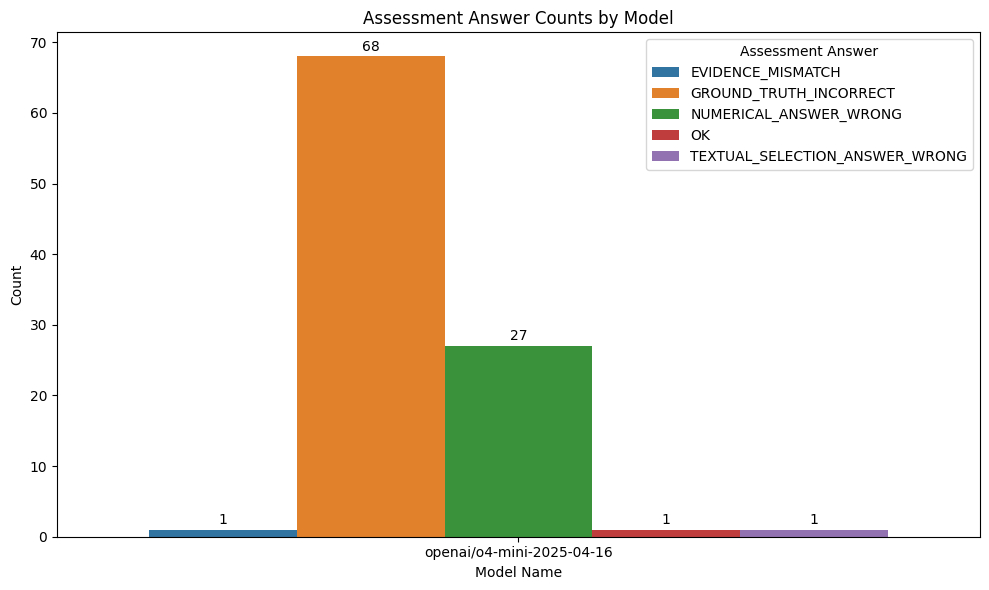

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(judge_results)
grouped = (
    df.groupby(["model_name", "assessment_answer"]).size().reset_index(name="count")
)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped, x="model_name", y="count", hue="assessment_answer")
plt.title("Assessment Answer Counts by Model")
plt.ylabel("Count")
plt.xlabel("Model Name")
plt.legend(title="Assessment Answer")
plt.tight_layout()

# Add value annotations
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{int(height)}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            xytext=(0, 2),
            textcoords="offset points",
        )

plt.show()

In [186]:
df.to_csv('./judge_results/final_judge_results.csv', index=False)


In [187]:
df.shape

(98, 7)

As seen before,

- 68 of the examples have an incorrect ground truth i.e our generated answers are correct.
- Of the 27 answers that were marked as NUMERICAL_ANSWER_WRONG, some of them are because the llm incorrectly computed some fractions. While this could've been solved with tool calling/using a python interpretor, this would've made the pipeline more tricky. More on this soon.
- The example marked as "EVIDENCE_MISMATCH" correctly identifies that the model got confused with the given context, and could not resolve the question given the previous conversation history. This step could likely be improved by doing some-form of query rewriting.

Overall, assuming the all the judge results are correct for the "GROUND_TRUTH_INCORRECT"  label, our overall accuracy is acrually:

$$
\frac{(580 + 68)}{678} = 95.5\%
$$

Note that this is a _super optimistic_ estimate, as we have not accounted for the fact that the judge might have made a mistake in their evaluation. Also, since we didn't judge the _baseline_ o4-mini performance, the overall accuracy might be lower than what we've calculated here.


## Conclusion

We've implemented a **curriculum learning** based methodology to develop our system to answer questions ConvFinQA dataset. 

We've kept the system purely based on prompts, for a few reasons:
- Instead of prompt engineering, we used DSPy to automatically _optimise_ our programs and find the best combination of instructions + few shot examples that work for our dataset.
  - This helped avoid the manual trail-and-error approach of refining the prompts and few-shot examples, and also helped benchmark many models using the same codebase.

### Why no agents?

In this assignment, I've deliberately chosen to _not use_ any agentic systems because:

- Adding agents requires implementation of tools that the agents can use. 
   - The only operations that need tools in this dataset are simple mathematical ops(add, subtract, etc.)
   - Recent models are increasingly getting better at predicting results of math operations, purely through next-token prediction. The recent [IMO Gold Medal](https://www.nature.com/articles/d41586-025-02343-x) models by OAI and Deepmind has confirmed that next-token prediction is enough to solve even some of the most challenging math problems and proofs.
   - Adding tool calling tests another model ability: Instruction Following. Specfically, all tool call are returned in a specific format by the model, and while they mostly suceed, this introduces another area where we have to handle errors.

We argue that in the future model releases, tool calls for doing `math operations` will be not be required. Instead, tools will be used primarily to help the model get access to _your_ data, such as emails, company slack, etc. via the MCP protocol, and do operations _on your behalf_.

### Why no fine-tuning?

[Recent research](https://arxiv.org/abs/2507.19457) has shown that good _prompt optimisation_ can lead to better results compared to finetuning, even when we using reinforcement-learning. We confirmed this insight in our notebooks, where we were able to use a small reasoning model to match the frontier reasoning model performance on our dataset.

### What could be improved?

If we had more time, I would explore the following:

- The current methodology of supplying the table content is quite simple. We know that table formatting affects how models understand content. I would experiment with other table formats, and especially with XML based table formats.
- Currently, the `evidence_snippets` i.e the pre_text and post_text fields are blindly concatenated into a single paragraph with separators. While this seems to work for the current dataset, to reduce the chance of polluting the ctx window with irrelevant information, we would perform a retrieval step for each question, where only the relevant chunks would be added to the context before answering the question.
  - Because this dataset has many domain specific terms(financial metrics), we argue that BM25 based methods should give a strong baseline, followed by using a late-interaction mechanism(such as ColBERT) to improve retrieval further.
  - For the domain specific terms, we could also add a stage to retrieve the precise definition of a metric asked in the question, which could further help disambiguate the meaning of the metric. For this, we would use the [Financial Readability Assessment(FinRAD) Dataset](https://github.com/sohomghosh/FinRAD_Financial_Readability_Assessment_Dataset).
- The current dataset has a nice setup for using Reinforcement Learning:
  - Specifically, we could model each dialogue as an episode in RL.
  - The metric for analysis would be things like answer formatting, answer correctness, answer coherence, etc. We can use hyperparams to control the weight of each of these components.
  - Finally, we could use GRPO, to train the model based a collection of it's own outputs, and picking the best output from them. This is the same methodology used to train Deepseek R1.
  - DSPy does support optmising a model with GRPO, using the Arbor RL server. I would aim to experiment with this approach.
- Finally, our solution still uses a hosted model. 
  - Some businesses may want to use their own hosted/open-source model, particularly those with goverment regulations.
  - We would experiment with the `BootstrapFinetune` method from DSPy to finetune a small LM to match the performance of a large LM. Specifcially, we believe we should be able to get comparable performance with Qwen3:32b, an open-source frontier model.

Thanks for sticking around! I hope you leanred something new/interesting! Spotted a bug or have a optimization? Open an issue in the repo, or yell at me on [Twitter/X](https://x.com/shubhamg2208). Happy hacking!